# Sequence to Sequence Modelling

### Name: Xiaohui Guo

### UNI: xg2225

In [344]:
import keras
print(keras.__version__)

2.0.4


#### The version of keras is "2.0.4"

In [345]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7506524066601813976
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 309723136
locality {
  bus_id: 1
}
incarnation: 11546559095746642287
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 357957632
locality {
  bus_id: 1
}
incarnation: 7269598334004712426
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:00:05.0, compute capability: 3.7"
]


In [346]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [347]:


from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings("ignore")
import operator
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense, Dropout, Reshape, RepeatVector,Merge, BatchNormalization, TimeDistributed, Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D
from numpy import argmax
from keras.preprocessing.text import text_to_word_sequence
from rouge import Rouge
from keras.models import model_from_json
from keras.callbacks import TensorBoard









**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

![title](seq2seq.png)

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [5]:
MAX_LEN = 36
VOCAB_SIZE = 12000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [348]:
def load_data(article, summary, max_len, vocab_size):
    # get article vocabulary
    tokenizer_1 = Tokenizer()
    tokenizer_1.fit_on_texts(article)
    counts_1=dict(tokenizer_1.word_counts)
    words_1=sorted(counts_1.items(), key=operator.itemgetter(1), reverse=True)
    vocabWord_1=[x[0] for x in words_1][:vocab_size]
    vocabWord_1.insert(0,'ZERO')
    vocabIdx_1=list(range(0,vocab_size))
    artVocabulary = dict(zip(vocabWord_1,vocabIdx_1))
    
    # get summary vocabulary
    tokenizer_2 = Tokenizer()
    tokenizer_2.fit_on_texts(summary)
    counts_2=dict(tokenizer_2.word_counts)
    words_2=sorted(counts_2.items(), key=operator.itemgetter(1), reverse=True)
    vocabWord_2=[x[0] for x in words_2][:vocab_size]
    vocabWord_2.insert(0,'ZERO')
    vocabIdx_2=list(range(0,vocab_size))
    sumVococabulary = dict(zip(vocabWord_2,vocabIdx_2))
    
    #
    unk_idx_article = artVocabulary.get('unk')
    artMapData=[]   
    for i in range(len(article)):
        x=text_to_word_sequence(article[i],filters='',lower=True,split=" ")
        d=[artVocabulary[n] if n in artVocabulary else unk_idx_article for n in x] 
        artMapData.append(d)
        
    #
    unk_idx_summary = sumVococabulary.get('unk')
    sumMapData=[]   
    for i in range(len(summary)):
        x=text_to_word_sequence(summary[i],filters='',lower=True,split=" ")
        d=[sumVococabulary[n] if n in sumVococabulary else unk_idx_summary for n in x] 
        sumMapData.append(d)
    
    
    artPadData = pad_sequences(artMapData,maxlen=max_len, padding='post', truncating='post') 
    sumPadData=pad_sequences(sumMapData,maxlen= max_len, padding='post', truncating='post')
    
    len_of_artVoc = len(artVocabulary)
    len_of_sumVoc = len(sumVococabulary)
    
    idx2word_articledata = {v: k for k, v in artVocabulary.items()}
    idx2word_summarydata = {v: k for k, v in sumVococabulary.items()}
    
    return artPadData,len_of_artVoc, artVocabulary,idx2word_articledata,sumPadData,len_of_sumVoc,sumVococabulary,idx2word_summarydata




Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [7]:
# TO-DO 
article_text_train =  open('data/train_article.txt', 'r')
summary_text_train =  open('data/train_title.txt', 'r')


articleTrain_data=article_text_train.read().splitlines()
summaryTrain_data=summary_text_train.read().splitlines()



training_article_data = load_data(articleTrain_data,summaryTrain_data,MAX_LEN,VOCAB_SIZE)



transformed_article_data_train = training_article_data[0]
Vocab_size_of_article_train = training_article_data[1]
word2idx_article_train = training_article_data[2]
dx2word_articl_train = training_article_data[3]
transformed_summary_data_train = training_article_data[4]
Vocab_size_of_summary_train = training_article_data[5]
word2idx_summary_train = training_article_data[6]
idx2word_summary_train = training_article_data[7]




# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [10]:
BATCH_SIZE = 35
NUM_LAYERS = 1
HIDDEN_DIM = 30
EPOCHS = 100



Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [11]:
def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder
   
    model = Sequential()
    #encoder
    #Add embedding layer
    model.add(Embedding(input_dim=X_vocab_len, output_dim=200, input_length=MAX_LEN,mask_zero=True,trainable=False))
    #Add LSTM Layer as encoder
    model.add(LSTM(hidden_size))
    #Add RepeatVector Layer
    model.add(RepeatVector(MAX_LEN))
    
    #decoder
    #Add LSTM layer as decoder
    model.add(LSTM(hidden_size, return_sequences=True))
    #Add timedistributed dense layer
    model.add(TimeDistributed(Dense(y_vocab_len)))
    #Add activation layer
    model.add(Activation('softmax'))
    #Add compile layer
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])    
    #Add summary layer
    model.summary()

    return model

# reference: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [12]:
# TO-DO

model=create_UniLSTM(Vocab_size_of_article_train,MAX_LEN,Vocab_size_of_summary_train,MAX_LEN,HIDDEN_DIM,NUM_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 200)           2400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                27720     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 36, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 36, 30)            7320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 36, 12000)         372000    
_________________________________________________________________
activation_1 (Activation)    (None, 36, 12000)         0         
Total params: 2,807,040
Trainable params: 407,040
Non-trainable params: 2,400,000
____________________________________________________________

In [13]:
# serialize model to JSON
# model_json = model_without_attention.to_json()
# with open("./without_attention_model_json_folder1/without_attention_model.json", "w") as json_file:
#    json_file.write(model_json)

In [ ]:
len_of_transformed_article_data_train = len(transformed_article_data_train)
for p in range(1,EPOCHS+1):
    for item in range(0, len_of_transformed_article_data_train, 1000):
        if item + 1000 >= len_of_transformed_article_data_train:
            last_item = len_of_transformed_article_data_train
        else:
            last_item = item + 1000
        
        summary=transformed_summary_data_train[item:last_item]
        
        summary_one_hot = (np.arange(transformed_summary_data_train.max()+1) == summary[...,None]).astype(int)# One Hot 
        
        print('Medel is training: epoch {}th {}/{} samples'.format(p, item, len_of_transformed_article_data_train))
        model.fit(transformed_article_data_train[item:last_item], summary_one_hot, batch_size=BATCH_SIZE, nb_epoch=1,verbose=1,shuffle = True)
    model.save_weights('./without_attention_weights/checkpoint_epoch_{}.hdf5'.format(p))   



Medel is training: epoch 1th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.7710 - acc: 0.7801     
Medel is training: epoch 1th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6165 - acc: 0.8034     
Medel is training: epoch 5th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4850 - acc: 0.8137     
Medel is training: epoch 5th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6881 - acc: 0.7944     
Medel is training: epoch 5th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5287 - acc: 0.8122     
Medel is training: epoch 5th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6112 - acc: 0.8020     
Medel is training: epoch 5th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6523 - acc: 0.8004     
Medel is training: ep

1000/1000 [==============================] - 5s - loss: 1.4911 - acc: 0.8144     
Medel is training: epoch 6th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.7208 - acc: 0.7893     
Medel is training: epoch 6th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6026 - acc: 0.8060     
Medel is training: epoch 6th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4693 - acc: 0.8151     
Medel is training: epoch 6th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6673 - acc: 0.7964     
Medel is training: epoch 6th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6125 - acc: 0.8057     
Medel is training: epoch 6th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4490 - acc: 0.8175     
Medel is training: epoch 6th 19000/50001 samples
Epoch 1/1
1000/1000 [==

1000/1000 [==============================] - 5s - loss: 1.7017 - acc: 0.7941     
Medel is training: epoch 8th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6044 - acc: 0.8056     
Medel is training: epoch 8th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3613 - acc: 0.8236     
Medel is training: epoch 8th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.7142 - acc: 0.7918     
Medel is training: epoch 8th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5994 - acc: 0.8049     
Medel is training: epoch 8th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4123 - acc: 0.8181     
Medel is training: epoch 8th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5156 - acc: 0.8090     
Medel is training: epoch 8th 33000/50001 samples
Epoch 1/1
1000/1000 [==

1000/1000 [==============================] - 5s - loss: 1.7210 - acc: 0.7898     
Medel is training: epoch 10th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5708 - acc: 0.8101     
Medel is training: epoch 10th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5937 - acc: 0.8029     
Medel is training: epoch 10th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3272 - acc: 0.8223     
Medel is training: epoch 10th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.7078 - acc: 0.7917     
Medel is training: epoch 10th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6100 - acc: 0.8044     
Medel is training: epoch 10th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5292 - acc: 0.8082     
Medel is training: epoch 10th 47000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.3316 - acc: 0.8217     
Medel is training: epoch 11th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.7002 - acc: 0.7915     
Medel is training: epoch 11th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6599 - acc: 0.7979     
Medel is training: epoch 11th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5924 - acc: 0.9722
Medel is training: epoch 12th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6946 - acc: 0.7937     
Medel is training: epoch 12th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5108 - acc: 0.8129     
Medel is training: epoch 12th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5660 - acc: 0.8038     
Medel is training: epoch 12th 3000/50001 samples
Epoch 1/1
1000/1000 [=============

1000/1000 [==============================] - 5s - loss: 1.5779 - acc: 0.8070     
Medel is training: epoch 13th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4673 - acc: 0.8157     
Medel is training: epoch 13th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6576 - acc: 0.7969     
Medel is training: epoch 13th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5972 - acc: 0.8038     
Medel is training: epoch 13th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4565 - acc: 0.8148     
Medel is training: epoch 13th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6663 - acc: 0.7958     
Medel is training: epoch 13th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5012 - acc: 0.8124     
Medel is training: epoch 13th 10000/50001 samples
Epoch 1/1
1000/1000 [=

1000/1000 [==============================] - 5s - loss: 1.5801 - acc: 0.8031     
Medel is training: epoch 14th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6333 - acc: 0.8008     
Medel is training: epoch 14th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4649 - acc: 0.8146     
Medel is training: epoch 14th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6931 - acc: 0.7905     
Medel is training: epoch 14th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5883 - acc: 0.8058     
Medel is training: epoch 14th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4404 - acc: 0.8156     
Medel is training: epoch 14th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6427 - acc: 0.7971     
Medel is training: epoch 14th 17000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5933 - acc: 0.8056     
Medel is training: epoch 15th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4085 - acc: 0.8191     
Medel is training: epoch 15th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6522 - acc: 0.7946     
Medel is training: epoch 15th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5732 - acc: 0.8093     
Medel is training: epoch 15th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4309 - acc: 0.8174     
Medel is training: epoch 15th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6150 - acc: 0.7983     
Medel is training: epoch 15th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6217 - acc: 0.8024     
Medel is training: epoch 15th 24000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4700 - acc: 0.8144     
Medel is training: epoch 16th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4468 - acc: 0.8131     
Medel is training: epoch 16th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6767 - acc: 0.7944     
Medel is training: epoch 16th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5862 - acc: 0.8057     
Medel is training: epoch 16th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2749 - acc: 0.8303     
Medel is training: epoch 16th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6827 - acc: 0.7932     
Medel is training: epoch 16th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5802 - acc: 0.8052     
Medel is training: epoch 16th 31000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.3268 - acc: 0.8271     
Medel is training: epoch 17th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4554 - acc: 0.8119     
Medel is training: epoch 17th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6618 - acc: 0.7941     
Medel is training: epoch 17th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5957 - acc: 0.8043     
Medel is training: epoch 17th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2171 - acc: 0.8321     
Medel is training: epoch 17th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6151 - acc: 0.7976     
Medel is training: epoch 17th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6012 - acc: 0.8031     
Medel is training: epoch 17th 38000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5055 - acc: 0.8118     
Medel is training: epoch 18th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2351 - acc: 0.8315     
Medel is training: epoch 18th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6860 - acc: 0.7907     
Medel is training: epoch 18th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5445 - acc: 0.8101     
Medel is training: epoch 18th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5612 - acc: 0.8048     
Medel is training: epoch 18th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2280 - acc: 0.8309     
Medel is training: epoch 18th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6688 - acc: 0.7918     
Medel is training: epoch 18th 45000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5796 - acc: 0.8048     
Medel is training: epoch 19th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4816 - acc: 0.8129     
Medel is training: epoch 19th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2341 - acc: 0.8327     
Medel is training: epoch 19th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6596 - acc: 0.7912     
Medel is training: epoch 19th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6294 - acc: 0.7980     
Medel is training: epoch 19th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3747 - acc: 1.0000
Medel is training: epoch 20th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6664 - acc: 0.7940     
Medel is training: epoch 20th 1000/50001 samples
Epoch 1/1
1000/1000 [===========

1000/1000 [==============================] - 5s - loss: 1.4739 - acc: 0.8131     
Medel is training: epoch 21th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5142 - acc: 0.8044     
Medel is training: epoch 21th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5583 - acc: 0.8070     
Medel is training: epoch 21th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4097 - acc: 0.8167     
Medel is training: epoch 21th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6292 - acc: 0.7975     
Medel is training: epoch 21th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5801 - acc: 0.8039     
Medel is training: epoch 21th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3920 - acc: 0.8165     
Medel is training: epoch 21th 8000/50001 samples
Epoch 1/1
1000/1000 [==

1000/1000 [==============================] - 5s - loss: 1.6347 - acc: 0.7962     
Medel is training: epoch 22th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4542 - acc: 0.8139     
Medel is training: epoch 22th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5289 - acc: 0.8046     
Medel is training: epoch 22th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6099 - acc: 0.8010     
Medel is training: epoch 22th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4065 - acc: 0.8177     
Medel is training: epoch 22th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6565 - acc: 0.7916     
Medel is training: epoch 22th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5690 - acc: 0.8058     
Medel is training: epoch 22th 15000/50001 samples
Epoch 1/1
1000/10

1000/1000 [==============================] - 5s - loss: 1.3664 - acc: 0.8186     
Medel is training: epoch 23th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6017 - acc: 0.7984     
Medel is training: epoch 23th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5749 - acc: 0.8058     
Medel is training: epoch 23th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3527 - acc: 0.8207     
Medel is training: epoch 23th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6181 - acc: 0.7956     
Medel is training: epoch 23th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5518 - acc: 0.8094     
Medel is training: epoch 23th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3807 - acc: 0.8201     
Medel is training: epoch 23th 22000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5696 - acc: 0.7998     
Medel is training: epoch 24th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5994 - acc: 0.8026     
Medel is training: epoch 24th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4419 - acc: 0.8159     
Medel is training: epoch 24th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4071 - acc: 0.8144     
Medel is training: epoch 24th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6530 - acc: 0.7947     
Medel is training: epoch 24th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5724 - acc: 0.8057     
Medel is training: epoch 24th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2267 - acc: 0.8332     
Medel is training: epoch 24th 29000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.6541 - acc: 0.7936     
Medel is training: epoch 25th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5632 - acc: 0.8053     
Medel is training: epoch 25th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2929 - acc: 0.8299     
Medel is training: epoch 25th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4253 - acc: 0.8137     
Medel is training: epoch 25th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6426 - acc: 0.7947     
Medel is training: epoch 25th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5832 - acc: 0.8043     
Medel is training: epoch 25th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1785 - acc: 0.8359     
Medel is training: epoch 25th 36000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5865 - acc: 0.7984     
Medel is training: epoch 26th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5806 - acc: 0.8034     
Medel is training: epoch 26th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4906 - acc: 0.8131     
Medel is training: epoch 26th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1998 - acc: 0.8353     
Medel is training: epoch 26th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6628 - acc: 0.7916     
Medel is training: epoch 26th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5315 - acc: 0.8102     
Medel is training: epoch 26th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5437 - acc: 0.8055     
Medel is training: epoch 26th 43000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.1895 - acc: 0.8366     
Medel is training: epoch 27th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6470 - acc: 0.7926     
Medel is training: epoch 27th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5671 - acc: 0.8047     
Medel is training: epoch 27th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4654 - acc: 0.8131     
Medel is training: epoch 27th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2005 - acc: 0.8343     
Medel is training: epoch 27th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6376 - acc: 0.7922     
Medel is training: epoch 27th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6148 - acc: 0.7982     
Medel is training: epoch 27th 50000/50001 samples
Epoch 1/1
1/1 [=

1/1 [==============================] - 0s - loss: 0.2599 - acc: 1.0000
Medel is training: epoch 29th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6506 - acc: 0.7940     
Medel is training: epoch 29th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4551 - acc: 0.8145     
Medel is training: epoch 29th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4911 - acc: 0.8061     
Medel is training: epoch 29th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5467 - acc: 0.8071     
Medel is training: epoch 29th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3795 - acc: 0.8182     
Medel is training: epoch 29th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6125 - acc: 0.7979     
Medel is training: epoch 29th 6000/50001 samples
Epoch 1/1
1000/1000 [================

1000/1000 [==============================] - 5s - loss: 1.6371 - acc: 0.7922     
Medel is training: epoch 31th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5576 - acc: 0.8060     
Medel is training: epoch 31th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3363 - acc: 0.8227     
Medel is training: epoch 31th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5845 - acc: 0.7987     
Medel is training: epoch 31th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5644 - acc: 0.8057     
Medel is training: epoch 31th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3240 - acc: 0.8245     
Medel is training: epoch 31th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6002 - acc: 0.7956     
Medel is training: epoch 31th 20000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5384 - acc: 0.8094     
Medel is training: epoch 32th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3524 - acc: 0.8228     
Medel is training: epoch 32th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5482 - acc: 0.8014     
Medel is training: epoch 32th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5889 - acc: 0.8028     
Medel is training: epoch 32th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4193 - acc: 0.8186     
Medel is training: epoch 32th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3789 - acc: 0.8174     
Medel is training: epoch 32th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6374 - acc: 0.7952     
Medel is training: epoch 32th 27000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5606 - acc: 0.8060     
Medel is training: epoch 33th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1851 - acc: 0.8383     
Medel is training: epoch 33th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6383 - acc: 0.7938     
Medel is training: epoch 33th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5534 - acc: 0.8056     
Medel is training: epoch 33th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2654 - acc: 0.8325     
Medel is training: epoch 33th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4014 - acc: 0.8159     
Medel is training: epoch 33th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6272 - acc: 0.7949     
Medel is training: epoch 33th 34000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5727 - acc: 0.8044     
Medel is training: epoch 34th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1346 - acc: 0.8409     
Medel is training: epoch 34th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5652 - acc: 0.7990     
Medel is training: epoch 34th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5677 - acc: 0.8036     
Medel is training: epoch 34th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4757 - acc: 0.8134     
Medel is training: epoch 34th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1654 - acc: 0.8382     
Medel is training: epoch 34th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6451 - acc: 0.7917     
Medel is training: epoch 34th 41000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5186 - acc: 0.8104     
Medel is training: epoch 35th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5281 - acc: 0.8059     
Medel is training: epoch 35th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1580 - acc: 0.8383     
Medel is training: epoch 35th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6275 - acc: 0.7928     
Medel is training: epoch 35th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5557 - acc: 0.8049     
Medel is training: epoch 35th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4507 - acc: 0.8136     
Medel is training: epoch 35th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1697 - acc: 0.8365     
Medel is training: epoch 35th 48000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.6183 - acc: 0.7925     
Medel is training: epoch 36th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5982 - acc: 0.7991     
Medel is training: epoch 36th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1925 - acc: 1.0000
Medel is training: epoch 37th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6400 - acc: 0.7944     
Medel is training: epoch 37th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4379 - acc: 0.8152     
Medel is training: epoch 37th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4715 - acc: 0.8068     
Medel is training: epoch 37th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5353 - acc: 0.8074     
Medel is training: epoch 37th 4000/50001 samples
Epoch 1/1
1000/1000 [==============

1000/1000 [==============================] - 5s - loss: 1.3504 - acc: 0.8216     
Medel is training: epoch 38th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5964 - acc: 0.7983     
Medel is training: epoch 38th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5581 - acc: 0.8038     
Medel is training: epoch 38th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3330 - acc: 0.8209     
Medel is training: epoch 38th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6082 - acc: 0.7969     
Medel is training: epoch 38th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4163 - acc: 0.8163     
Medel is training: epoch 38th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4842 - acc: 0.8075     
Medel is training: epoch 38th 11000/50001 samples
Epoch 1/1
1000/1000 [

1000/1000 [==============================] - 5s - loss: 1.5866 - acc: 0.8013     
Medel is training: epoch 39th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3590 - acc: 0.8214     
Medel is training: epoch 39th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6213 - acc: 0.7928     
Medel is training: epoch 39th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5471 - acc: 0.8059     
Medel is training: epoch 39th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3119 - acc: 0.8255     
Medel is training: epoch 39th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5687 - acc: 0.7994     
Medel is training: epoch 39th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5541 - acc: 0.8058     
Medel is training: epoch 39th 18000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.2967 - acc: 0.8273     
Medel is training: epoch 40th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5810 - acc: 0.7967     
Medel is training: epoch 40th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5262 - acc: 0.8095     
Medel is training: epoch 40th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3309 - acc: 0.8246     
Medel is training: epoch 40th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5258 - acc: 0.8021     
Medel is training: epoch 40th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 6s - loss: 1.5764 - acc: 0.8026     
Medel is training: epoch 40th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4015 - acc: 0.8194     
Medel is training: epoch 40th 25000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.3540 - acc: 0.8194     
Medel is training: epoch 41th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6223 - acc: 0.7954     
Medel is training: epoch 41th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5519 - acc: 0.8057     
Medel is training: epoch 41th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1574 - acc: 0.8404     
Medel is training: epoch 41th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6204 - acc: 0.7947     
Medel is training: epoch 41th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5433 - acc: 0.8056     
Medel is training: epoch 41th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2444 - acc: 0.8346     
Medel is training: epoch 41th 32000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.3774 - acc: 0.8162     
Medel is training: epoch 42th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6086 - acc: 0.7957     
Medel is training: epoch 42th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5649 - acc: 0.8043     
Medel is training: epoch 42th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1068 - acc: 0.8433     
Medel is training: epoch 42th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5475 - acc: 0.7997     
Medel is training: epoch 42th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5559 - acc: 0.8034     
Medel is training: epoch 42th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4653 - acc: 0.8136     
Medel is training: epoch 42th 39000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.1366 - acc: 0.8400     
Medel is training: epoch 43th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6256 - acc: 0.7922     
Medel is training: epoch 43th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5048 - acc: 0.8111     
Medel is training: epoch 43th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5165 - acc: 0.8064     
Medel is training: epoch 43th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1330 - acc: 0.8401     
Medel is training: epoch 43th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6069 - acc: 0.7934     
Medel is training: epoch 43th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5419 - acc: 0.8051     
Medel is training: epoch 43th 46000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4369 - acc: 0.8139     
Medel is training: epoch 44th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1418 - acc: 0.8393     
Medel is training: epoch 44th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5995 - acc: 0.7933     
Medel is training: epoch 44th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5831 - acc: 0.7994     
Medel is training: epoch 44th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1758 - acc: 1.0000
Medel is training: epoch 45th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6273 - acc: 0.7947     
Medel is training: epoch 45th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4240 - acc: 0.8158     
Medel is training: epoch 45th 2000/50001 samples
Epoch 1/1
1000/1000 [============

1000/1000 [==============================] - 5s - loss: 1.4515 - acc: 0.8091     
Medel is training: epoch 46th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5257 - acc: 0.8077     
Medel is training: epoch 46th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3328 - acc: 0.8231     
Medel is training: epoch 46th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5827 - acc: 0.7994     
Medel is training: epoch 46th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5485 - acc: 0.8036     
Medel is training: epoch 46th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3123 - acc: 0.8226     
Medel is training: epoch 46th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5944 - acc: 0.7976     
Medel is training: epoch 46th 9000/50001 samples
Epoch 1/1
1000/1000 [==

1000/1000 [==============================] - 5s - loss: 1.4025 - acc: 0.8167     
Medel is training: epoch 47th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4635 - acc: 0.8091     
Medel is training: epoch 47th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5761 - acc: 0.8015     
Medel is training: epoch 47th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3439 - acc: 0.8225     
Medel is training: epoch 47th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6044 - acc: 0.7935     
Medel is training: epoch 47th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5384 - acc: 0.8059     
Medel is training: epoch 47th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2939 - acc: 0.8269     
Medel is training: epoch 47th 16000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5504 - acc: 0.7999     
Medel is training: epoch 48th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5435 - acc: 0.8058     
Medel is training: epoch 48th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2793 - acc: 0.8280     
Medel is training: epoch 48th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5639 - acc: 0.7979     
Medel is training: epoch 48th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5148 - acc: 0.8099     
Medel is training: epoch 48th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3147 - acc: 0.8254     
Medel is training: epoch 48th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5047 - acc: 0.8023     
Medel is training: epoch 48th 23000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5628 - acc: 0.8029     
Medel is training: epoch 49th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3870 - acc: 0.8203     
Medel is training: epoch 49th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3352 - acc: 0.8204     
Medel is training: epoch 49th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6078 - acc: 0.7958     
Medel is training: epoch 49th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5440 - acc: 0.8055     
Medel is training: epoch 49th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1371 - acc: 0.8422     
Medel is training: epoch 49th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6025 - acc: 0.7962     
Medel is training: epoch 49th 30000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5321 - acc: 0.8056     
Medel is training: epoch 50th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2256 - acc: 0.8355     
Medel is training: epoch 50th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3575 - acc: 0.8179     
Medel is training: epoch 50th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5925 - acc: 0.7961     
Medel is training: epoch 50th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 6s - loss: 1.5547 - acc: 0.8043     
Medel is training: epoch 50th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0829 - acc: 0.8445     
Medel is training: epoch 50th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5288 - acc: 0.8007     
Medel is training: epoch 50th 37000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5414 - acc: 0.8039     
Medel is training: epoch 51th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4553 - acc: 0.8138     
Medel is training: epoch 51th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 6s - loss: 1.1136 - acc: 0.8414     
Medel is training: epoch 51th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6074 - acc: 0.7932     
Medel is training: epoch 51th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4910 - acc: 0.8114     
Medel is training: epoch 51th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5070 - acc: 0.8062     
Medel is training: epoch 51th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 6s - loss: 1.1116 - acc: 0.8411     
Medel is training: epoch 51th 44000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5867 - acc: 0.7945     
Medel is training: epoch 52th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5276 - acc: 0.8056     
Medel is training: epoch 52th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4260 - acc: 0.8145     
Medel is training: epoch 52th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1205 - acc: 0.8407     
Medel is training: epoch 52th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5813 - acc: 0.7942     
Medel is training: epoch 52th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5673 - acc: 0.7997     
Medel is training: epoch 52th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1605 - acc: 1.0000
Medel is training: epoch 53th 0/50001 samples
Epoch 1/1
1000/1000 [==========

1000/1000 [==============================] - 5s - loss: 1.6125 - acc: 0.7952     
Medel is training: epoch 54th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4104 - acc: 0.8163     
Medel is training: epoch 54th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4344 - acc: 0.8093     
Medel is training: epoch 54th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5176 - acc: 0.8077     
Medel is training: epoch 54th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3173 - acc: 0.8238     
Medel is training: epoch 54th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5697 - acc: 0.7990     
Medel is training: epoch 54th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5408 - acc: 0.8038     
Medel is training: epoch 54th 7000/50001 samples
Epoch 1/1
1000/1000 [==

1000/1000 [==============================] - 5s - loss: 1.2896 - acc: 0.8246     
Medel is training: epoch 55th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5806 - acc: 0.7977     
Medel is training: epoch 55th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3913 - acc: 0.8177     
Medel is training: epoch 55th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4467 - acc: 0.8096     
Medel is training: epoch 55th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5651 - acc: 0.8016     
Medel is training: epoch 55th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3311 - acc: 0.8233     
Medel is training: epoch 55th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5885 - acc: 0.7939     
Medel is training: epoch 55th 14000/50001 samples
Epoch 1/1
1000/100

1000/1000 [==============================] - 5s - loss: 1.5286 - acc: 0.8062     
Medel is training: epoch 56th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2765 - acc: 0.8276     
Medel is training: epoch 56th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5349 - acc: 0.8008     
Medel is training: epoch 56th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5337 - acc: 0.8060     
Medel is training: epoch 56th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2642 - acc: 0.8287     
Medel is training: epoch 56th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5471 - acc: 0.7985     
Medel is training: epoch 56th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5047 - acc: 0.8098     
Medel is training: epoch 56th 21000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.2999 - acc: 0.8264     
Medel is training: epoch 57th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4828 - acc: 0.8033     
Medel is training: epoch 57th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5520 - acc: 0.8031     
Medel is training: epoch 57th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3763 - acc: 0.8208     
Medel is training: epoch 57th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3178 - acc: 0.8215     
Medel is training: epoch 57th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5940 - acc: 0.7964     
Medel is training: epoch 57th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5366 - acc: 0.8057     
Medel is training: epoch 57th 28000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.1156 - acc: 0.8438     
Medel is training: epoch 58th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5832 - acc: 0.7957     
Medel is training: epoch 58th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5231 - acc: 0.8059     
Medel is training: epoch 58th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2122 - acc: 0.8366     
Medel is training: epoch 58th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3401 - acc: 0.8192     
Medel is training: epoch 58th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5776 - acc: 0.7967     
Medel is training: epoch 58th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5453 - acc: 0.8044     
Medel is training: epoch 58th 35000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.0599 - acc: 0.8474     
Medel is training: epoch 59th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5091 - acc: 0.8010     
Medel is training: epoch 59th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5288 - acc: 0.8043     
Medel is training: epoch 59th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4471 - acc: 0.8140     
Medel is training: epoch 59th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0953 - acc: 0.8435     
Medel is training: epoch 59th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5889 - acc: 0.7938     
Medel is training: epoch 59th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4809 - acc: 0.8116     
Medel is training: epoch 59th 42000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4977 - acc: 0.8064     
Medel is training: epoch 60th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0879 - acc: 0.8432     
Medel is training: epoch 60th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5713 - acc: 0.7949     
Medel is training: epoch 60th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5170 - acc: 0.8057     
Medel is training: epoch 60th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4164 - acc: 0.8148     
Medel is training: epoch 60th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1002 - acc: 0.8426     
Medel is training: epoch 60th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5660 - acc: 0.7945     
Medel is training: epoch 60th 49000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5532 - acc: 0.7999     
Medel is training: epoch 61th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1432 - acc: 1.0000
Medel is training: epoch 62th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.6014 - acc: 0.7955     
Medel is training: epoch 62th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4018 - acc: 0.8166     
Medel is training: epoch 62th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4211 - acc: 0.8104     
Medel is training: epoch 62th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5102 - acc: 0.8077     
Medel is training: epoch 62th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3033 - acc: 0.8250     
Medel is training: epoch 62th 5000/50001 samples
Epoch 1/1
1000/1000 [===============

1000/1000 [==============================] - 5s - loss: 1.3193 - acc: 0.8241     
Medel is training: epoch 64th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5726 - acc: 0.7946     
Medel is training: epoch 64th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5198 - acc: 0.8063     
Medel is training: epoch 64th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2640 - acc: 0.8287     
Medel is training: epoch 64th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5208 - acc: 0.8013     
Medel is training: epoch 64th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5257 - acc: 0.8059     
Medel is training: epoch 64th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2525 - acc: 0.8301     
Medel is training: epoch 64th 19000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5303 - acc: 0.7993     
Medel is training: epoch 65th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4953 - acc: 0.8101     
Medel is training: epoch 65th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2899 - acc: 0.8271     
Medel is training: epoch 65th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4670 - acc: 0.8044     
Medel is training: epoch 65th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5425 - acc: 0.8034     
Medel is training: epoch 65th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3660 - acc: 0.8212     
Medel is training: epoch 65th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3000 - acc: 0.8231     
Medel is training: epoch 65th 26000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5807 - acc: 0.7965     
Medel is training: epoch 66th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5299 - acc: 0.8058     
Medel is training: epoch 66th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0995 - acc: 0.8448     
Medel is training: epoch 66th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5685 - acc: 0.7962     
Medel is training: epoch 66th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5147 - acc: 0.8059     
Medel is training: epoch 66th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2005 - acc: 0.8375     
Medel is training: epoch 66th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3240 - acc: 0.8207     
Medel is training: epoch 66th 33000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5639 - acc: 0.7969     
Medel is training: epoch 67th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5381 - acc: 0.8045     
Medel is training: epoch 67th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0437 - acc: 0.8491     
Medel is training: epoch 67th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4937 - acc: 0.8019     
Medel is training: epoch 67th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5189 - acc: 0.8044     
Medel is training: epoch 67th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4397 - acc: 0.8143     
Medel is training: epoch 67th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0796 - acc: 0.8444     
Medel is training: epoch 67th 40000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5735 - acc: 0.7941     
Medel is training: epoch 68th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4710 - acc: 0.8117     
Medel is training: epoch 68th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4891 - acc: 0.8069     
Medel is training: epoch 68th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0704 - acc: 0.8453     
Medel is training: epoch 68th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5573 - acc: 0.7953     
Medel is training: epoch 68th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5069 - acc: 0.8060     
Medel is training: epoch 68th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4075 - acc: 0.8150     
Medel is training: epoch 68th 47000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.0828 - acc: 0.8440     
Medel is training: epoch 69th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5497 - acc: 0.7950     
Medel is training: epoch 69th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5448 - acc: 0.8002     
Medel is training: epoch 69th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1293 - acc: 1.0000
Medel is training: epoch 70th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5896 - acc: 0.7958     
Medel is training: epoch 70th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3932 - acc: 0.8173     
Medel is training: epoch 70th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4093 - acc: 0.8110     
Medel is training: epoch 70th 3000/50001 samples
Epoch 1/1
1000/1000 [=============

1000/1000 [==============================] - 5s - loss: 1.5030 - acc: 0.8080     
Medel is training: epoch 71th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2904 - acc: 0.8258     
Medel is training: epoch 71th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5465 - acc: 0.7998     
Medel is training: epoch 71th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5270 - acc: 0.8042     
Medel is training: epoch 71th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2589 - acc: 0.8267     
Medel is training: epoch 71th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5596 - acc: 0.7985     
Medel is training: epoch 71th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3744 - acc: 0.8191     
Medel is training: epoch 71th 10000/50001 samples
Epoch 1/1
1000/1000 [=

1000/1000 [==============================] - 5s - loss: 1.4165 - acc: 0.8115     
Medel is training: epoch 72th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5474 - acc: 0.8017     
Medel is training: epoch 72th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3096 - acc: 0.8248     
Medel is training: epoch 72th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5606 - acc: 0.7948     
Medel is training: epoch 72th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5134 - acc: 0.8066     
Medel is training: epoch 72th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2537 - acc: 0.8295     
Medel is training: epoch 72th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5083 - acc: 0.8015     
Medel is training: epoch 72th 17000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5184 - acc: 0.8063     
Medel is training: epoch 73th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2407 - acc: 0.8307     
Medel is training: epoch 73th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5175 - acc: 0.7997     
Medel is training: epoch 73th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4881 - acc: 0.8103     
Medel is training: epoch 73th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2805 - acc: 0.8274     
Medel is training: epoch 73th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4540 - acc: 0.8052     
Medel is training: epoch 73th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5350 - acc: 0.8036     
Medel is training: epoch 73th 24000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.3571 - acc: 0.8217     
Medel is training: epoch 74th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2850 - acc: 0.8236     
Medel is training: epoch 74th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5703 - acc: 0.7967     
Medel is training: epoch 74th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5248 - acc: 0.8059     
Medel is training: epoch 74th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0844 - acc: 0.8457     
Medel is training: epoch 74th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5532 - acc: 0.7965     
Medel is training: epoch 74th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5075 - acc: 0.8061     
Medel is training: epoch 74th 31000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.1885 - acc: 0.8383     
Medel is training: epoch 75th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3091 - acc: 0.8212     
Medel is training: epoch 75th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5536 - acc: 0.7971     
Medel is training: epoch 75th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5312 - acc: 0.8046     
Medel is training: epoch 75th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0298 - acc: 0.8501     
Medel is training: epoch 75th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4816 - acc: 0.8019     
Medel is training: epoch 75th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5097 - acc: 0.8047     
Medel is training: epoch 75th 38000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4318 - acc: 0.8144     
Medel is training: epoch 76th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0629 - acc: 0.8455     
Medel is training: epoch 76th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5604 - acc: 0.7942     
Medel is training: epoch 76th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4620 - acc: 0.8119     
Medel is training: epoch 76th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4828 - acc: 0.8071     
Medel is training: epoch 76th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0553 - acc: 0.8460     
Medel is training: epoch 76th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5449 - acc: 0.7957     
Medel is training: epoch 76th 45000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4975 - acc: 0.8060     
Medel is training: epoch 77th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3999 - acc: 0.8151     
Medel is training: epoch 77th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0681 - acc: 0.8448     
Medel is training: epoch 77th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5379 - acc: 0.7950     
Medel is training: epoch 77th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5344 - acc: 0.8004     
Medel is training: epoch 77th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1159 - acc: 1.0000
Medel is training: epoch 78th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5803 - acc: 0.7962     
Medel is training: epoch 78th 1000/50001 samples
Epoch 1/1
1000/1000 [===========

1000/1000 [==============================] - 5s - loss: 1.3845 - acc: 0.8178     
Medel is training: epoch 79th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3968 - acc: 0.8116     
Medel is training: epoch 79th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4977 - acc: 0.8083     
Medel is training: epoch 79th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2809 - acc: 0.8263     
Medel is training: epoch 79th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5375 - acc: 0.8000     
Medel is training: epoch 79th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5210 - acc: 0.8044     
Medel is training: epoch 79th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2465 - acc: 0.8274     
Medel is training: epoch 79th 8000/50001 samples
Epoch 1/1
1000/1000 [==

1000/1000 [==============================] - 5s - loss: 1.5490 - acc: 0.7985     
Medel is training: epoch 80th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3661 - acc: 0.8193     
Medel is training: epoch 80th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4054 - acc: 0.8116     
Medel is training: epoch 80th 11000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5400 - acc: 0.8019     
Medel is training: epoch 80th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3011 - acc: 0.8253     
Medel is training: epoch 80th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5500 - acc: 0.7951     
Medel is training: epoch 80th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5079 - acc: 0.8066     
Medel is training: epoch 80th 15000/50001 samples
Epoch 1/1
1000/10

1000/1000 [==============================] - 5s - loss: 1.2430 - acc: 0.8299     
Medel is training: epoch 81th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4959 - acc: 0.8020     
Medel is training: epoch 81th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5121 - acc: 0.8064     
Medel is training: epoch 81th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2312 - acc: 0.8312     
Medel is training: epoch 81th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5063 - acc: 0.7996     
Medel is training: epoch 81th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4815 - acc: 0.8103     
Medel is training: epoch 81th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2715 - acc: 0.8281     
Medel is training: epoch 81th 22000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4415 - acc: 0.8055     
Medel is training: epoch 82th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5266 - acc: 0.8036     
Medel is training: epoch 82th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3503 - acc: 0.8219     
Medel is training: epoch 82th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2737 - acc: 0.8238     
Medel is training: epoch 82th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5605 - acc: 0.7971     
Medel is training: epoch 82th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5198 - acc: 0.8060     
Medel is training: epoch 82th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0723 - acc: 0.8467     
Medel is training: epoch 82th 29000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5406 - acc: 0.7970     
Medel is training: epoch 83th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5002 - acc: 0.8061     
Medel is training: epoch 83th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1800 - acc: 0.8387     
Medel is training: epoch 83th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2976 - acc: 0.8218     
Medel is training: epoch 83th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5441 - acc: 0.7970     
Medel is training: epoch 83th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5258 - acc: 0.8046     
Medel is training: epoch 83th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0183 - acc: 0.8504     
Medel is training: epoch 83th 36000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4687 - acc: 0.8024     
Medel is training: epoch 84th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5002 - acc: 0.8046     
Medel is training: epoch 84th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4253 - acc: 0.8150     
Medel is training: epoch 84th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0496 - acc: 0.8469     
Medel is training: epoch 84th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5484 - acc: 0.7942     
Medel is training: epoch 84th 41000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4539 - acc: 0.8124     
Medel is training: epoch 84th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4771 - acc: 0.8072     
Medel is training: epoch 84th 43000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.0404 - acc: 0.8471     
Medel is training: epoch 85th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5317 - acc: 0.7963     
Medel is training: epoch 85th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4896 - acc: 0.8062     
Medel is training: epoch 85th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3946 - acc: 0.8156     
Medel is training: epoch 85th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0546 - acc: 0.8462     
Medel is training: epoch 85th 48000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5241 - acc: 0.7949     
Medel is training: epoch 85th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5246 - acc: 0.8005     
Medel is training: epoch 85th 50000/50001 samples
Epoch 1/1
1/1 [=

1/1 [==============================] - 0s - loss: 0.1016 - acc: 1.0000
Medel is training: epoch 87th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5693 - acc: 0.7962     
Medel is training: epoch 87th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3789 - acc: 0.8180     
Medel is training: epoch 87th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3852 - acc: 0.8119     
Medel is training: epoch 87th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4916 - acc: 0.8085     
Medel is training: epoch 87th 4000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2728 - acc: 0.8266     
Medel is training: epoch 87th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5291 - acc: 0.8001     
Medel is training: epoch 87th 6000/50001 samples
Epoch 1/1
1000/1000 [================

1000/1000 [==============================] - 5s - loss: 1.5382 - acc: 0.7953     
Medel is training: epoch 89th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5020 - acc: 0.8065     
Medel is training: epoch 89th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2345 - acc: 0.8303     
Medel is training: epoch 89th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4849 - acc: 0.8021     
Medel is training: epoch 89th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5053 - acc: 0.8063     
Medel is training: epoch 89th 18000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2228 - acc: 0.8312     
Medel is training: epoch 89th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4953 - acc: 0.7999     
Medel is training: epoch 89th 20000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4737 - acc: 0.8105     
Medel is training: epoch 90th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2633 - acc: 0.8287     
Medel is training: epoch 90th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4297 - acc: 0.8056     
Medel is training: epoch 90th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5199 - acc: 0.8034     
Medel is training: epoch 90th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3437 - acc: 0.8221     
Medel is training: epoch 90th 25000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2620 - acc: 0.8243     
Medel is training: epoch 90th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5511 - acc: 0.7970     
Medel is training: epoch 90th 27000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5134 - acc: 0.8063     
Medel is training: epoch 91th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0573 - acc: 0.8481     
Medel is training: epoch 91th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5301 - acc: 0.7971     
Medel is training: epoch 91th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4941 - acc: 0.8061     
Medel is training: epoch 91th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1721 - acc: 0.8390     
Medel is training: epoch 91th 32000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2863 - acc: 0.8226     
Medel is training: epoch 91th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5350 - acc: 0.7971     
Medel is training: epoch 91th 34000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5193 - acc: 0.8046     
Medel is training: epoch 92th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0062 - acc: 0.8517     
Medel is training: epoch 92th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4586 - acc: 0.8024     
Medel is training: epoch 92th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4918 - acc: 0.8050     
Medel is training: epoch 92th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4187 - acc: 0.8147     
Medel is training: epoch 92th 39000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0386 - acc: 0.8468     
Medel is training: epoch 92th 40000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5380 - acc: 0.7943     
Medel is training: epoch 92th 41000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.4446 - acc: 0.8121     
Medel is training: epoch 93th 42000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4712 - acc: 0.8076     
Medel is training: epoch 93th 43000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0285 - acc: 0.8477     
Medel is training: epoch 93th 44000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5213 - acc: 0.7961     
Medel is training: epoch 93th 45000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4825 - acc: 0.8061     
Medel is training: epoch 93th 46000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3884 - acc: 0.8158     
Medel is training: epoch 93th 47000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0422 - acc: 0.8473     
Medel is training: epoch 93th 48000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.5116 - acc: 0.7951     
Medel is training: epoch 94th 49000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5147 - acc: 0.8004     
Medel is training: epoch 94th 50000/50001 samples
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0893 - acc: 1.0000
Medel is training: epoch 95th 0/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5602 - acc: 0.7961     
Medel is training: epoch 95th 1000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3700 - acc: 0.8183     
Medel is training: epoch 95th 2000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3760 - acc: 0.8124     
Medel is training: epoch 95th 3000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4845 - acc: 0.8088     
Medel is training: epoch 95th 4000/50001 samples
Epoch 1/1
1000/1000 [==============

1000/1000 [==============================] - 5s - loss: 1.2628 - acc: 0.8272     
Medel is training: epoch 96th 5000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5188 - acc: 0.8002     
Medel is training: epoch 96th 6000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5104 - acc: 0.8046     
Medel is training: epoch 96th 7000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2234 - acc: 0.8278     
Medel is training: epoch 96th 8000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5323 - acc: 0.7991     
Medel is training: epoch 96th 9000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3528 - acc: 0.8196     
Medel is training: epoch 96th 10000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3851 - acc: 0.8126     
Medel is training: epoch 96th 11000/50001 samples
Epoch 1/1
1000/1000 [

1000/1000 [==============================] - 5s - loss: 1.5256 - acc: 0.8023     
Medel is training: epoch 97th 12000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2852 - acc: 0.8260     
Medel is training: epoch 97th 13000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5285 - acc: 0.7956     
Medel is training: epoch 97th 14000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4963 - acc: 0.8065     
Medel is training: epoch 97th 15000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2275 - acc: 0.8307     
Medel is training: epoch 97th 16000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4740 - acc: 0.8023     
Medel is training: epoch 97th 17000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4989 - acc: 0.8064     
Medel is training: epoch 97th 18000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.2135 - acc: 0.8316     
Medel is training: epoch 98th 19000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4841 - acc: 0.8006     
Medel is training: epoch 98th 20000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4680 - acc: 0.8105     
Medel is training: epoch 98th 21000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.2559 - acc: 0.8289     
Medel is training: epoch 98th 22000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4189 - acc: 0.8062     
Medel is training: epoch 98th 23000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5132 - acc: 0.8034     
Medel is training: epoch 98th 24000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.3372 - acc: 0.8226     
Medel is training: epoch 98th 25000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.2509 - acc: 0.8244     
Medel is training: epoch 99th 26000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5414 - acc: 0.7971     
Medel is training: epoch 99th 27000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5086 - acc: 0.8062     
Medel is training: epoch 99th 28000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.0473 - acc: 0.8489     
Medel is training: epoch 99th 29000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5204 - acc: 0.7972     
Medel is training: epoch 99th 30000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4870 - acc: 0.8063     
Medel is training: epoch 99th 31000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.1655 - acc: 0.8397     
Medel is training: epoch 99th 32000/50001 samples
Epoch 1/1
1000/1

1000/1000 [==============================] - 5s - loss: 1.2736 - acc: 0.8226     
Medel is training: epoch 100th 33000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5255 - acc: 0.7974     
Medel is training: epoch 100th 34000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.5141 - acc: 0.8046     
Medel is training: epoch 100th 35000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 0.9966 - acc: 0.8524     
Medel is training: epoch 100th 36000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4485 - acc: 0.8025     
Medel is training: epoch 100th 37000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4846 - acc: 0.8050     
Medel is training: epoch 100th 38000/50001 samples
Epoch 1/1
1000/1000 [==============================] - 5s - loss: 1.4125 - acc: 0.8151     
Medel is training: epoch 100th 39000/50001 samples
Epoch 1/1

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [14]:
# import test data
# TO-DO 
article_text_test =  open('data/test_article.txt', 'r')
summary_text_test =  open('data/test_title.txt', 'r')


articleTest_data=article_text_test.read().splitlines()
summaryTest_data=summary_text_test.read().splitlines()


# function to find the words that are in list 1 but not in list 2
def words_in_doc1_not_doc2(doc1,doc2):
    import numpy as np
    tokenizer1 = Tokenizer()
    tokenizer1.fit_on_texts(doc1)
    counts1=dict(tokenizer1.word_counts)

    tokenizer2 = Tokenizer()
    tokenizer2.fit_on_texts(doc2)
    counts2=dict(tokenizer2.word_counts)
    
    count1_list = list(counts1)
    count2_lsit = list(counts2)
    
    main_list = np.setdiff1d(count1_list,count2_lsit)
    
    return list(main_list)


target_word_to_unk = words_in_doc1_not_doc2(articleTest_data,articleTrain_data)
target_word_to_unk = target_word_to_unk + ['<unk>']

len(target_word_to_unk)



1516

In [15]:


# replace words not in training dataset as 'unk'

def replace_with_unk(replaced_word_list, doc):
    new_list = []
    for i in range(0,len(doc)):
        for j in range(0,len(replaced_word_list)):
            doc[i] = doc[i].replace(replaced_word_list[j],'unk')
        new_list.append(doc[i])
    return new_list



new_articleTest_data = replace_with_unk(target_word_to_unk, articleTest_data)


# replace '<unk>' with 'unk'
def standard_unk(doc):
    new_list = []
    for i in range(0,len(doc)):
        doc[i] = doc[i].replace('<unk>','unk')
        new_list.append(doc[i])
    return new_list



new_summaryTest_data = standard_unk(summaryTest_data)


testing_article_data = load_data(new_articleTest_data,new_summaryTest_data,MAX_LEN,VOCAB_SIZE)






In [16]:
testing_article_data = load_data(articleTest_data,summaryTest_data,MAX_LEN,VOCAB_SIZE)
transformed_article_data_test = testing_article_data[0]
Vocab_size_of_article_test = testing_article_data[1]
word2idx_article_test = testing_article_data[2]
dx2word_articl_test = testing_article_data[3]
transformed_summary_data_test = testing_article_data[4]
Vocab_size_of_summary_test = testing_article_data[5]
word2idx_summary_test = testing_article_data[6]
idx2word_summary_test = testing_article_data[7]
                                                       

In [38]:
                                             
# model.load_weights("./without_attention_weights_folder2/checkpoint_epoch_69.hdf5")
# print("Loaded model from disk")

model.load_weights("./without_attention_weights/checkpoint_epoch_97.hdf5")
print("Loaded model from disk")
y_hat = model.predict(transformed_article_data_test)





Loaded model from disk


In [39]:

# function to inverse a dictionary
def inverse_dictionary(dic):
    new_dic = {v: k for k, v in dic.items()}
    return new_dic

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

In [40]:
summary_test_word_id = inverse_dictionary(word2idx_summary_test)

In [41]:
# function to convert one hot to words
def one_hot_to_words(one_hot, MAX_LEN, dic):
    list1 = []
    for i in range(0,len(one_hot)):
        value = one_hot_decode(one_hot[i])
        list1.append(value)
        
    list2 = []
    for i in range(0,len(one_hot)):
        list3 = []
        for j in range(0,MAX_LEN):
            content = dic[list1[i][j]]
            list3.append(content)
        list2.append(list3)
    return list2


predicted_summary_list = one_hot_to_words(y_hat, MAX_LEN, summary_test_word_id)



# TO-DO
def import_Test_data(sum_T):

    summary_pad_data=[]   
    for i in range(len(sum_T)):
        ha=text_to_word_sequence(sum_T[i],filters='',lower=True,split=" ") 
        summary_pad_data.append(ha)  
    
    return summary_pad_data


# import test data 
real_summary_raw=import_Test_data(new_summaryTest_data)

len(real_summary_raw)


# function to modify to fitted format for rouge
def prepare_inputs_for_rouge(prediction_raw, real_raw):
    prediction = [[' '.join(k)] for k in prediction_raw]
    real = [[' '.join(k)] for k in real_raw]
    
    hypothesis = []
    for i in range(0,len(prediction)):
        value = prediction[i][0]
        hypothesis.append(value)
        
    reference = []
    for i in range(0,len(real)):
        value = real[i][0]
        reference.append(value)
        
    return hypothesis, reference



hypothesis, reference =  prepare_inputs_for_rouge(predicted_summary_list, real_summary_raw)


rouge = Rouge()
Rouge_Score = rouge.get_scores(hypothesis, reference,avg=True)
Rouge_Score






{'rouge-1': {'f': 0.038552357955697579,
  'p': 0.074542857142857133,
  'r': 0.026746165919441019},
 'rouge-2': {'f': 2.8571427857142878e-05,
  'p': 2.8571428571428574e-05,
  'r': 2.8571428571428574e-05},
 'rouge-l': {'f': 0.0062912841542721561,
  'p': 0.0060198412698412697,
  'r': 0.026679903082567832}}

# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [19]:
# TO-DO

def generator(feature, mark, batch):
    while True:
        for i in range(0,len(feature),batch):
            if i + batch >= len(feature):
                j=len(feature)
            else:
                j=i+batch
            y=mark[i:j]
            one_hot= (np.arange(mark.max()+1) == y[...,None]).astype(int)# One Hot
            print(feature[i:j])
            yield (feature[i:j], one_hot)




In [20]:

tbCallBack =  TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True)



In [21]:
model.fit_generator(generator(transformed_article_data_train ,transformed_summary_data_train,100),steps_per_epoch=200, 
     nb_epoch=10,verbose=1,callbacks=[tbCallBack])



Epoch 1/10
[[1892 7168    4 ...,    0    0    0]
 [3006 2446   14 ...,    0    0    0]
 [1170 2169 2080 ...,    0    0    0]
 ..., 
 [ 726    7  191 ...,    0    0    0]
 [1231   70   68 ...,    0    0    0]
 [   2  293 1244 ...,    0    0    0]]
[[   13 10823     7 ...,     0     0     0]
 [   13   435  7769 ...,     0     0     0]
 [   13    13     9 ...,     0     0     0]
 ..., 
 [    2  1745  3196 ...,     0     0     0]
 [ 8017  1395     9 ...,     0     0     0]
 [    2    13   796 ...,     0     0     0]]
[[   19   352     8 ...,     0     0     0]
 [  187     5  4712 ...,     0     0     0]
 [ 3222  7637    13 ...,     0     0     0]
 ..., 
 [  500     7 10824 ...,     0     0     0]
 [   69   297    13 ...,     0     0     0]
 [ 1152  4028   252 ...,     0     0     0]]
  1/200 [..............................] - ETA: 139s - loss: 1.5985 - acc: 0.8061[[8602    9 2859 ...,    0    0    0]
 [   2 6397    3 ...,    0    0    0]
 [3252   13   13 ...,    0    0    0]
 ..., 
 [ 325 

 18/200 [=>............................] - ETA: 86s - loss: 1.6415 - acc: 0.8000[[2425    8   55 ...,    0    0    0]
 [2309 3927   11 ...,    0    0    0]
 [ 173 4190   10 ...,    0    0    0]
 ..., 
 [1822   13    9 ...,    0    0    0]
 [3061   13   13 ...,    0    0    0]
 [   1  261   13 ...,    0    0    0]]
 19/200 [=>............................] - ETA: 86s - loss: 1.6215 - acc: 0.8017[[   2  904  405 ...,    0    0    0]
 [3062  196 9581 ...,    0    0    0]
 [  13   13   27 ...,    0    0    0]
 ..., 
 [ 681  187  399 ...,    0    0    0]
 [   1  126  198 ...,    0    0    0]
 [ 131  456 1127 ...,    0    0    0]]
 20/200 [==>...........................] - ETA: 85s - loss: 1.6030 - acc: 0.8032[[ 276  178   13 ...,    0    0    0]
 [ 154   66   67 ...,    0    0    0]
 [  13    1 3430 ...,    0    0    0]
 ..., 
 [6341 5974    7 ...,    0    0    0]
 [   1  263 1691 ...,    0    0    0]
 [   2   37  144 ...,    0    0    0]]
 21/200 [==>...........................] - ETA: 84s 

 44/200 [=====>........................] - ETA: 72s - loss: 1.5885 - acc: 0.8045[[   2   13  405 ...,    0    0    0]
 [   1  221  230 ...,    0    0    0]
 [3847 8196    3 ...,    0    0    0]
 ..., 
 [   2  361    5 ...,    0    0    0]
 [  48  171    1 ...,    0    0    0]
 [  10  116  203 ...,    0    0    0]]
 45/200 [=====>........................] - ETA: 71s - loss: 1.5830 - acc: 0.8050[[ 150 8632  390 ...,    0    0    0]
 [1469  995    8 ...,    0    0    0]
 [  19  120  117 ...,    0    0    0]
 ..., 
 [   1  916  336 ...,    0    0    0]
 [   1 1797  610 ...,    0    0    0]
 [ 321   10  343 ...,    0    0    0]]
 46/200 [=====>........................] - ETA: 71s - loss: 1.5760 - acc: 0.8055[[1062   11   45 ...,    0    0    0]
 [  18   42 1535 ...,    0    0    0]
 [   2   19 1811 ...,    0    0    0]
 ..., 
 [ 665  473   13 ...,    0    0    0]
 [4488   13 3072 ...,    0    0    0]
 [   1   78  360 ...,    0    0    0]]
 47/200 [======>.......................] - ETA: 71s 

 94/200 [=============>................] - ETA: 48s - loss: 1.5805 - acc: 0.8048[[1846   13   11 ...,    0    0    0]
 [3319 1708  205 ...,    0    0    0]
 [  22 8203  310 ...,    0    0    0]
 ..., 
 [2425   27 1059 ...,    0    0    0]
 [ 844  217 1679 ...,    0    0    0]
 [5387  969   11 ...,    0    0    0]]
 95/200 [=============>................] - ETA: 48s - loss: 1.5800 - acc: 0.8049[[ 3377    11  4318 ...,     0     0     0]
 [10997   128    39 ...,     0     0     0]
 [   10  1461     5 ...,     0     0     0]
 ..., 
 [  137     7     1 ...,     0     0     0]
 [    1  2195   236 ...,     0     0     0]
 [ 1405   100   566 ...,     0     0     0]]
 96/200 [=============>................] - ETA: 47s - loss: 1.5802 - acc: 0.8049[[  15    7 6030 ...,    0    0    0]
 [  79  121  255 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]
 ..., 
 [ 150  199  287 ...,    0    0    0]
 [ 751   11  399 ...,    0    0    0]
 [1742    9  155 ...,    0    0    0]]
 97/200 [=======

144/200 [====================>.........] - ETA: 25s - loss: 1.5807 - acc: 0.8046[[   13    13     4 ...,     0     0     0]
 [   41   264  1023 ...,     0     0     0]
 [ 1092    13   264 ...,     0     0     0]
 ..., 
 [ 1038  5235    10 ...,     0     0     0]
 [    1  1124    27 ...,     0     0     0]
 [11578  7361     4 ...,     0     0     0]]
145/200 [====================>.........] - ETA: 24s - loss: 1.5813 - acc: 0.8046[[  58   59  154 ...,    0    0    0]
 [1056 1719  267 ...,    0    0    0]
 [  13   69 2399 ...,    0    0    0]
 ..., 
 [   1   13   91 ...,    0    0    0]
 [   1   13   91 ...,    0    0    0]
 [   2   13  405 ...,    0    0    0]]
146/200 [====================>.........] - ETA: 24s - loss: 1.5812 - acc: 0.8046[[ 109   26  106 ...,    0    0    0]
 [   1 1202    5 ...,    0    0    0]
 [   1 1276 3182 ...,    0    0    0]
 ..., 
 [2990  674  308 ...,    0    0    0]
 [ 491   26  113 ...,    0    0    0]
 [ 152  139  106 ...,    0    0    0]]
147/200 [=======

195/200 [============================>.] - ETA: 2s - loss: 1.5717 - acc: 0.8054[[ 105    9  385 ...,    0    0    0]
 [   6    1   13 ...,    0    0    0]
 [1696 7717   13 ...,    0    0    0]
 ..., 
 [ 626   13   13 ...,    0    0    0]
 [2459 7832 1904 ...,    0    0    0]
 [  15  530    3 ...,    0    0    0]]
196/200 [============================>.] - ETA: 1s - loss: 1.5722 - acc: 0.8054[[ 416 2716    8 ...,    0    0    0]
 [ 245 1192    8 ...,    0    0    0]
 [ 137   13    1 ...,    0    0    0]
 ..., 
 [ 317   34  525 ...,    0    0    0]
 [   1  181  170 ...,    0    0    0]
 [ 618   13    5 ...,    0    0    0]]
197/200 [============================>.] - ETA: 1s - loss: 1.5721 - acc: 0.8054[[  13 1163   12 ...,    0    0    0]
 [ 582 1211   10 ...,    0    0    0]
 [1063 6802 3370 ...,    0    0    0]
 ..., 
 [ 137    7    4 ...,    0    0    0]
 [  10   63   13 ...,    0    0    0]
 [ 644   13  521 ...,    0    0    0]]
198/200 [============================>.] - ETA: 0s - lo

 46/200 [=====>........................] - ETA: 70s - loss: 1.5810 - acc: 0.8057[[   2 2444   14 ...,    0    0    0]
 [ 919   69 7067 ...,    0    0    0]
 [ 107   10 1555 ...,    0    0    0]
 ..., 
 [ 433    7 2066 ...,    0    0    0]
 [1189  150   26 ...,    0    0    0]
 [1600   11  511 ...,    0    0    0]]
 47/200 [======>.......................] - ETA: 69s - loss: 1.5832 - acc: 0.8054[[   1   13   91 ...,    0    0    0]
 [ 422  755   11 ...,    0    0    0]
 [   2 2321 4020 ...,    0    0    0]
 ..., 
 [2095  745 2520 ...,    0    0    0]
 [ 206   66  115 ...,    0    0    0]
 [3365 5674  850 ...,    0    0    0]]
 48/200 [======>.......................] - ETA: 69s - loss: 1.5758 - acc: 0.8060[[    1    13    91 ...,     0     0     0]
 [ 8738   139     7 ...,     0     0     0]
 [    1  2897   188 ...,     0     0     0]
 ..., 
 [  644  8658     7 ...,     0     0     0]
 [   89    23    80 ...,     0     0     0]
 [11134  1064    13 ...,     0     0     0]]
 49/200 [======>

 96/200 [=============>................] - ETA: 47s - loss: 1.5588 - acc: 0.8068[[1384   15   51 ...,    0    0    0]
 [  12   47  643 ...,    0    0    0]
 [  13    3 2537 ...,    0    0    0]
 ..., 
 [  13 1432   10 ...,    0    0    0]
 [1386    7   73 ...,    0    0    0]
 [3954   13  192 ...,    0    0    0]]
 97/200 [=============>................] - ETA: 46s - loss: 1.5617 - acc: 0.8064[[   1 3955    9 ...,    0    0    0]
 [   1 2943  217 ...,    0    0    0]
 [ 278    1   63 ...,    0    0    0]
 ..., 
 [ 439   90   34 ...,    0    0    0]
 [  32  155    6 ...,    0    0    0]
 [9404  375 8160 ...,    0    0    0]]
 98/200 [=============>................] - ETA: 46s - loss: 1.5648 - acc: 0.8061[[ 116  163  157 ...,    0    0    0]
 [ 220  324  209 ...,    0    0    0]
 [   1 1130   14 ...,    0    0    0]
 ..., 
 [  13    1  681 ...,    0    0    0]
 [ 104  107 3647 ...,    0    0    0]
 [  12    1  908 ...,    0    0    0]]
 99/200 [=============>................] - ETA: 45s 

122/200 [=================>............] - ETA: 35s - loss: 1.5498 - acc: 0.8073[[   2  440 3626 ...,    0    0    0]
 [ 150 4118 1345 ...,    0    0    0]
 [6629   27 3067 ...,    0    0    0]
 ..., 
 [4526 2393 3885 ...,    0    0    0]
 [5829    7  732 ...,    0    0    0]
 [  13  761 6404 ...,    0    0    0]]
123/200 [=================>............] - ETA: 35s - loss: 1.5481 - acc: 0.8075[[   2  676 2398 ...,    0    0    0]
 [ 792    7   13 ...,    0    0    0]
 [3408  157    2 ...,    0    0    0]
 ..., 
 [3007    4  672 ...,    0    0    0]
 [ 226  752   13 ...,    0    0    0]
 [5933 5876 1425 ...,    0    0    0]]
124/200 [=================>............] - ETA: 34s - loss: 1.5479 - acc: 0.8074[[ 226 1448  280 ...,    0    0    0]
 [   1  145  608 ...,    0    0    0]
 [ 807 4022   13 ...,    0    0    0]
 ..., 
 [ 381  228  615 ...,    0    0    0]
 [   2 4374 9858 ...,    0    0    0]
 [  49 7088   21 ...,    0    0    0]]
125/200 [=================>............] - ETA: 34s 

148/200 [=====================>........] - ETA: 23s - loss: 1.5635 - acc: 0.8061[[  884  4570     6 ...,     0     0     0]
 [    1   956   199 ...,     0     0     0]
 [   58    59   975 ...,     0     0     0]
 ..., 
 [ 3213  4089     5 ...,     0     0     0]
 [11193   532  3291 ...,     0     0     0]
 [ 1525   398    13 ...,     0     0     0]]
149/200 [=====================>........] - ETA: 23s - loss: 1.5638 - acc: 0.8061[[1757  187   65 ...,    0    0    0]
 [ 444   36  921 ...,    0    0    0]
 [ 342  196   66 ...,    0    0    0]
 ..., 
 [1896  187  182 ...,    0    0    0]
 [  13 2757  455 ...,    0    0    0]
 [   1 1669 3689 ...,    0    0    0]]
150/200 [=====================>........] - ETA: 22s - loss: 1.5642 - acc: 0.8061[[   1  881  509 ...,    0    0    0]
 [  12  296   49 ...,    0    0    0]
 [  15    7   61 ...,    0    0    0]
 ..., 
 [ 119    4 1910 ...,    0    0    0]
 [1275  650  103 ...,    0    0    0]
 [  13   13    5 ...,    0    0    0]]
151/200 [=======

199/200 [============================>.] - ETA: 0s - loss: 1.5456 - acc: 0.8072[[ 547 1206    2 ...,    0    0    0]
 [  19  120  662 ...,    0    0    0]
 [   2 1779  321 ...,    0    0    0]
 ..., 
 [6404   27 5918 ...,    0    0    0]
 [1680   13  484 ...,    0    0    0]
 [   1  167  117 ...,    0    0    0]]
200/200 [==============================] - 90s - loss: 1.5459 - acc: 0.8072    
Epoch 3/10
[[1046   11  510 ...,    0    0    0]
 [  15    7  461 ...,    0    0    0]
 [  15 1272 1322 ...,    0    0    0]
 ..., 
 [ 116    5    1 ...,    0    0    0]
 [5209   13   83 ...,    0    0    0]
 [   1 1547 1127 ...,    0    0    0]]
  1/200 [..............................] - ETA: 90s - loss: 1.7534 - acc: 0.7933[[  790  3805    11 ...,     0     0     0]
 [ 1635 10089    13 ...,     0     0     0]
 [ 1052     8  1465 ...,     0     0     0]
 ..., 
 [  206   113    24 ...,     0     0     0]
 [  220    13    21 ...,     0     0     0]
 [   13    13     7 ...,     0     0     0]]
  2/20

 25/200 [==>...........................] - ETA: 78s - loss: 1.6396 - acc: 0.8004[[    2    19  5809 ...,     0     0     0]
 [    1   884   223 ...,     0     0     0]
 [    2   258     5 ...,     0     0     0]
 ..., 
 [    1  9295     5 ...,     0     0     0]
 [10274    13  1362 ...,     0     0     0]
 [    1   367  2161 ...,     0     0     0]]
 26/200 [==>...........................] - ETA: 78s - loss: 1.6390 - acc: 0.8004[[   1   13 1333 ...,    0    0    0]
 [   1  367 2161 ...,    0    0    0]
 [ 481   66 1160 ...,    0    0    0]
 ..., 
 [  13   11   45 ...,    0    0    0]
 [4943   13   11 ...,    0    0    0]
 [  10    1  156 ...,    0    0    0]]
 27/200 [===>..........................] - ETA: 77s - loss: 1.6416 - acc: 0.7999[[  55  292  607 ...,    0    0    0]
 [  55   25  292 ...,    0    0    0]
 [ 116   13 3115 ...,    0    0    0]
 ..., 
 [   2  712  778 ...,    0    0    0]
 [   1   91 3267 ...,    0    0    0]
 [  15    7  211 ...,    0    0    0]]
 28/200 [===>...

 51/200 [======>.......................] - ETA: 67s - loss: 1.5807 - acc: 0.8034[[ 281  713   13 ...,    0    0    0]
 [6628   13    8 ...,    0    0    0]
 [  10  790 2047 ...,    0    0    0]
 ..., 
 [   1  177  676 ...,    0    0    0]
 [ 730   13    1 ...,    0    0    0]
 [  18  318    9 ...,    0    0    0]]
 52/200 [======>.......................] - ETA: 67s - loss: 1.5802 - acc: 0.8036[[   1  576 5200 ...,    0    0    0]
 [1066  912   23 ...,    0    0    0]
 [  89   11  184 ...,    0    0    0]
 ..., 
 [ 234  402  144 ...,    0    0    0]
 [6839 1112   83 ...,    0    0    0]
 [ 159 3747    9 ...,    0    0    0]]
 53/200 [======>.......................] - ETA: 66s - loss: 1.5829 - acc: 0.8032[[ 746  117    8 ...,    0    0    0]
 [ 328   13   15 ...,    0    0    0]
 [  34   61   13 ...,    0    0    0]
 ..., 
 [  13   13 1846 ...,    0    0    0]
 [   2  999  144 ...,    0    0    0]
 [   4    1  204 ...,    0    0    0]]
 54/200 [=======>......................] - ETA: 66s 

 77/200 [==========>...................] - ETA: 55s - loss: 1.5500 - acc: 0.8062[[ 140  369 6301 ...,    0    0    0]
 [  42  471   39 ...,    0    0    0]
 [3007  157    2 ...,    0    0    0]
 ..., 
 [   1  580  473 ...,    0    0    0]
 [ 456  970 8511 ...,    0    0    0]
 [1046  217 2808 ...,    0    0    0]]
 78/200 [==========>...................] - ETA: 55s - loss: 1.5475 - acc: 0.8063[[   2  287 7391 ...,    0    0    0]
 [1446   13    9 ...,    0    0    0]
 [   2  146 1214 ...,    0    0    0]
 ..., 
 [  10    2   61 ...,    0    0    0]
 [   1  717  117 ...,    0    0    0]
 [   4   13   13 ...,    0    0    0]]
 79/200 [==========>...................] - ETA: 54s - loss: 1.5454 - acc: 0.8065[[ 131  381  228 ...,    0    0    0]
 [1562 4241   14 ...,    0    0    0]
 [  13   21   13 ...,    0    0    0]
 ..., 
 [ 284    7  274 ...,    0    0    0]
 [   2  219  734 ...,    0    0    0]
 [ 623  631   24 ...,    0    0    0]]
 80/200 [===========>..................] - ETA: 54s 

128/200 [==================>...........] - ETA: 32s - loss: 1.5763 - acc: 0.8037[[  13 8440  523 ...,    0    0    0]
 [ 763 6237 1934 ...,    0    0    0]
 [ 203 1646   79 ...,    0    0    0]
 ..., 
 [  12   13   13 ...,    0    0    0]
 [ 730   13 1846 ...,    0    0    0]
 [ 104  114   48 ...,    0    0    0]]
129/200 [==================>...........] - ETA: 32s - loss: 1.5783 - acc: 0.8035[[  89    7   22 ...,    0    0    0]
 [  15    7   48 ...,    0    0    0]
 [  13   26  115 ...,    0    0    0]
 ..., 
 [ 406    7 1265 ...,    0    0    0]
 [ 770  299    5 ...,    0    0    0]
 [  78   94   13 ...,    0    0    0]]
130/200 [==================>...........] - ETA: 31s - loss: 1.5770 - acc: 0.8037[[  13   63  144 ...,    0    0    0]
 [  15    9   80 ...,    0    0    0]
 [   1  167  191 ...,    0    0    0]
 ..., 
 [   3   20 1560 ...,    0    0    0]
 [   1 1274  276 ...,    0    0    0]
 [  13  114  155 ...,    0    0    0]]
131/200 [==================>...........] - ETA: 31s 

178/200 [=========================>....] - ETA: 9s - loss: 1.5699 - acc: 0.8048 [[    4    13    13 ...,     0     0     0]
 [11258    13    13 ...,     0     0     0]
 [ 3664    13    11 ...,     0     0     0]
 ..., 
 [   80  1327    29 ...,     0     0     0]
 [  108    68  1573 ...,     0     0     0]
 [   10   116     5 ...,     0     0     0]]
179/200 [=========================>....] - ETA: 9s - loss: 1.5704 - acc: 0.8048[[   2 7796    3 ...,    0    0    0]
 [ 301   79   21 ...,    0    0    0]
 [1720   13 3192 ...,    0    0    0]
 ..., 
 [  70  291 1018 ...,    0    0    0]
 [  10   63   13 ...,    0    0    0]
 [3604   13   14 ...,    0    0    0]]
180/200 [==========================>...] - ETA: 9s - loss: 1.5703 - acc: 0.8048[[  34    9    2 ...,    0    0    0]
 [3309   13   10 ...,    0    0    0]
 [3138  192   39 ...,    0    0    0]
 ..., 
 [9776  744    3 ...,    0    0    0]
 [  32    1  908 ...,    0    0    0]
 [  33   13 1218 ...,    0    0    0]]
181/200 [=========

  3/200 [..............................] - ETA: 87s - loss: 1.3935 - acc: 0.8188[[   1 1693 3514 ...,    0    0    0]
 [3827 4729   25 ...,    0    0    0]
 [4034 5683   10 ...,    0    0    0]
 ..., 
 [ 221  230   13 ...,    0    0    0]
 [  70   15  392 ...,    0    0    0]
 [ 335    9    2 ...,    0    0    0]]
  4/200 [..............................] - ETA: 87s - loss: 1.4241 - acc: 0.8185[[  15  748   90 ...,    0    0    0]
 [   1 1217  231 ...,    0    0    0]
 [ 152  139   11 ...,    0    0    0]
 ..., 
 [   1   13   13 ...,    0    0    0]
 [   1 9395   23 ...,    0    0    0]
 [  15 1272 1558 ...,    0    0    0]]
  5/200 [..............................] - ETA: 86s - loss: 1.4916 - acc: 0.8123[[  34  592   13 ...,    0    0    0]
 [  18   22 5726 ...,    0    0    0]
 [7167   13   13 ...,    0    0    0]
 ..., 
 [  13   13   44 ...,    0    0    0]
 [9077   50   13 ...,    0    0    0]
 [   4  189  343 ...,    0    0    0]]
  6/200 [..............................] - ETA: 86s 

 29/200 [===>..........................] - ETA: 77s - loss: 1.5755 - acc: 0.8050[[  13 2097   11 ...,    0    0    0]
 [ 849 1211   10 ...,    0    0    0]
 [9739 1535    4 ...,    0    0    0]
 ..., 
 [5617 3345 1822 ...,    0    0    0]
 [ 633 3324   23 ...,    0    0    0]
 [3125 1254   11 ...,    0    0    0]]
 30/200 [===>..........................] - ETA: 77s - loss: 1.5666 - acc: 0.8057[[    1  5180 10336 ...,     0     0     0]
 [  519  5445  2648 ...,     0     0     0]
 [    1  2400    13 ...,     0     0     0]
 ..., 
 [ 1369  3750   192 ...,     0     0     0]
 [ 3327     9    48 ...,     0     0     0]
 [    1    13  3351 ...,     0     0     0]]
 31/200 [===>..........................] - ETA: 76s - loss: 1.5636 - acc: 0.8058[[   1 2510    5 ...,    0    0    0]
 [ 824    9   76 ...,    0    0    0]
 [3393 7762    8 ...,    0    0    0]
 ..., 
 [ 132   26   65 ...,    0    0    0]
 [4911 2964    8 ...,    0    0    0]
 [ 930   13   14 ...,    0    0    0]]
 32/200 [===>...

 80/200 [===========>..................] - ETA: 54s - loss: 1.5850 - acc: 0.8040[[  47   15   14 ...,    0    0    0]
 [2012    5  142 ...,    0    0    0]
 [4418   11 2389 ...,    0    0    0]
 ..., 
 [1449 1148   13 ...,    0    0    0]
 [   1 3494  161 ...,    0    0    0]
 [  13 2654    4 ...,    0    0    0]]
 81/200 [===========>..................] - ETA: 54s - loss: 1.5851 - acc: 0.8040[[  64   82  107 ...,    0    0    0]
 [ 276  178   13 ...,    0    0    0]
 [ 488    8    1 ...,    0    0    0]
 ..., 
 [  34   61   98 ...,    0    0    0]
 [2022 2923  205 ...,    0    0    0]
 [ 109   26   65 ...,    0    0    0]]
 82/200 [===========>..................] - ETA: 53s - loss: 1.5848 - acc: 0.8041[[   1   91   14 ...,    0    0    0]
 [ 325  829  662 ...,    0    0    0]
 [   3  356  767 ...,    0    0    0]
 ..., 
 [ 390 3686    9 ...,    0    0    0]
 [ 226   13  284 ...,    0    0    0]
 [   1 1228  808 ...,    0    0    0]]
 83/200 [===========>..................] - ETA: 53s 

131/200 [==================>...........] - ETA: 31s - loss: 1.5755 - acc: 0.8048[[   1 5576  467 ...,    0    0    0]
 [  13    3  809 ...,    0    0    0]
 [ 343 3183  384 ...,    0    0    0]
 ..., 
 [  15    7  155 ...,    0    0    0]
 [   1   38   95 ...,    0    0    0]
 [ 228 3503  114 ...,    0    0    0]]
132/200 [==================>...........] - ETA: 30s - loss: 1.5752 - acc: 0.8049[[ 108    1 6103 ...,    0    0    0]
 [5401   21  256 ...,    0    0    0]
 [   1 2393  294 ...,    0    0    0]
 ..., 
 [ 242   38  271 ...,    0    0    0]
 [  13  695   14 ...,    0    0    0]
 [   4    1  274 ...,    0    0    0]]
133/200 [==================>...........] - ETA: 30s - loss: 1.5759 - acc: 0.8048[[    6    33    13 ...,     0     0     0]
 [  234   290   144 ...,     0     0     0]
 [ 2270  1190    90 ...,     0     0     0]
 ..., 
 [ 4686  8679 11273 ...,     0     0     0]
 [  108  1209  2508 ...,     0     0     0]
 [   34   400    77 ...,     0     0     0]]
134/200 [=======

157/200 [======================>.......] - ETA: 19s - loss: 1.5665 - acc: 0.8057[[ 873  374  289 ...,    0    0    0]
 [ 317   13   13 ...,    0    0    0]
 [2142  747 2705 ...,    0    0    0]
 ..., 
 [  53    7  137 ...,    0    0    0]
 [   1   78  150 ...,    0    0    0]
 [ 633 1936   13 ...,    0    0    0]]
158/200 [======================>.......] - ETA: 19s - loss: 1.5672 - acc: 0.8056[[   1 9492   38 ...,    0    0    0]
 [ 658    4   13 ...,    0    0    0]
 [  13   13   44 ...,    0    0    0]
 ..., 
 [   1 2039  361 ...,    0    0    0]
 [   1  459    7 ...,    0    0    0]
 [ 301   23  787 ...,    0    0    0]]
159/200 [======================>.......] - ETA: 18s - loss: 1.5671 - acc: 0.8056[[  27 9816 3873 ...,    0    0    0]
 [ 865   13  301 ...,    0    0    0]
 [  10    2 3216 ...,    0    0    0]
 ..., 
 [  10 2453 7036 ...,    0    0    0]
 [   4   40 4165 ...,    0    0    0]
 [  15    7   48 ...,    0    0    0]]
160/200 [=======================>......] - ETA: 18s 

  8/200 [>.............................] - ETA: 86s - loss: 1.6010 - acc: 0.8035[[1267   26  113 ...,    0    0    0]
 [ 167  161  162 ...,    0    0    0]
 [ 234  435  167 ...,    0    0    0]
 ..., 
 [1863   13   69 ...,    0    0    0]
 [  38  481  176 ...,    0    0    0]
 [   1 3317  310 ...,    0    0    0]]
  9/200 [>.............................] - ETA: 86s - loss: 1.5901 - acc: 0.8049[[ 109   26  113 ...,    0    0    0]
 [  55  231   53 ...,    0    0    0]
 [1695  736 1528 ...,    0    0    0]
 ..., 
 [  55   11 1220 ...,    0    0    0]
 [   1 1653 1614 ...,    0    0    0]
 [ 444 5769   40 ...,    0    0    0]]
 10/200 [>.............................] - ETA: 85s - loss: 1.5924 - acc: 0.8050[[  19  352   30 ...,    0    0    0]
 [1757  119   27 ...,    0    0    0]
 [ 193   27  971 ...,    0    0    0]
 ..., 
 [   1  161  657 ...,    0    0    0]
 [   1  156 8704 ...,    0    0    0]
 [2198   69 8009 ...,    0    0    0]]
 11/200 [>.............................] - ETA: 85s 

 34/200 [====>.........................] - ETA: 75s - loss: 1.5384 - acc: 0.8068[[    1  1086   123 ...,     0     0     0]
 [    1   730  3049 ...,     0     0     0]
 [    1  1559  2887 ...,     0     0     0]
 ..., 
 [  564    13  1068 ...,     0     0     0]
 [  116   589 11609 ...,     0     0     0]
 [   10    92   888 ...,     0     0     0]]
 35/200 [====>.........................] - ETA: 74s - loss: 1.5396 - acc: 0.8068[[ 232 3459   81 ...,    0    0    0]
 [ 379  177   13 ...,    0    0    0]
 [  19  120  105 ...,    0    0    0]
 ..., 
 [  70    2 5322 ...,    0    0    0]
 [  13 1171   13 ...,    0    0    0]
 [ 599   63 1105 ...,    0    0    0]]
 36/200 [====>.........................] - ETA: 74s - loss: 1.5422 - acc: 0.8066[[   3 1141    2 ...,    0    0    0]
 [  13  104 2467 ...,    0    0    0]
 [  15  105   21 ...,    0    0    0]
 ..., 
 [   4  552  173 ...,    0    0    0]
 [5707  610   11 ...,    0    0    0]
 [   1 5269   23 ...,    0    0    0]]
 37/200 [====>..

 85/200 [===========>..................] - ETA: 52s - loss: 1.5473 - acc: 0.8067[[ 109   26  113 ...,    0    0    0]
 [ 546 8112  200 ...,    0    0    0]
 [ 632  528  142 ...,    0    0    0]
 ..., 
 [  58   59   26 ...,    0    0    0]
 [   1   13   58 ...,    0    0    0]
 [1355 2777   13 ...,    0    0    0]]
 86/200 [===========>..................] - ETA: 51s - loss: 1.5475 - acc: 0.8068[[9786 2086   13 ...,    0    0    0]
 [  13    4  429 ...,    0    0    0]
 [ 884   26  115 ...,    0    0    0]
 ..., 
 [ 383   13   46 ...,    0    0    0]
 [1827   25  308 ...,    0    0    0]
 [  13 3689 3693 ...,    0    0    0]]
 87/200 [============>.................] - ETA: 51s - loss: 1.5481 - acc: 0.8067[[  55  292  728 ...,    0    0    0]
 [  19  352   26 ...,    0    0    0]
 [8676   13    5 ...,    0    0    0]
 ..., 
 [ 444 5335    1 ...,    0    0    0]
 [ 154   66    4 ...,    0    0    0]
 [1827   36 2934 ...,    0    0    0]]
 88/200 [============>.................] - ETA: 50s 

136/200 [===================>..........] - ETA: 29s - loss: 1.5333 - acc: 0.8077[[ 131 1194  295 ...,    0    0    0]
 [ 365    7  326 ...,    0    0    0]
 [2237 4702 1748 ...,    0    0    0]
 ..., 
 [ 389  209 6340 ...,    0    0    0]
 [3207  128   20 ...,    0    0    0]
 [  13   13 1465 ...,    0    0    0]]
137/200 [===================>..........] - ETA: 28s - loss: 1.5317 - acc: 0.8078[[ 425    7  169 ...,    0    0    0]
 [8008  565  444 ...,    0    0    0]
 [ 978 4090    7 ...,    0    0    0]
 ..., 
 [ 905  162 2004 ...,    0    0    0]
 [5171   66 1869 ...,    0    0    0]
 [   2  943  258 ...,    0    0    0]]
138/200 [===================>..........] - ETA: 28s - loss: 1.5303 - acc: 0.8079[[ 1848    11  1632 ...,     0     0     0]
 [ 1625   266    13 ...,     0     0     0]
 [   26    65  1709 ...,     0     0     0]
 ..., 
 [  131  1194   295 ...,     0     0     0]
 [  893 10455  2073 ...,     0     0     0]
 [  154    66     6 ...,     0     0     0]]
139/200 [=======

162/200 [=======================>......] - ETA: 17s - loss: 1.5467 - acc: 0.8066[[   1  143    5 ...,    0    0    0]
 [  55    8 1792 ...,    0    0    0]
 [   1  132  509 ...,    0    0    0]
 ..., 
 [   1   13 1847 ...,    0    0    0]
 [   1  469    8 ...,    0    0    0]
 [ 140  553    8 ...,    0    0    0]]
163/200 [=======================>......] - ETA: 16s - loss: 1.5473 - acc: 0.8065[[ 523 1898  925 ...,    0    0    0]
 [   2 1569 2114 ...,    0    0    0]
 [   1 6528  191 ...,    0    0    0]
 ..., 
 [   1   13   91 ...,    0    0    0]
 [3050   55  100 ...,    0    0    0]
 [ 316   55    7 ...,    0    0    0]]
164/200 [=======================>......] - ETA: 16s - loss: 1.5477 - acc: 0.8065[[3258    4 2081 ...,    0    0    0]
 [   1   47 6189 ...,    0    0    0]
 [1434    7  161 ...,    0    0    0]
 ..., 
 [   2  145  608 ...,    0    0    0]
 [ 561 3076   36 ...,    0    0    0]
 [   1  220   73 ...,    0    0    0]]
165/200 [=======================>......] - ETA: 15s 

188/200 [===========================>..] - ETA: 5s - loss: 1.5382 - acc: 0.8070[[  15   11   45 ...,    0    0    0]
 [ 184  810   29 ...,    0    0    0]
 [  89    7   22 ...,    0    0    0]
 ..., 
 [1925 1207 2354 ...,    0    0    0]
 [  10    1  345 ...,    0    0    0]
 [ 108   68  410 ...,    0    0    0]]
189/200 [===========================>..] - ETA: 5s - loss: 1.5403 - acc: 0.8068[[2206   13 2298 ...,    0    0    0]
 [  10  383    2 ...,    0    0    0]
 [9208   67 9798 ...,    0    0    0]
 ..., 
 [  68   21    3 ...,    0    0    0]
 [  13  744    3 ...,    0    0    0]
 [  89   27  317 ...,    0    0    0]]
190/200 [===========================>..] - ETA: 4s - loss: 1.5412 - acc: 0.8067[[1892 7168    4 ...,    0    0    0]
 [3006 2446   14 ...,    0    0    0]
 [1170 2169 2080 ...,    0    0    0]
 ..., 
 [ 726    7  191 ...,    0    0    0]
 [1231   70   68 ...,    0    0    0]
 [   2  293 1244 ...,    0    0    0]]
191/200 [===========================>..] - ETA: 4s - lo

 39/200 [====>.........................] - ETA: 73s - loss: 1.5832 - acc: 0.8043[[5401 3039   13 ...,    0    0    0]
 [  34    9   41 ...,    0    0    0]
 [1082  295  353 ...,    0    0    0]
 ..., 
 [4748 2617  141 ...,    0    0    0]
 [  10  697 1295 ...,    0    0    0]
 [   1  547 6865 ...,    0    0    0]]
 40/200 [=====>........................] - ETA: 72s - loss: 1.5835 - acc: 0.8043[[  37   56   37 ...,    0    0    0]
 [ 880  903   92 ...,    0    0    0]
 [4008   43 3511 ...,    0    0    0]
 ..., 
 [ 347   61    2 ...,    0    0    0]
 [ 654  145   11 ...,    0    0    0]
 [ 456  119   21 ...,    0    0    0]]
 41/200 [=====>........................] - ETA: 72s - loss: 1.5848 - acc: 0.8042[[   4    1 3064 ...,    0    0    0]
 [  12 5230   13 ...,    0    0    0]
 [ 246   11 4044 ...,    0    0    0]
 ..., 
 [  13    4 1453 ...,    0    0    0]
 [1109  332 8047 ...,    0    0    0]
 [  13 9504 5172 ...,    0    0    0]]
 42/200 [=====>........................] - ETA: 71s 

 89/200 [============>.................] - ETA: 50s - loss: 1.5753 - acc: 0.8048[[   2  258    5 ...,    0    0    0]
 [  13   26  441 ...,    0    0    0]
 [  55    7 2803 ...,    0    0    0]
 ..., 
 [ 219   26  441 ...,    0    0    0]
 [2928 2633    6 ...,    0    0    0]
 [ 116  191   13 ...,    0    0    0]]
 90/200 [============>.................] - ETA: 49s - loss: 1.5750 - acc: 0.8049[[   1 1276 3182 ...,    0    0    0]
 [  38  176   66 ...,    0    0    0]
 [   1 1276 3182 ...,    0    0    0]
 ..., 
 [  13 4441    5 ...,    0    0    0]
 [2253  808  514 ...,    0    0    0]
 [  13   26  113 ...,    0    0    0]]
 91/200 [============>.................] - ETA: 49s - loss: 1.5745 - acc: 0.8049[[ 131 2788 2973 ...,    0    0    0]
 [ 109   26  101 ...,    0    0    0]
 [   2   13   13 ...,    0    0    0]
 ..., 
 [1390 2704 3787 ...,    0    0    0]
 [1827 1582   10 ...,    0    0    0]
 [   1  236  477 ...,    0    0    0]]
 92/200 [============>.................] - ETA: 48s 

115/200 [================>.............] - ETA: 38s - loss: 1.5746 - acc: 0.8050[[  658    14   276 ...,     0     0     0]
 [    4   116  1595 ...,     0     0     0]
 [    1   416   381 ...,     0     0     0]
 ..., 
 [  127  4833    63 ...,     0     0     0]
 [    1   282   339 ...,     0     0     0]
 [11976     9   111 ...,     0     0     0]]
116/200 [================>.............] - ETA: 37s - loss: 1.5741 - acc: 0.8050[[  93 1629   60 ...,    0    0    0]
 [1357    8 6176 ...,    0    0    0]
 [ 150 1718  133 ...,    0    0    0]
 ..., 
 [ 884   73   66 ...,    0    0    0]
 [  55 9128 1070 ...,    0    0    0]
 [  13   26  182 ...,    0    0    0]]
117/200 [================>.............] - ETA: 37s - loss: 1.5745 - acc: 0.8050[[    1    13    91 ...,     0     0     0]
 [ 5582   217 11411 ...,     0     0     0]
 [  109    26   113 ...,     0     0     0]
 ..., 
 [    1  8532   169 ...,     0     0     0]
 [  248  3499   280 ...,     0     0     0]
 [ 1695   623     6 ..., 

165/200 [=======================>......] - ETA: 15s - loss: 1.5692 - acc: 0.8053[[ 630  164   13 ...,    0    0    0]
 [   4   60 9835 ...,    0    0    0]
 [ 103 1075  779 ...,    0    0    0]
 ..., 
 [   1 1274    5 ...,    0    0    0]
 [  89   23  693 ...,    0    0    0]
 [   4    2   37 ...,    0    0    0]]
166/200 [=======================>......] - ETA: 15s - loss: 1.5689 - acc: 0.8053[[  13   13   86 ...,    0    0    0]
 [3550    9  254 ...,    0    0    0]
 [ 605 2648   23 ...,    0    0    0]
 ..., 
 [6382 6947   30 ...,    0    0    0]
 [  13  418  335 ...,    0    0    0]
 [  13 4125 5709 ...,    0    0    0]]
167/200 [========================>.....] - ETA: 14s - loss: 1.5705 - acc: 0.8052[[   1 1927    5 ...,    0    0    0]
 [  13   13   67 ...,    0    0    0]
 [  29 5307   13 ...,    0    0    0]
 ..., 
 [6482 6781   13 ...,    0    0    0]
 [2139  210 3422 ...,    0    0    0]
 [   1 7826  218 ...,    0    0    0]]
168/200 [========================>.....] - ETA: 14s 

191/200 [===========================>..] - ETA: 4s - loss: 1.5655 - acc: 0.8057[[5746 6464  253 ...,    0    0    0]
 [   4  444   13 ...,    0    0    0]
 [ 425   27  174 ...,    0    0    0]
 ..., 
 [5814   13   14 ...,    0    0    0]
 [2642 2297   40 ...,    0    0    0]
 [   2  146 1129 ...,    0    0    0]]
192/200 [===========================>..] - ETA: 3s - loss: 1.5654 - acc: 0.8058[[   1 5049 9636 ...,    0    0    0]
 [  55 1574    6 ...,    0    0    0]
 [2700    8 1429 ...,    0    0    0]
 ..., 
 [   1  429 1887 ...,    0    0    0]
 [   1 1245 1136 ...,    0    0    0]
 [   1   49   19 ...,    0    0    0]]
193/200 [===========================>..] - ETA: 3s - loss: 1.5657 - acc: 0.8057[[ 108   68   67 ...,    0    0    0]
 [ 930   13  415 ...,    0    0    0]
 [ 621 1404 1184 ...,    0    0    0]
 ..., 
 [   2  153 3973 ...,    0    0    0]
 [  80   41   14 ...,    0    0    0]
 [1761   23   13 ...,    0    0    0]]
194/200 [============================>.] - ETA: 2s - lo

 17/200 [=>............................] - ETA: 83s - loss: 1.5562 - acc: 0.8096[[1742   11 3959 ...,    0    0    0]
 [   1  199 7911 ...,    0    0    0]
 [3989  604   13 ...,    0    0    0]
 ..., 
 [2735 5332   83 ...,    0    0    0]
 [  13   11 1793 ...,    0    0    0]
 [4022 7272    8 ...,    0    0    0]]
 18/200 [=>............................] - ETA: 82s - loss: 1.5389 - acc: 0.8110[[   92   456   851 ...,     0     0     0]
 [11092  8523    11 ...,     0     0     0]
 [    1  2999    91 ...,     0     0     0]
 ..., 
 [   16     1   602 ...,     0     0     0]
 [ 2525  5419  2506 ...,     0     0     0]
 [ 1653  4875  1136 ...,     0     0     0]]
 19/200 [=>............................] - ETA: 82s - loss: 1.5248 - acc: 0.8118[[   1  427 1856 ...,    0    0    0]
 [ 626 3961 3254 ...,    0    0    0]
 [   2 2024 2067 ...,    0    0    0]
 ..., 
 [   2  485 3233 ...,    0    0    0]
 [ 226    7   13 ...,    0    0    0]
 [   2  440  405 ...,    0    0    0]]
 20/200 [==>....

 43/200 [=====>........................] - ETA: 71s - loss: 1.5729 - acc: 0.8061[[  1  78  13 ...,   0   0   0]
 [501   6  33 ...,   0   0   0]
 [ 38 825 433 ...,   0   0   0]
 ..., 
 [501   6  24 ...,   0   0   0]
 [325 829 662 ...,   0   0   0]
 [824   6  28 ...,   0   0   0]]
 44/200 [=====>........................] - ETA: 70s - loss: 1.5737 - acc: 0.8060[[  70   15  392 ...,    0    0    0]
 [8464 2259   67 ...,    0    0    0]
 [   2 4067 2268 ...,    0    0    0]
 ..., 
 [  99  255   73 ...,    0    0    0]
 [ 819   26   65 ...,    0    0    0]
 [  48  950    6 ...,    0    0    0]]
 45/200 [=====>........................] - ETA: 70s - loss: 1.5764 - acc: 0.8057[[1431  450   86 ...,    0    0    0]
 [  38   13   13 ...,    0    0    0]
 [   1  424   13 ...,    0    0    0]
 ..., 
 [ 442  216   51 ...,    0    0    0]
 [ 159 1832   14 ...,    0    0    0]
 [  13  694  103 ...,    0    0    0]]
 46/200 [=====>........................] - ETA: 69s - loss: 1.5764 - acc: 0.8058[[   2 2

 69/200 [=========>....................] - ETA: 59s - loss: 1.5659 - acc: 0.8060[[4791   13   27 ...,    0    0    0]
 [   6   25  151 ...,    0    0    0]
 [ 702  123  338 ...,    0    0    0]
 ..., 
 [  15  265  107 ...,    0    0    0]
 [6796   63 1105 ...,    0    0    0]
 [  73   66 2451 ...,    0    0    0]]
 70/200 [=========>....................] - ETA: 58s - loss: 1.5676 - acc: 0.8058[[   4   13   13 ...,    0    0    0]
 [  13   13 5118 ...,    0    0    0]
 [  13  690 2463 ...,    0    0    0]
 ..., 
 [1588   69   13 ...,    0    0    0]
 [ 219  970 2002 ...,    0    0    0]
 [   1  956   55 ...,    0    0    0]]
 71/200 [=========>....................] - ETA: 58s - loss: 1.5695 - acc: 0.8057[[   2 2487   32 ...,    0    0    0]
 [  13   69  297 ...,    0    0    0]
 [2181    7 1802 ...,    0    0    0]
 ..., 
 [ 140  369    8 ...,    0    0    0]
 [ 491   26  113 ...,    0    0    0]
 [1396    6    2 ...,    0    0    0]]
 72/200 [=========>....................] - ETA: 57s 

120/200 [=================>............] - ETA: 36s - loss: 1.5497 - acc: 0.8071[[ 819   26   65 ...,    0    0    0]
 [  15   27   20 ...,    0    0    0]
 [1046  332 4746 ...,    0    0    0]
 ..., 
 [   2   19  432 ...,    0    0    0]
 [ 131   69  309 ...,    0    0    0]
 [   1   13 3709 ...,    0    0    0]]
121/200 [=================>............] - ETA: 35s - loss: 1.5472 - acc: 0.8073[[  22 1830   13 ...,    0    0    0]
 [1644 4243   13 ...,    0    0    0]
 [2160    2   13 ...,    0    0    0]
 ..., 
 [ 706 3156   21 ...,    0    0    0]
 [  22  529 1376 ...,    0    0    0]
 [ 654  145    9 ...,    0    0    0]]
122/200 [=================>............] - ETA: 35s - loss: 1.5449 - acc: 0.8075[[   2  440 3626 ...,    0    0    0]
 [ 150 4118 1345 ...,    0    0    0]
 [6629   27 3067 ...,    0    0    0]
 ..., 
 [4526 2393 3885 ...,    0    0    0]
 [5829    7  732 ...,    0    0    0]
 [  13  761 6404 ...,    0    0    0]]
123/200 [=================>............] - ETA: 34s 

146/200 [====================>.........] - ETA: 24s - loss: 1.5584 - acc: 0.8063[[   1   13   91 ...,    0    0    0]
 [  26   12 2893 ...,    0    0    0]
 [ 454  205 2072 ...,    0    0    0]
 ..., 
 [   1 2011  283 ...,    0    0    0]
 [ 219   73  138 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]]
147/200 [=====================>........] - ETA: 24s - loss: 1.5585 - acc: 0.8063[[    1    19   352 ...,     0     0     0]
 [  284   550   940 ...,     0     0     0]
 [ 2593 10809   555 ...,     0     0     0]
 ..., 
 [10034   398  4821 ...,     0     0     0]
 [    1    55  2892 ...,     0     0     0]
 [  547  3499    13 ...,     0     0     0]]
148/200 [=====================>........] - ETA: 23s - loss: 1.5587 - acc: 0.8063[[  884  4570     6 ...,     0     0     0]
 [    1   956   199 ...,     0     0     0]
 [   58    59   975 ...,     0     0     0]
 ..., 
 [ 3213  4089     5 ...,     0     0     0]
 [11193   532  3291 ...,     0     0     0]
 [ 1525   398    13 ..., 

197/200 [============================>.] - ETA: 1s - loss: 1.5424 - acc: 0.8073[[ 623  157   22 ...,    0    0    0]
 [  69  297   13 ...,    0    0    0]
 [ 344   83   15 ...,    0    0    0]
 ..., 
 [   2   13  282 ...,    0    0    0]
 [  13   13    1 ...,    0    0    0]
 [  13   13 2385 ...,    0    0    0]]
198/200 [============================>.] - ETA: 0s - loss: 1.5413 - acc: 0.8074[[ 727   30   25 ...,    0    0    0]
 [ 119  462    8 ...,    0    0    0]
 [ 719  137    1 ...,    0    0    0]
 ..., 
 [  13 8281 2278 ...,    0    0    0]
 [   2   13 1489 ...,    0    0    0]
 [ 708   82    2 ...,    0    0    0]]
199/200 [============================>.] - ETA: 0s - loss: 1.5406 - acc: 0.8074[[ 547 1206    2 ...,    0    0    0]
 [  19  120  662 ...,    0    0    0]
 [   2 1779  321 ...,    0    0    0]
 ..., 
 [6404   27 5918 ...,    0    0    0]
 [1680   13  484 ...,    0    0    0]
 [   1  167  117 ...,    0    0    0]]
200/200 [==============================] - 90s - loss: 

 23/200 [==>...........................] - ETA: 81s - loss: 1.6376 - acc: 0.8004[[1811 2457    1 ...,    0    0    0]
 [3730  326  209 ...,    0    0    0]
 [1282    7  732 ...,    0    0    0]
 ..., 
 [4244  404   27 ...,    0    0    0]
 [ 481   66  106 ...,    0    0    0]
 [   1  214   23 ...,    0    0    0]]
 24/200 [==>...........................] - ETA: 81s - loss: 1.6360 - acc: 0.8006[[ 167 2079  664 ...,    0    0    0]
 [   1   13   91 ...,    0    0    0]
 [ 167 2004  336 ...,    0    0    0]
 ..., 
 [   1   13 1997 ...,    0    0    0]
 [ 913    7 1014 ...,    0    0    0]
 [  55    7  536 ...,    0    0    0]]
 25/200 [==>...........................] - ETA: 80s - loss: 1.6354 - acc: 0.8006[[    2    19  5809 ...,     0     0     0]
 [    1   884   223 ...,     0     0     0]
 [    2   258     5 ...,     0     0     0]
 ..., 
 [    1  9295     5 ...,     0     0     0]
 [10274    13  1362 ...,     0     0     0]
 [    1   367  2161 ...,     0     0     0]]
 26/200 [==>....

 49/200 [======>.......................] - ETA: 69s - loss: 1.5686 - acc: 0.8043[[ 13 492  12 ...,   0   0   0]
 [ 48 194 629 ...,   0   0   0]
 [264   7  53 ...,   0   0   0]
 ..., 
 [ 13  13  13 ...,   0   0   0]
 [108  68 253 ...,   0   0   0]
 [ 13  13 221 ...,   0   0   0]]
 50/200 [======>.......................] - ETA: 69s - loss: 1.5762 - acc: 0.8036[[ 1395  8395    14 ...,     0     0     0]
 [ 2333   610   249 ...,     0     0     0]
 [  116   350    21 ...,     0     0     0]
 ..., 
 [ 3599    13   198 ...,     0     0     0]
 [    2 10742     5 ...,     0     0     0]
 [ 1332    13     9 ...,     0     0     0]]
 51/200 [======>.......................] - ETA: 68s - loss: 1.5761 - acc: 0.8036[[ 281  713   13 ...,    0    0    0]
 [6628   13    8 ...,    0    0    0]
 [  10  790 2047 ...,    0    0    0]
 ..., 
 [   1  177  676 ...,    0    0    0]
 [ 730   13    1 ...,    0    0    0]
 [  18  318    9 ...,    0    0    0]]
 52/200 [======>.......................] - ETA: 68s 

 75/200 [==========>...................] - ETA: 57s - loss: 1.5523 - acc: 0.8059[[ 186   11   45 ...,    0    0    0]
 [  13 3488  521 ...,    0    0    0]
 [3396   13   49 ...,    0    0    0]
 ..., 
 [  10  234 4098 ...,    0    0    0]
 [ 232  627    8 ...,    0    0    0]
 [3491  119  157 ...,    0    0    0]]
 76/200 [==========>...................] - ETA: 57s - loss: 1.5488 - acc: 0.8062[[   73   196   441 ...,     0     0     0]
 [11981  4113    27 ...,     0     0     0]
 [  380     7   322 ...,     0     0     0]
 ..., 
 [ 5138  6683    83 ...,     0     0     0]
 [  185   854     5 ...,     0     0     0]
 [ 2746  7951  9616 ...,     0     0     0]]
 77/200 [==========>...................] - ETA: 56s - loss: 1.5455 - acc: 0.8063[[ 140  369 6301 ...,    0    0    0]
 [  42  471   39 ...,    0    0    0]
 [3007  157    2 ...,    0    0    0]
 ..., 
 [   1  580  473 ...,    0    0    0]
 [ 456  970 8511 ...,    0    0    0]
 [1046  217 2808 ...,    0    0    0]]
 78/200 [=======

126/200 [=================>............] - ETA: 33s - loss: 1.5699 - acc: 0.8042[[ 1740  1635    13 ...,     0     0     0]
 [ 1019   747 10354 ...,     0     0     0]
 [   89    27    20 ...,     0     0     0]
 ..., 
 [   80  2199    13 ...,     0     0     0]
 [    1  3089    23 ...,     0     0     0]
 [    4     1   264 ...,     0     0     0]]
127/200 [==================>...........] - ETA: 33s - loss: 1.5703 - acc: 0.8041[[  93  724   90 ...,    0    0    0]
 [2309 3927  684 ...,    0    0    0]
 [   2 2437    5 ...,    0    0    0]
 ..., 
 [ 174  446   13 ...,    0    0    0]
 [5338 4002    7 ...,    0    0    0]
 [   1   25 3212 ...,    0    0    0]]
128/200 [==================>...........] - ETA: 32s - loss: 1.5719 - acc: 0.8039[[  13 8440  523 ...,    0    0    0]
 [ 763 6237 1934 ...,    0    0    0]
 [ 203 1646   79 ...,    0    0    0]
 ..., 
 [  12   13   13 ...,    0    0    0]
 [ 730   13 1846 ...,    0    0    0]
 [ 104  114   48 ...,    0    0    0]]
129/200 [=======

152/200 [=====================>........] - ETA: 21s - loss: 1.5671 - acc: 0.8047[[   34     9     1 ...,     0     0     0]
 [    1  6327     7 ...,     0     0     0]
 [   89     9     2 ...,     0     0     0]
 ..., 
 [   13 10095    44 ...,     0     0     0]
 [  406    13  7620 ...,     0     0     0]
 [    1   845   770 ...,     0     0     0]]
153/200 [=====================>........] - ETA: 21s - loss: 1.5666 - acc: 0.8047[[ 379   23 3609 ...,    0    0    0]
 [  10 1196   13 ...,    0    0    0]
 [ 166    2  259 ...,    0    0    0]
 ..., 
 [ 133   39 1165 ...,    0    0    0]
 [   1 3703   11 ...,    0    0    0]
 [   1  823 5216 ...,    0    0    0]]
154/200 [======================>.......] - ETA: 21s - loss: 1.5679 - acc: 0.8046[[ 244 2381  123 ...,    0    0    0]
 [ 409  192    2 ...,    0    0    0]
 [  13 1825    9 ...,    0    0    0]
 ..., 
 [1892 7257    9 ...,    0    0    0]
 [1328   13   83 ...,    0    0    0]
 [   1  175 5681 ...,    0    0    0]]
155/200 [=======

  2/200 [..............................] - ETA: 88s - loss: 1.3227 - acc: 0.8232[[    1  9836    23 ...,     0     0     0]
 [  154    66     6 ...,     0     0     0]
 [ 2541   748     3 ...,     0     0     0]
 ..., 
 [  195    15    13 ...,     0     0     0]
 [    1 11532    14 ...,     0     0     0]
 [   56  4391     6 ...,     0     0     0]]
  3/200 [..............................] - ETA: 88s - loss: 1.3874 - acc: 0.8190[[   1 1693 3514 ...,    0    0    0]
 [3827 4729   25 ...,    0    0    0]
 [4034 5683   10 ...,    0    0    0]
 ..., 
 [ 221  230   13 ...,    0    0    0]
 [  70   15  392 ...,    0    0    0]
 [ 335    9    2 ...,    0    0    0]]
  4/200 [..............................] - ETA: 88s - loss: 1.4186 - acc: 0.8186[[  15  748   90 ...,    0    0    0]
 [   1 1217  231 ...,    0    0    0]
 [ 152  139   11 ...,    0    0    0]
 ..., 
 [   1   13   13 ...,    0    0    0]
 [   1 9395   23 ...,    0    0    0]
 [  15 1272 1558 ...,    0    0    0]]
  5/200 [.......

 52/200 [======>.......................] - ETA: 66s - loss: 1.5936 - acc: 0.8029[[   2   13 7793 ...,    0    0    0]
 [2932   13   13 ...,    0    0    0]
 [   1  132  732 ...,    0    0    0]
 ..., 
 [  70   15  392 ...,    0    0    0]
 [2350   11  631 ...,    0    0    0]
 [  60  110   11 ...,    0    0    0]]
 53/200 [======>.......................] - ETA: 66s - loss: 1.5936 - acc: 0.8028[[10963  3063    83 ...,     0     0     0]
 [  987    83   318 ...,     0     0     0]
 [  193    14    13 ...,     0     0     0]
 ..., 
 [   99   255    73 ...,     0     0     0]
 [    2    19   545 ...,     0     0     0]
 [  119     6    36 ...,     0     0     0]]
 54/200 [=======>......................] - ETA: 66s - loss: 1.5933 - acc: 0.8029[[    1   339  1897 ...,     0     0     0]
 [   68   337     3 ...,     0     0     0]
 [   49    38    62 ...,     0     0     0]
 ..., 
 [ 1397     1    13 ...,     0     0     0]
 [   13 11624     8 ...,     0     0     0]
 [   70  5936  6089 ..., 

 78/200 [==========>...................] - ETA: 55s - loss: 1.5781 - acc: 0.8044[[  89   14   39 ...,    0    0    0]
 [ 481   66 1215 ...,    0    0    0]
 [   1  868   26 ...,    0    0    0]
 ..., 
 [ 179  946  677 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]
 [3491  680   13 ...,    0    0    0]]
 79/200 [==========>...................] - ETA: 54s - loss: 1.5793 - acc: 0.8043[[ 108   68   23 ...,    0    0    0]
 [   2   19  417 ...,    0    0    0]
 [  55    7 2921 ...,    0    0    0]
 ..., 
 [ 456  187  687 ...,    0    0    0]
 [ 241    7 8494 ...,    0    0    0]
 [  13 4086 3289 ...,    0    0    0]]
 80/200 [===========>..................] - ETA: 54s - loss: 1.5799 - acc: 0.8042[[  47   15   14 ...,    0    0    0]
 [2012    5  142 ...,    0    0    0]
 [4418   11 2389 ...,    0    0    0]
 ..., 
 [1449 1148   13 ...,    0    0    0]
 [   1 3494  161 ...,    0    0    0]
 [  13 2654    4 ...,    0    0    0]]
 81/200 [===========>..................] - ETA: 53s 

129/200 [==================>...........] - ETA: 32s - loss: 1.5661 - acc: 0.8054[[  41  516    5 ...,    0    0    0]
 [  13   26  115 ...,    0    0    0]
 [4122 3172 2726 ...,    0    0    0]
 ..., 
 [   1  474  429 ...,    0    0    0]
 [  13  301  354 ...,    0    0    0]
 [   1  897 1175 ...,    0    0    0]]
130/200 [==================>...........] - ETA: 31s - loss: 1.5670 - acc: 0.8053[[  18 1387    4 ...,    0    0    0]
 [7131   13    9 ...,    0    0    0]
 [ 108   89  320 ...,    0    0    0]
 ..., 
 [3587   13  128 ...,    0    0    0]
 [  13 3861   14 ...,    0    0    0]
 [ 131 1003 2940 ...,    0    0    0]]
131/200 [==================>...........] - ETA: 31s - loss: 1.5704 - acc: 0.8049[[   1 5576  467 ...,    0    0    0]
 [  13    3  809 ...,    0    0    0]
 [ 343 3183  384 ...,    0    0    0]
 ..., 
 [  15    7  155 ...,    0    0    0]
 [   1   38   95 ...,    0    0    0]
 [ 228 3503  114 ...,    0    0    0]]
132/200 [==================>...........] - ETA: 30s 

155/200 [======================>.......] - ETA: 20s - loss: 1.5608 - acc: 0.8059[[ 293    7 2445 ...,    0    0    0]
 [  18 2693   13 ...,    0    0    0]
 [3643 1207 2940 ...,    0    0    0]
 ..., 
 [7456 9503   11 ...,    0    0    0]
 [ 280 1987  190 ...,    0    0    0]
 [8321 8845 8425 ...,    0    0    0]]
156/200 [======================>.......] - ETA: 20s - loss: 1.5611 - acc: 0.8059[[    1    13   506 ...,     0     0     0]
 [  150  2173    13 ...,     0     0     0]
 [    2   538   123 ...,     0     0     0]
 ..., 
 [ 1111   135   811 ...,     0     0     0]
 [  159  4081    81 ...,     0     0     0]
 [ 4482    13 11705 ...,     0     0     0]]
157/200 [======================>.......] - ETA: 19s - loss: 1.5614 - acc: 0.8058[[ 873  374  289 ...,    0    0    0]
 [ 317   13   13 ...,    0    0    0]
 [2142  747 2705 ...,    0    0    0]
 ..., 
 [  53    7  137 ...,    0    0    0]
 [   1   78  150 ...,    0    0    0]
 [ 633 1936   13 ...,    0    0    0]]
158/200 [=======

  5/200 [..............................] - ETA: 85s - loss: 1.6162 - acc: 0.8017[[4504 3102    1 ...,    0    0    0]
 [2504    8 1654 ...,    0    0    0]
 [   1  286    5 ...,    0    0    0]
 ..., 
 [ 599  102    4 ...,    0    0    0]
 [1247   11  850 ...,    0    0    0]
 [5164   21  269 ...,    0    0    0]]
  6/200 [..............................] - ETA: 84s - loss: 1.6004 - acc: 0.8032[[   1   47 2903 ...,    0    0    0]
 [   2   13 3238 ...,    0    0    0]
 [   1 2059 1158 ...,    0    0    0]
 ..., 
 [   1  214   23 ...,    0    0    0]
 [ 167 1865   13 ...,    0    0    0]
 [2017   67  694 ...,    0    0    0]]
  7/200 [>.............................] - ETA: 84s - loss: 1.5941 - acc: 0.8037[[   1 3635    5 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]
 ..., 
 [  58   59   26 ...,    0    0    0]
 [2562   26  249 ...,    0    0    0]
 [  55   11 3290 ...,    0    0    0]]
  8/200 [>.............................] - ETA: 84s 

 31/200 [===>..........................] - ETA: 75s - loss: 1.5059 - acc: 0.8099[[ 463   27   20 ...,    0    0    0]
 [ 194  563  374 ...,    0    0    0]
 [  56   13   63 ...,    0    0    0]
 ..., 
 [ 443  900    7 ...,    0    0    0]
 [3491   26  619 ...,    0    0    0]
 [1940  536   13 ...,    0    0    0]]
 32/200 [===>..........................] - ETA: 74s - loss: 1.5150 - acc: 0.8090[[ 626    8 6161 ...,    0    0    0]
 [ 232   13 3343 ...,    0    0    0]
 [   1  751 2224 ...,    0    0    0]
 ..., 
 [1014   13  381 ...,    0    0    0]
 [   2  259 2110 ...,    0    0    0]
 [3578  510   24 ...,    0    0    0]]
 33/200 [===>..........................] - ETA: 74s - loss: 1.5212 - acc: 0.8084[[    1  4995    86 ...,     0     0     0]
 [   93  1163    13 ...,     0     0     0]
 [   15     7  2204 ...,     0     0     0]
 ..., 
 [  458  3535     9 ...,     0     0     0]
 [  882   283    50 ...,     0     0     0]
 [   93 11772  1166 ...,     0     0     0]]
 34/200 [====>..

 82/200 [===========>..................] - ETA: 52s - loss: 1.5412 - acc: 0.8069[[    2    13   701 ...,     0     0     0]
 [ 1189   224     7 ...,     0     0     0]
 [  200     7   176 ...,     0     0     0]
 ..., 
 [    2    13 10143 ...,     0     0     0]
 [   13    26   182 ...,     0     0     0]
 [   42  1808    29 ...,     0     0     0]]
 83/200 [===========>..................] - ETA: 52s - loss: 1.5416 - acc: 0.8070[[ 176   66  115 ...,    0    0    0]
 [   1  102    7 ...,    0    0    0]
 [ 167   69 3369 ...,    0    0    0]
 ..., 
 [ 167   13   21 ...,    0    0    0]
 [4370 1038    8 ...,    0    0    0]
 [   2   13  167 ...,    0    0    0]]
 84/200 [===========>..................] - ETA: 51s - loss: 1.5422 - acc: 0.8069[[ 131  226  398 ...,    0    0    0]
 [   1   13 1438 ...,    0    0    0]
 [   1   13   38 ...,    0    0    0]
 ..., 
 [ 491   26  113 ...,    0    0    0]
 [ 727  292   13 ...,    0    0    0]
 [1221   13  941 ...,    0    0    0]]
 85/200 [=======

133/200 [==================>...........] - ETA: 30s - loss: 1.5350 - acc: 0.8074[[  89    7    2 ...,    0    0    0]
 [1600    8  444 ...,    0    0    0]
 [ 425    8 2535 ...,    0    0    0]
 ..., 
 [ 187    4  109 ...,    0    0    0]
 [  13 8417   13 ...,    0    0    0]
 [3398 8587    7 ...,    0    0    0]]
134/200 [===================>..........] - ETA: 29s - loss: 1.5324 - acc: 0.8076[[  607   816   878 ...,     0     0     0]
 [    2    13   905 ...,     0     0     0]
 [    2   877   172 ...,     0     0     0]
 ..., 
 [  190  1455 11957 ...,     0     0     0]
 [ 1792   455     3 ...,     0     0     0]
 [  131   721   765 ...,     0     0     0]]
135/200 [===================>..........] - ETA: 29s - loss: 1.5312 - acc: 0.8077[[  69 1710   13 ...,    0    0    0]
 [2486   13   13 ...,    0    0    0]
 [ 185  102   67 ...,    0    0    0]
 ..., 
 [2523  398 4359 ...,    0    0    0]
 [1431  450   13 ...,    0    0    0]
 [  13  199 1448 ...,    0    0    0]]
136/200 [=======

159/200 [======================>.......] - ETA: 18s - loss: 1.5408 - acc: 0.8068[[2574    7   19 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]
 [  58   59   26 ...,    0    0    0]
 ..., 
 [6152   69 3226 ...,    0    0    0]
 [3222   13  163 ...,    0    0    0]
 [   1   13  191 ...,    0    0    0]]
160/200 [=======================>......] - ETA: 18s - loss: 1.5412 - acc: 0.8068[[ 131  284 2368 ...,    0    0    0]
 [2065   69 5102 ...,    0    0    0]
 [ 167   13 3369 ...,    0    0    0]
 ..., 
 [1324 1657   27 ...,    0    0    0]
 [ 284  100    1 ...,    0    0    0]
 [2808 2755  130 ...,    0    0    0]]
161/200 [=======================>......] - ETA: 17s - loss: 1.5417 - acc: 0.8068[[6030   13   12 ...,    0    0    0]
 [4759   19  324 ...,    0    0    0]
 [   2   19 3634 ...,    0    0    0]
 ..., 
 [1434   27 4474 ...,    0    0    0]
 [   2  852    3 ...,    0    0    0]
 [   1   19  352 ...,    0    0    0]]
162/200 [=======================>......] - ETA: 17s 

185/200 [==========================>...] - ETA: 6s - loss: 1.5317 - acc: 0.8073[[   2  551  861 ...,    0    0    0]
 [1675   13  192 ...,    0    0    0]
 [ 293 1222 2501 ...,    0    0    0]
 ..., 
 [ 344  117   13 ...,    0    0    0]
 [1004  421 2149 ...,    0    0    0]
 [1761   23  210 ...,    0    0    0]]
186/200 [==========================>...] - ETA: 6s - loss: 1.5316 - acc: 0.8074[[ 300   23  400 ...,    0    0    0]
 [  15    9 6069 ...,    0    0    0]
 [3978  157    1 ...,    0    0    0]
 ..., 
 [3100   15    9 ...,    0    0    0]
 [ 348 2320 5144 ...,    0    0    0]
 [  13   13 3164 ...,    0    0    0]]
187/200 [===========================>..] - ETA: 5s - loss: 1.5323 - acc: 0.8073[[   49   164   816 ...,     0     0     0]
 [  301   934  8133 ...,     0     0     0]
 [11585   112     5 ...,     0     0     0]
 ..., 
 [    1    19    13 ...,     0     0     0]
 [   13     6  3737 ...,     0     0     0]
 [11163    13  1243 ...,     0     0     0]]
188/200 [==========

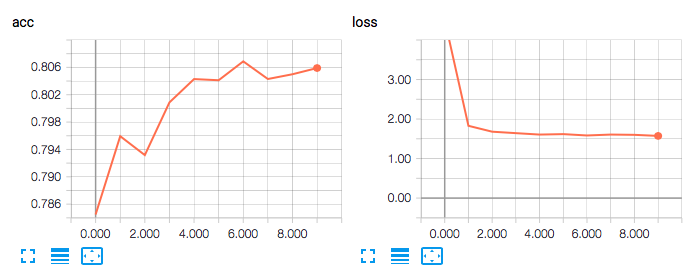

In [10]:
from IPython.display import Image
Image(filename='tensorboard.png')

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

In [364]:

MAX_LEN = 26
VOCAB_SIZE = 8000


BATCH_SIZE = 150 
NUM_LAYERS = 1
HIDDEN_DIM = 30
EPOCHS = 100

In [365]:
# TO-DO 
article_text_train2 =  open('data/train_article.txt', 'r')
summary_text_train2 =  open('data/train_title.txt', 'r')

articleTrain_data2=article_text_train2.read().splitlines()
summaryTrain_data2=summary_text_train2.read().splitlines()

training_article_data2 = load_data(articleTrain_data2,summaryTrain_data2,MAX_LEN,VOCAB_SIZE)

transformed_article_data_train2 = training_article_data2[0]
Vocab_size_of_article_train2 = training_article_data2[1]
word2idx_article_train2 = training_article_data2[2]
dx2word_articl_train2 = training_article_data2[3]
transformed_summary_data_train2 = training_article_data2[4]
Vocab_size_of_summary_train2 = training_article_data2[5]
word2idx_summary_train2 = training_article_data2[6]
idx2word_summary_train2 = training_article_data2[7]

# idx2word_summary_test2[6]  DON'T USE THIS ONE


You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [357]:
from attention_decoder import AttentionDecoder

def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):

    # TO-DO
    model = Sequential()
    # Add embedding layer
    model.add(Embedding(input_dim=X_vocab_len, output_dim=hidden_size,  input_length=MAX_LEN,mask_zero=True,trainable=True))
    # add LSTM encoder layer
    for _ in range (num_layers):
        model.add(LSTM(hidden_size,return_sequences=True, dropout=0.2,recurrent_dropout=0.2))    
    # Add attention decoder layer
    model.add(AttentionDecoder(hidden_size, X_vocab_len))
    # Add compile layer
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    # Add summary layer
    model.summary()
    return model


# Train the Model

Train the model, as you did before, for the model without attention

In [25]:
# TO-DO

sum_voc_len_attention2 = transformed_summary_data_train2.max()+1
art_voc_len_attention2 = transformed_article_data_train2.max()+1

model_with_attention=create_UniLSTMwithAttention(sum_voc_len_attention2,MAX_LEN,art_voc_len_attention2,MAX_LEN,HIDDEN_DIM,NUM_LAYERS)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 30)            240000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 26, 30)            7320      
_________________________________________________________________
AttentionDecoder (AttentionD (None, 26, 8000)          65216250  
Total params: 65,463,570
Trainable params: 65,463,570
Non-trainable params: 0
_________________________________________________________________


In [20]:

len_of_transformed_article_data_train = len(transformed_article_data_train2)

for p in range(1,EPOCHS+1):
    for item in range(0, len_of_transformed_article_data_train, 1000):
        if item + 1000 >= len_of_transformed_article_data_train:
            last_item = len_of_transformed_article_data_train
        else:
            last_item = item + 1000
        
        summary=transformed_summary_data_train2[item:last_item]
        
        summary_one_hot = (np.arange(transformed_summary_data_train2.max()+1) == summary[...,None]).astype(int)# One Hot 
        
        print('Medel is training: epoch {}th {}/{} samples'.format(p, item, len_of_transformed_article_data_train))
        model_with_attention.fit(transformed_article_data_train2[item:last_item], summary_one_hot, batch_size=BATCH_SIZE, nb_epoch=1,verbose=1,validation_split=0.2,shuffle = True)
    model_with_attention.save_weights('./with_attention_weights_folder2/checkpoint_epoch_{}.hdf5'.format(p))   



    

Medel is training: epoch 1th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 5.2105 - acc: 0.4537 - val_loss: 4.7461 - val_acc: 0.5051
Medel is training: epoch 1th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 4.5315 - acc: 0.5077 - val_loss: 4.1816 - val_acc: 0.5290
Medel is training: epoch 1th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 4.4339 - acc: 0.4801 - val_loss: 4.3093 - val_acc: 0.4784
Medel is training: epoch 1th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 4.0775 - acc: 0.5067 - val_loss: 4.0009 - val_acc: 0.5074
Medel is training: epoch 1th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==========================

800/800 [==============================] - 9s - loss: 3.4165 - acc: 0.5660 - val_loss: 3.4316 - val_acc: 0.5721
Medel is training: epoch 2th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.8066 - acc: 0.5301 - val_loss: 3.2575 - val_acc: 0.6030
Medel is training: epoch 2th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3452 - acc: 0.5873 - val_loss: 3.3581 - val_acc: 0.5862
Medel is training: epoch 2th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0626 - acc: 0.6001 - val_loss: 3.4057 - val_acc: 0.5762
Medel is training: epoch 2th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.7912 - acc: 0.5297 - val_loss: 3.5315 - val_acc: 0.5688
Medel is training: e

800/800 [==============================] - 9s - loss: 3.7988 - acc: 0.5238 - val_loss: 4.5109 - val_acc: 0.4434
Medel is training: epoch 3th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4613 - acc: 0.5687 - val_loss: 3.5234 - val_acc: 0.5555
Medel is training: epoch 3th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3889 - acc: 0.5672 - val_loss: 3.2901 - val_acc: 0.5695
Medel is training: epoch 3th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.6985 - acc: 0.5360 - val_loss: 3.8900 - val_acc: 0.5190
Medel is training: epoch 3th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4314 - acc: 0.5753 - val_loss: 3.5714 - val_acc: 0.5494
Medel is training: e

800/800 [==============================] - 9s - loss: 3.5835 - acc: 0.5508 - val_loss: 3.2759 - val_acc: 0.5610
Medel is training: epoch 4th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.7412 - acc: 0.5173 - val_loss: 3.8430 - val_acc: 0.5206
Medel is training: epoch 4th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5771 - acc: 0.5521 - val_loss: 3.5403 - val_acc: 0.5572
Medel is training: epoch 4th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4301 - acc: 0.5589 - val_loss: 3.7315 - val_acc: 0.5335
Medel is training: epoch 4th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.9752 - acc: 0.4987 - val_loss: 3.2869 - val_acc: 0.5904
Medel is training: epoch

800/800 [==============================] - 9s - loss: 2.6853 - acc: 0.6328 - val_loss: 3.2099 - val_acc: 0.5863
Medel is training: epoch 4th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5271 - acc: 0.5573 - val_loss: 3.9091 - val_acc: 0.5078
Medel is training: epoch 4th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1955 - acc: 0.6004 - val_loss: 2.9860 - val_acc: 0.6278
Medel is training: epoch 4th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2497 - acc: 0.5913 - val_loss: 2.7830 - val_acc: 0.6305
Medel is training: epoch 4th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6182 - acc: 0.6441 - val_loss: 3.2468 - val_acc: 0.5762
Medel is training: e

800/800 [==============================] - 9s - loss: 3.2874 - acc: 0.5883 - val_loss: 3.3208 - val_acc: 0.5844
Medel is training: epoch 5th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7598 - acc: 0.6256 - val_loss: 3.3178 - val_acc: 0.5765
Medel is training: epoch 5th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.6871 - acc: 0.5340 - val_loss: 3.4531 - val_acc: 0.5685
Medel is training: epoch 5th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2944 - acc: 0.5836 - val_loss: 3.1082 - val_acc: 0.6095
Medel is training: epoch 5th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9208 - acc: 0.6214 - val_loss: 2.6546 - val_acc: 0.6380
Medel is training: e

800/800 [==============================] - 9s - loss: 3.2418 - acc: 0.5738 - val_loss: 3.0627 - val_acc: 0.5757
Medel is training: epoch 6th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5921 - acc: 0.5378 - val_loss: 3.7986 - val_acc: 0.5207
Medel is training: epoch 6th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3745 - acc: 0.5763 - val_loss: 3.5493 - val_acc: 0.5500
Medel is training: epoch 6th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1706 - acc: 0.5827 - val_loss: 2.9956 - val_acc: 0.5816
Medel is training: epoch 6th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5996 - acc: 0.5387 - val_loss: 4.0413 - val_acc: 0.4877
Medel is training: e

800/800 [==============================] - 9s - loss: 3.5179 - acc: 0.5536 - val_loss: 3.5222 - val_acc: 0.5558
Medel is training: epoch 7th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3364 - acc: 0.5600 - val_loss: 3.6635 - val_acc: 0.5373
Medel is training: epoch 7th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.8956 - acc: 0.5009 - val_loss: 3.2669 - val_acc: 0.5930
Medel is training: epoch 7th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5463 - acc: 0.5474 - val_loss: 3.5764 - val_acc: 0.5516
Medel is training: epoch 7th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2962 - acc: 0.5565 - val_loss: 3.7147 - val_acc: 0.5303
Medel is training: epoch

800/800 [==============================] - 9s - loss: 3.1557 - acc: 0.6006 - val_loss: 2.9702 - val_acc: 0.6290
Medel is training: epoch 7th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2204 - acc: 0.5922 - val_loss: 2.7295 - val_acc: 0.6283
Medel is training: epoch 7th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5286 - acc: 0.6455 - val_loss: 3.1805 - val_acc: 0.5756
Medel is training: epoch 7th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3772 - acc: 0.5648 - val_loss: 4.0592 - val_acc: 0.5048
Medel is training: epoch 7th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1787 - acc: 0.5950 - val_loss: 3.1768 - val_acc: 0.6023
Medel is training: e

800/800 [==============================] - 9s - loss: 3.6343 - acc: 0.5356 - val_loss: 3.4379 - val_acc: 0.5676
Medel is training: epoch 8th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2658 - acc: 0.5836 - val_loss: 3.1079 - val_acc: 0.6095
Medel is training: epoch 8th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8674 - acc: 0.6221 - val_loss: 2.5812 - val_acc: 0.6438
Medel is training: epoch 8th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0971 - acc: 0.5829 - val_loss: 3.4046 - val_acc: 0.5707
Medel is training: epoch 8th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.6270 - acc: 0.5362 - val_loss: 3.0668 - val_acc: 0.6180
Medel is training: e

800/800 [==============================] - 9s - loss: 3.3470 - acc: 0.5754 - val_loss: 3.5568 - val_acc: 0.5497
Medel is training: epoch 9th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1167 - acc: 0.5885 - val_loss: 2.9301 - val_acc: 0.5871
Medel is training: epoch 9th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5571 - acc: 0.5409 - val_loss: 4.0301 - val_acc: 0.4893
Medel is training: epoch 9th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3112 - acc: 0.5828 - val_loss: 3.3038 - val_acc: 0.5856
Medel is training: epoch 9th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1133 - acc: 0.5936 - val_loss: 2.8170 - val_acc: 0.6068
Medel is training: e

800/800 [==============================] - 9s - loss: 3.8459 - acc: 0.5036 - val_loss: 3.2897 - val_acc: 0.5854
Medel is training: epoch 10th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5220 - acc: 0.5480 - val_loss: 3.5768 - val_acc: 0.5509
Medel is training: epoch 10th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2216 - acc: 0.5584 - val_loss: 3.7073 - val_acc: 0.5299
Medel is training: epoch 10th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.7697 - acc: 0.5141 - val_loss: 3.3753 - val_acc: 0.5726
Medel is training: epoch 10th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4219 - acc: 0.5572 - val_loss: 2.8348 - val_acc: 0.5960
Medel is training: e

800/800 [==============================] - 9s - loss: 2.4417 - acc: 0.6522 - val_loss: 3.1283 - val_acc: 0.5852
Medel is training: epoch 10th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3390 - acc: 0.5659 - val_loss: 4.0466 - val_acc: 0.5075
Medel is training: epoch 10th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1488 - acc: 0.5953 - val_loss: 3.1776 - val_acc: 0.6012
Medel is training: epoch 10th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1062 - acc: 0.6032 - val_loss: 2.2726 - val_acc: 0.6618
Medel is training: epoch 10th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4872 - acc: 0.6459 - val_loss: 3.0662 - val_acc: 0.5940
Medel is trainin

800/800 [==============================] - 10s - loss: 2.8128 - acc: 0.6271 - val_loss: 2.5053 - val_acc: 0.6519
Medel is training: epoch 11th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0243 - acc: 0.5895 - val_loss: 3.3752 - val_acc: 0.5722
Medel is training: epoch 11th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5783 - acc: 0.5375 - val_loss: 3.0607 - val_acc: 0.6171
Medel is training: epoch 11th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1748 - acc: 0.5950 - val_loss: 3.2568 - val_acc: 0.5868
Medel is training: epoch 11th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5152 - acc: 0.6458 - val_loss: 2.6390 - val_acc: 0.6115
Medel is traini

800/800 [==============================] - 9s - loss: 3.4992 - acc: 0.5426 - val_loss: 4.0046 - val_acc: 0.4900
Medel is training: epoch 12th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2785 - acc: 0.5824 - val_loss: 3.2923 - val_acc: 0.5853
Medel is training: epoch 12th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0630 - acc: 0.5950 - val_loss: 2.7182 - val_acc: 0.6141
Medel is training: epoch 12th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3613 - acc: 0.5529 - val_loss: 3.7809 - val_acc: 0.5237
Medel is training: epoch 12th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4188 - acc: 0.5623 - val_loss: 3.2842 - val_acc: 0.5863
Medel is trainin

800/800 [==============================] - 9s - loss: 3.1315 - acc: 0.5679 - val_loss: 3.6557 - val_acc: 0.5327
Medel is training: epoch 13th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.7105 - acc: 0.5152 - val_loss: 3.3636 - val_acc: 0.5723
Medel is training: epoch 13th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3863 - acc: 0.5589 - val_loss: 2.6813 - val_acc: 0.6140
Medel is training: epoch 13th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3163 - acc: 0.5577 - val_loss: 4.0946 - val_acc: 0.4802
Medel is training: epoch 13th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5318 - acc: 0.5459 - val_loss: 3.4833 - val_acc: 0.5582
Medel is training:

800/800 [==============================] - 9s - loss: 3.1086 - acc: 0.5968 - val_loss: 3.1636 - val_acc: 0.6032
Medel is training: epoch 13th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0834 - acc: 0.6033 - val_loss: 2.2154 - val_acc: 0.6686
Medel is training: epoch 13th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4058 - acc: 0.6513 - val_loss: 3.0180 - val_acc: 0.5931
Medel is training: epoch 13th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2755 - acc: 0.5687 - val_loss: 3.7136 - val_acc: 0.5250
Medel is training: epoch 13th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1928 - acc: 0.5853 - val_loss: 3.2401 - val_acc: 0.5962
Medel is trainin

800/800 [==============================] - 9s - loss: 3.5212 - acc: 0.5398 - val_loss: 3.0610 - val_acc: 0.6154
Medel is training: epoch 14th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1488 - acc: 0.5951 - val_loss: 3.2478 - val_acc: 0.5871
Medel is training: epoch 14th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4321 - acc: 0.6531 - val_loss: 2.5638 - val_acc: 0.6150
Medel is training: epoch 14th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1878 - acc: 0.5757 - val_loss: 3.7886 - val_acc: 0.5166
Medel is training: epoch 14th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2336 - acc: 0.5798 - val_loss: 3.1722 - val_acc: 0.6003
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0144 - acc: 0.5989 - val_loss: 2.6237 - val_acc: 0.6241
Medel is training: epoch 15th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2929 - acc: 0.5559 - val_loss: 3.7319 - val_acc: 0.5256
Medel is training: epoch 15th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3787 - acc: 0.5625 - val_loss: 3.2795 - val_acc: 0.5848
Medel is training: epoch 15th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1740 - acc: 0.5865 - val_loss: 2.3490 - val_acc: 0.6596
Medel is training: epoch 15th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9672 - acc: 0.5902 - val_loss: 3.2220 - val_acc: 0.5792
Medel is trainin

800/800 [==============================] - 9s - loss: 3.3494 - acc: 0.5605 - val_loss: 2.5673 - val_acc: 0.6193
Medel is training: epoch 16th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2473 - acc: 0.5597 - val_loss: 4.0719 - val_acc: 0.4795
Medel is training: epoch 16th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4894 - acc: 0.5467 - val_loss: 3.4613 - val_acc: 0.5601
Medel is training: epoch 16th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1735 - acc: 0.5792 - val_loss: 2.7208 - val_acc: 0.6039
Medel is training: epoch 16th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5116 - acc: 0.5309 - val_loss: 4.3240 - val_acc: 0.4491
Medel is trainin

800/800 [==============================] - 9s - loss: 2.3340 - acc: 0.6555 - val_loss: 2.9657 - val_acc: 0.5968
Medel is training: epoch 16th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2076 - acc: 0.5695 - val_loss: 3.6656 - val_acc: 0.5266
Medel is training: epoch 16th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1455 - acc: 0.5873 - val_loss: 3.2360 - val_acc: 0.5950
Medel is training: epoch 17th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.7801 - acc: 0.5014 - val_loss: 3.6598 - val_acc: 0.5320
Medel is training: epoch 17th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4390 - acc: 0.5525 - val_loss: 2.7307 - val_acc: 0.5914
Medel is training: ep

800/800 [==============================] - 9s - loss: 2.3650 - acc: 0.6565 - val_loss: 2.4965 - val_acc: 0.6223
Medel is training: epoch 17th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1299 - acc: 0.5777 - val_loss: 3.7338 - val_acc: 0.5144
Medel is training: epoch 17th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1822 - acc: 0.5822 - val_loss: 3.1562 - val_acc: 0.6017
Medel is training: epoch 17th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0464 - acc: 0.6056 - val_loss: 2.4825 - val_acc: 0.6541
Medel is training: epoch 17th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3039 - acc: 0.6560 - val_loss: 2.9835 - val_acc: 0.5966
Medel is trainin

800/800 [==============================] - 9s - loss: 3.3331 - acc: 0.5641 - val_loss: 3.2698 - val_acc: 0.5854
Medel is training: epoch 18th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1366 - acc: 0.5863 - val_loss: 2.2850 - val_acc: 0.6632
Medel is training: epoch 18th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8952 - acc: 0.5910 - val_loss: 3.1836 - val_acc: 0.5824
Medel is training: epoch 18th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4697 - acc: 0.5381 - val_loss: 3.2337 - val_acc: 0.5936
Medel is training: epoch 18th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1626 - acc: 0.5894 - val_loss: 3.2800 - val_acc: 0.5832
Medel is trainin

800/800 [==============================] - 9s - loss: 3.4433 - acc: 0.5468 - val_loss: 3.4469 - val_acc: 0.5585
Medel is training: epoch 19th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1284 - acc: 0.5783 - val_loss: 2.6624 - val_acc: 0.6060
Medel is training: epoch 19th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4405 - acc: 0.5326 - val_loss: 4.2828 - val_acc: 0.4485
Medel is training: epoch 19th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2580 - acc: 0.5720 - val_loss: 3.4882 - val_acc: 0.5546
Medel is training: epoch 19th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9712 - acc: 0.5899 - val_loss: 2.7102 - val_acc: 0.6085
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0921 - acc: 0.5883 - val_loss: 3.2414 - val_acc: 0.5962
Medel is training: epoch 20th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.7172 - acc: 0.5038 - val_loss: 3.6429 - val_acc: 0.5323
Medel is training: epoch 20th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3996 - acc: 0.5531 - val_loss: 2.6558 - val_acc: 0.5888
Medel is training: epoch 20th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3014 - acc: 0.5297 - val_loss: 3.6629 - val_acc: 0.5223
Medel is training: epoch 20th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3680 - acc: 0.5554 - val_loss: 3.4881 - val_acc: 0.5539
Medel is training: epoc

800/800 [==============================] - 9s - loss: 3.1309 - acc: 0.5828 - val_loss: 3.1458 - val_acc: 0.6014
Medel is training: epoch 20th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0131 - acc: 0.6062 - val_loss: 2.4494 - val_acc: 0.6548
Medel is training: epoch 20th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2364 - acc: 0.6612 - val_loss: 2.9368 - val_acc: 0.6000
Medel is training: epoch 20th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2094 - acc: 0.5655 - val_loss: 3.7350 - val_acc: 0.5155
Medel is training: epoch 20th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9798 - acc: 0.6029 - val_loss: 2.9399 - val_acc: 0.6275
Medel is trainin

800/800 [==============================] - 9s - loss: 2.2819 - acc: 0.6600 - val_loss: 2.4169 - val_acc: 0.6425
Medel is training: epoch 21th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0451 - acc: 0.5796 - val_loss: 3.7095 - val_acc: 0.5157
Medel is training: epoch 21th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1118 - acc: 0.5824 - val_loss: 3.1431 - val_acc: 0.5997
Medel is training: epoch 21th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0119 - acc: 0.6055 - val_loss: 2.4444 - val_acc: 0.6532
Medel is training: epoch 21th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2164 - acc: 0.6610 - val_loss: 2.9278 - val_acc: 0.6000
Medel is trainin

800/800 [==============================] - 9s - loss: 3.2638 - acc: 0.5648 - val_loss: 3.2544 - val_acc: 0.5848
Medel is training: epoch 22th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0869 - acc: 0.5878 - val_loss: 2.1965 - val_acc: 0.6689
Medel is training: epoch 22th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8046 - acc: 0.5966 - val_loss: 3.1354 - val_acc: 0.5818
Medel is training: epoch 22th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3838 - acc: 0.5399 - val_loss: 3.2345 - val_acc: 0.5909
Medel is training: epoch 22th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1091 - acc: 0.5903 - val_loss: 3.2707 - val_acc: 0.5832
Medel is trainin

800/800 [==============================] - 9s - loss: 3.3728 - acc: 0.5478 - val_loss: 3.4356 - val_acc: 0.5565
Medel is training: epoch 23th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0618 - acc: 0.5835 - val_loss: 2.5758 - val_acc: 0.6116
Medel is training: epoch 23th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3510 - acc: 0.5360 - val_loss: 4.2252 - val_acc: 0.4464
Medel is training: epoch 23th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2041 - acc: 0.5731 - val_loss: 3.4910 - val_acc: 0.5527
Medel is training: epoch 23th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8985 - acc: 0.5936 - val_loss: 2.6385 - val_acc: 0.6119
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0218 - acc: 0.5891 - val_loss: 3.2407 - val_acc: 0.5968
Medel is training: epoch 24th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.6290 - acc: 0.5050 - val_loss: 3.6340 - val_acc: 0.5280
Medel is training: epoch 24th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3427 - acc: 0.5528 - val_loss: 2.5505 - val_acc: 0.5994
Medel is training: epoch 24th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2019 - acc: 0.5342 - val_loss: 3.6319 - val_acc: 0.5205
Medel is training: epoch 24th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3088 - acc: 0.5551 - val_loss: 3.4874 - val_acc: 0.5546
Medel is training: epoc

800/800 [==============================] - 9s - loss: 3.0613 - acc: 0.5843 - val_loss: 3.1401 - val_acc: 0.6006
Medel is training: epoch 24th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9726 - acc: 0.6064 - val_loss: 2.4123 - val_acc: 0.6648
Medel is training: epoch 24th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.1502 - acc: 0.6670 - val_loss: 2.8922 - val_acc: 0.6044
Medel is training: epoch 24th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1390 - acc: 0.5672 - val_loss: 3.6990 - val_acc: 0.5149
Medel is training: epoch 24th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9164 - acc: 0.6058 - val_loss: 2.9388 - val_acc: 0.6267
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7402 - acc: 0.6001 - val_loss: 3.1032 - val_acc: 0.5843
Medel is training: epoch 25th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3216 - acc: 0.5422 - val_loss: 3.2391 - val_acc: 0.5900
Medel is training: epoch 25th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0836 - acc: 0.5900 - val_loss: 3.2717 - val_acc: 0.5838
Medel is training: epoch 25th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2201 - acc: 0.6603 - val_loss: 3.0691 - val_acc: 0.5905
Medel is training: epoch 25th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2757 - acc: 0.5465 - val_loss: 3.3245 - val_acc: 0.5670
Medel is trainin

800/800 [==============================] - 9s - loss: 3.2834 - acc: 0.5369 - val_loss: 4.2137 - val_acc: 0.4481
Medel is training: epoch 26th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1675 - acc: 0.5745 - val_loss: 3.4819 - val_acc: 0.5524
Medel is training: epoch 26th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8466 - acc: 0.5968 - val_loss: 2.5822 - val_acc: 0.6168
Medel is training: epoch 26th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1895 - acc: 0.5493 - val_loss: 3.6196 - val_acc: 0.5214
Medel is training: epoch 26th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1336 - acc: 0.5764 - val_loss: 3.5397 - val_acc: 0.5463
Medel is trainin

800/800 [==============================] - 9s - loss: 3.3026 - acc: 0.5546 - val_loss: 2.4782 - val_acc: 0.6086
Medel is training: epoch 27th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1316 - acc: 0.5400 - val_loss: 3.6138 - val_acc: 0.5209
Medel is training: epoch 27th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2706 - acc: 0.5569 - val_loss: 3.4853 - val_acc: 0.5529
Medel is training: epoch 27th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8667 - acc: 0.5878 - val_loss: 3.4232 - val_acc: 0.5445
Medel is training: epoch 27th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.5055 - acc: 0.5086 - val_loss: 3.2738 - val_acc: 0.5814
Medel is training: e

800/800 [==============================] - 9s - loss: 2.0945 - acc: 0.6704 - val_loss: 2.8580 - val_acc: 0.6090
Medel is training: epoch 27th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0767 - acc: 0.5689 - val_loss: 3.6652 - val_acc: 0.5180
Medel is training: epoch 27th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8749 - acc: 0.6058 - val_loss: 2.9340 - val_acc: 0.6287
Medel is training: epoch 27th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0349 - acc: 0.5952 - val_loss: 2.4959 - val_acc: 0.6485
Medel is training: epoch 27th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0460 - acc: 0.6763 - val_loss: 2.8583 - val_acc: 0.5986
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0476 - acc: 0.5904 - val_loss: 3.2838 - val_acc: 0.5817
Medel is training: epoch 28th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.1652 - acc: 0.6648 - val_loss: 3.0449 - val_acc: 0.5918
Medel is training: epoch 28th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2150 - acc: 0.5484 - val_loss: 3.3135 - val_acc: 0.5654
Medel is training: epoch 28th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0177 - acc: 0.5867 - val_loss: 3.0586 - val_acc: 0.6071
Medel is training: epoch 28th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5490 - acc: 0.6391 - val_loss: 2.1646 - val_acc: 0.6765
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7976 - acc: 0.5978 - val_loss: 2.5404 - val_acc: 0.6240
Medel is training: epoch 29th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1284 - acc: 0.5527 - val_loss: 3.5984 - val_acc: 0.5197
Medel is training: epoch 29th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1012 - acc: 0.5780 - val_loss: 3.5444 - val_acc: 0.5459
Medel is training: epoch 29th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7597 - acc: 0.6053 - val_loss: 2.4854 - val_acc: 0.6186
Medel is training: epoch 29th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1385 - acc: 0.5531 - val_loss: 3.8306 - val_acc: 0.4900
Medel is trainin

800/800 [==============================] - 9s - loss: 3.2316 - acc: 0.5583 - val_loss: 3.4885 - val_acc: 0.5525
Medel is training: epoch 30th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8130 - acc: 0.5905 - val_loss: 3.3845 - val_acc: 0.5472
Medel is training: epoch 30th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.4423 - acc: 0.5095 - val_loss: 3.2701 - val_acc: 0.5794
Medel is training: epoch 30th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2820 - acc: 0.5507 - val_loss: 3.5144 - val_acc: 0.5519
Medel is training: epoch 30th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7048 - acc: 0.5908 - val_loss: 3.4501 - val_acc: 0.5351
Medel is training: e

800/800 [==============================] - 9s - loss: 2.8368 - acc: 0.6065 - val_loss: 2.9489 - val_acc: 0.6264
Medel is training: epoch 30th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0055 - acc: 0.5951 - val_loss: 2.4800 - val_acc: 0.6491
Medel is training: epoch 30th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9851 - acc: 0.6805 - val_loss: 2.8283 - val_acc: 0.5983
Medel is training: epoch 30th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9413 - acc: 0.5771 - val_loss: 3.8820 - val_acc: 0.5078
Medel is training: epoch 30th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8659 - acc: 0.6009 - val_loss: 3.1172 - val_acc: 0.5992
Medel is trainin

800/800 [==============================] - 9s - loss: 3.1638 - acc: 0.5505 - val_loss: 3.2985 - val_acc: 0.5660
Medel is training: epoch 31th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9767 - acc: 0.5890 - val_loss: 3.0581 - val_acc: 0.6053
Medel is training: epoch 31th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5102 - acc: 0.6417 - val_loss: 2.1302 - val_acc: 0.6791
Medel is training: epoch 31th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5924 - acc: 0.6097 - val_loss: 3.1199 - val_acc: 0.5794
Medel is training: epoch 31th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1668 - acc: 0.5458 - val_loss: 3.0705 - val_acc: 0.6080
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0522 - acc: 0.5791 - val_loss: 3.5379 - val_acc: 0.5466
Medel is training: epoch 32th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7172 - acc: 0.6073 - val_loss: 2.4399 - val_acc: 0.6224
Medel is training: epoch 32th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0815 - acc: 0.5545 - val_loss: 3.7996 - val_acc: 0.4916
Medel is training: epoch 32th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0024 - acc: 0.5877 - val_loss: 3.2632 - val_acc: 0.5797
Medel is training: epoch 32th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7836 - acc: 0.6084 - val_loss: 2.2947 - val_acc: 0.6442
Medel is trainin

800/800 [==============================] - 9s - loss: 3.3899 - acc: 0.5112 - val_loss: 3.2576 - val_acc: 0.5804
Medel is training: epoch 33th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2479 - acc: 0.5530 - val_loss: 3.5180 - val_acc: 0.5516
Medel is training: epoch 33th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6473 - acc: 0.5916 - val_loss: 3.4242 - val_acc: 0.5364
Medel is training: epoch 33th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3333 - acc: 0.5230 - val_loss: 3.3330 - val_acc: 0.5720
Medel is training: epoch 33th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1348 - acc: 0.5649 - val_loss: 2.2362 - val_acc: 0.6508
Medel is training: e

800/800 [==============================] - 9s - loss: 1.9483 - acc: 0.6836 - val_loss: 2.8022 - val_acc: 0.6020
Medel is training: epoch 33th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8908 - acc: 0.5794 - val_loss: 3.8613 - val_acc: 0.5093
Medel is training: epoch 33th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8235 - acc: 0.6043 - val_loss: 3.1099 - val_acc: 0.6012
Medel is training: epoch 33th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8835 - acc: 0.6058 - val_loss: 1.9385 - val_acc: 0.6888
Medel is training: epoch 33th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9958 - acc: 0.6844 - val_loss: 2.7123 - val_acc: 0.6103
Medel is trainin

800/800 [==============================] - 9s - loss: 2.4752 - acc: 0.6412 - val_loss: 2.0951 - val_acc: 0.6814
Medel is training: epoch 34th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5375 - acc: 0.6132 - val_loss: 3.1075 - val_acc: 0.5797
Medel is training: epoch 34th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1126 - acc: 0.5484 - val_loss: 3.0836 - val_acc: 0.6024
Medel is training: epoch 34th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9345 - acc: 0.5974 - val_loss: 3.2194 - val_acc: 0.5839
Medel is training: epoch 34th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0467 - acc: 0.6794 - val_loss: 2.2341 - val_acc: 0.6527
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0357 - acc: 0.5545 - val_loss: 3.7854 - val_acc: 0.4893
Medel is training: epoch 35th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9570 - acc: 0.5880 - val_loss: 3.2565 - val_acc: 0.5803
Medel is training: epoch 35th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7470 - acc: 0.6096 - val_loss: 2.2559 - val_acc: 0.6472
Medel is training: epoch 35th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8578 - acc: 0.5717 - val_loss: 3.5265 - val_acc: 0.5308
Medel is training: epoch 35th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0691 - acc: 0.5682 - val_loss: 3.2521 - val_acc: 0.5824
Medel is trainin

800/800 [==============================] - 9s - loss: 2.5921 - acc: 0.5961 - val_loss: 3.4130 - val_acc: 0.5351
Medel is training: epoch 36th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2803 - acc: 0.5235 - val_loss: 3.3357 - val_acc: 0.5707
Medel is training: epoch 36th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1033 - acc: 0.5663 - val_loss: 2.2165 - val_acc: 0.6518
Medel is training: epoch 36th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8274 - acc: 0.5744 - val_loss: 3.8509 - val_acc: 0.4903
Medel is training: epoch 36th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1806 - acc: 0.5524 - val_loss: 3.4326 - val_acc: 0.5529
Medel is training:

800/800 [==============================] - 9s - loss: 2.7933 - acc: 0.6051 - val_loss: 3.1129 - val_acc: 0.6018
Medel is training: epoch 36th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8575 - acc: 0.6057 - val_loss: 1.9188 - val_acc: 0.6876
Medel is training: epoch 36th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9634 - acc: 0.6815 - val_loss: 2.6975 - val_acc: 0.6100
Medel is training: epoch 36th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8384 - acc: 0.5811 - val_loss: 3.4696 - val_acc: 0.5329
Medel is training: epoch 36th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8331 - acc: 0.5932 - val_loss: 3.2611 - val_acc: 0.5925
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0741 - acc: 0.5495 - val_loss: 3.0846 - val_acc: 0.6024
Medel is training: epoch 37th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8998 - acc: 0.5995 - val_loss: 3.2121 - val_acc: 0.5836
Medel is training: epoch 37th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0010 - acc: 0.6818 - val_loss: 2.2032 - val_acc: 0.6569
Medel is training: epoch 37th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7555 - acc: 0.5884 - val_loss: 3.6093 - val_acc: 0.5225
Medel is training: epoch 37th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8767 - acc: 0.5868 - val_loss: 3.1551 - val_acc: 0.5967
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7147 - acc: 0.6102 - val_loss: 2.2261 - val_acc: 0.6556
Medel is training: epoch 38th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8172 - acc: 0.5736 - val_loss: 3.5118 - val_acc: 0.5298
Medel is training: epoch 38th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0345 - acc: 0.5686 - val_loss: 3.2544 - val_acc: 0.5821
Medel is training: epoch 38th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9060 - acc: 0.5918 - val_loss: 2.0055 - val_acc: 0.6845
Medel is training: epoch 38th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5095 - acc: 0.6094 - val_loss: 2.9980 - val_acc: 0.5831
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0693 - acc: 0.5661 - val_loss: 2.1971 - val_acc: 0.6543
Medel is training: epoch 39th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7795 - acc: 0.5761 - val_loss: 3.8217 - val_acc: 0.4913
Medel is training: epoch 39th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1414 - acc: 0.5527 - val_loss: 3.4365 - val_acc: 0.5510
Medel is training: epoch 39th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8534 - acc: 0.5889 - val_loss: 2.3506 - val_acc: 0.6350
Medel is training: epoch 39th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0346 - acc: 0.5468 - val_loss: 4.1435 - val_acc: 0.4549
Medel is trainin

800/800 [==============================] - 9s - loss: 1.9246 - acc: 0.6842 - val_loss: 2.6766 - val_acc: 0.6115
Medel is training: epoch 39th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7997 - acc: 0.5805 - val_loss: 3.4515 - val_acc: 0.5340
Medel is training: epoch 39th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7972 - acc: 0.5939 - val_loss: 3.2665 - val_acc: 0.5911
Medel is training: epoch 40th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.3441 - acc: 0.5128 - val_loss: 3.6341 - val_acc: 0.5307
Medel is training: epoch 40th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1557 - acc: 0.5583 - val_loss: 2.2729 - val_acc: 0.6288
Medel is training: ep

800/800 [==============================] - 9s - loss: 1.9750 - acc: 0.6787 - val_loss: 2.1751 - val_acc: 0.6607
Medel is training: epoch 40th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7233 - acc: 0.5898 - val_loss: 3.5972 - val_acc: 0.5218
Medel is training: epoch 40th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8327 - acc: 0.5897 - val_loss: 3.1538 - val_acc: 0.5979
Medel is training: epoch 40th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8210 - acc: 0.6075 - val_loss: 2.3630 - val_acc: 0.6645
Medel is training: epoch 40th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9090 - acc: 0.6800 - val_loss: 2.7480 - val_acc: 0.6162
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0113 - acc: 0.5527 - val_loss: 3.0871 - val_acc: 0.6006
Medel is training: epoch 41th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8652 - acc: 0.5989 - val_loss: 3.2096 - val_acc: 0.5833
Medel is training: epoch 41th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9520 - acc: 0.6841 - val_loss: 2.1756 - val_acc: 0.6591
Medel is training: epoch 41th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7119 - acc: 0.5899 - val_loss: 3.5952 - val_acc: 0.5228
Medel is training: epoch 41th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8206 - acc: 0.5885 - val_loss: 3.1546 - val_acc: 0.5964
Medel is trainin

800/800 [==============================] - 9s - loss: 2.6719 - acc: 0.6117 - val_loss: 2.1935 - val_acc: 0.6556
Medel is training: epoch 42th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7602 - acc: 0.5740 - val_loss: 3.5059 - val_acc: 0.5285
Medel is training: epoch 42th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9810 - acc: 0.5696 - val_loss: 3.2670 - val_acc: 0.5805
Medel is training: epoch 42th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8648 - acc: 0.5939 - val_loss: 1.9764 - val_acc: 0.6859
Medel is training: epoch 42th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4589 - acc: 0.6110 - val_loss: 2.9825 - val_acc: 0.5821
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0360 - acc: 0.5672 - val_loss: 2.1724 - val_acc: 0.6550
Medel is training: epoch 43th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7220 - acc: 0.5790 - val_loss: 3.7934 - val_acc: 0.4916
Medel is training: epoch 43th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0947 - acc: 0.5537 - val_loss: 3.4445 - val_acc: 0.5480
Medel is training: epoch 43th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8115 - acc: 0.5908 - val_loss: 2.3217 - val_acc: 0.6340
Medel is training: epoch 43th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9779 - acc: 0.5492 - val_loss: 4.1332 - val_acc: 0.4552
Medel is trainin

800/800 [==============================] - 9s - loss: 1.8810 - acc: 0.6875 - val_loss: 2.6544 - val_acc: 0.6127
Medel is training: epoch 43th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7350 - acc: 0.5839 - val_loss: 3.4352 - val_acc: 0.5325
Medel is training: epoch 43th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7546 - acc: 0.5937 - val_loss: 3.2791 - val_acc: 0.5908
Medel is training: epoch 44th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2841 - acc: 0.5134 - val_loss: 3.6444 - val_acc: 0.5290
Medel is training: epoch 44th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1178 - acc: 0.5603 - val_loss: 2.2435 - val_acc: 0.6310
Medel is training: ep

800/800 [==============================] - 9s - loss: 1.9296 - acc: 0.6852 - val_loss: 2.1569 - val_acc: 0.6604
Medel is training: epoch 44th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6735 - acc: 0.5896 - val_loss: 3.5885 - val_acc: 0.5228
Medel is training: epoch 44th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7940 - acc: 0.5899 - val_loss: 3.1579 - val_acc: 0.5973
Medel is training: epoch 44th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7899 - acc: 0.6081 - val_loss: 2.3454 - val_acc: 0.6697
Medel is training: epoch 44th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8646 - acc: 0.6842 - val_loss: 2.7283 - val_acc: 0.6152
Medel is trainin

800/800 [==============================] - 9s - loss: 2.9538 - acc: 0.5705 - val_loss: 3.2770 - val_acc: 0.5793
Medel is training: epoch 45th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8434 - acc: 0.5940 - val_loss: 1.9531 - val_acc: 0.6909
Medel is training: epoch 45th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4168 - acc: 0.6150 - val_loss: 2.9758 - val_acc: 0.5831
Medel is training: epoch 45th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0015 - acc: 0.5486 - val_loss: 3.2542 - val_acc: 0.5785
Medel is training: epoch 45th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8935 - acc: 0.5938 - val_loss: 3.3241 - val_acc: 0.5729
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0545 - acc: 0.5541 - val_loss: 3.4601 - val_acc: 0.5490
Medel is training: epoch 46th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7766 - acc: 0.5911 - val_loss: 2.3033 - val_acc: 0.6385
Medel is training: epoch 46th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9409 - acc: 0.5508 - val_loss: 4.1109 - val_acc: 0.4525
Medel is training: epoch 46th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9423 - acc: 0.5775 - val_loss: 3.5025 - val_acc: 0.5562
Medel is training: epoch 46th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5893 - acc: 0.6069 - val_loss: 2.4148 - val_acc: 0.6358
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7323 - acc: 0.5939 - val_loss: 3.2842 - val_acc: 0.5894
Medel is training: epoch 47th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.2441 - acc: 0.5150 - val_loss: 3.6421 - val_acc: 0.5287
Medel is training: epoch 47th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0827 - acc: 0.5618 - val_loss: 2.2021 - val_acc: 0.6369
Medel is training: epoch 47th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7649 - acc: 0.5602 - val_loss: 3.5376 - val_acc: 0.5199
Medel is training: epoch 47th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0362 - acc: 0.5628 - val_loss: 3.5445 - val_acc: 0.5476
Medel is training: epoc

800/800 [==============================] - 9s - loss: 2.7613 - acc: 0.5905 - val_loss: 3.1622 - val_acc: 0.5982
Medel is training: epoch 47th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7633 - acc: 0.6091 - val_loss: 2.3363 - val_acc: 0.6682
Medel is training: epoch 47th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8332 - acc: 0.6860 - val_loss: 2.7043 - val_acc: 0.6174
Medel is training: epoch 47th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7631 - acc: 0.5766 - val_loss: 3.5592 - val_acc: 0.5168
Medel is training: epoch 47th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6515 - acc: 0.6098 - val_loss: 2.9898 - val_acc: 0.6244
Medel is trainin

800/800 [==============================] - 9s - loss: 2.3813 - acc: 0.6161 - val_loss: 2.9677 - val_acc: 0.5840
Medel is training: epoch 48th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9659 - acc: 0.5503 - val_loss: 3.2470 - val_acc: 0.5788
Medel is training: epoch 48th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8699 - acc: 0.5947 - val_loss: 3.3309 - val_acc: 0.5720
Medel is training: epoch 48th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8964 - acc: 0.6826 - val_loss: 2.9090 - val_acc: 0.5962
Medel is training: epoch 48th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9050 - acc: 0.5557 - val_loss: 3.2832 - val_acc: 0.5688
Medel is trainin

800/800 [==============================] - 9s - loss: 2.9028 - acc: 0.5519 - val_loss: 4.0981 - val_acc: 0.4529
Medel is training: epoch 49th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9032 - acc: 0.5782 - val_loss: 3.5197 - val_acc: 0.5543
Medel is training: epoch 49th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5593 - acc: 0.6087 - val_loss: 2.4083 - val_acc: 0.6333
Medel is training: epoch 49th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8308 - acc: 0.5605 - val_loss: 3.5065 - val_acc: 0.5178
Medel is training: epoch 49th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8874 - acc: 0.5816 - val_loss: 3.5675 - val_acc: 0.5437
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0629 - acc: 0.5611 - val_loss: 2.1951 - val_acc: 0.6354
Medel is training: epoch 50th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7395 - acc: 0.5592 - val_loss: 3.5553 - val_acc: 0.5223
Medel is training: epoch 50th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0082 - acc: 0.5635 - val_loss: 3.5432 - val_acc: 0.5456
Medel is training: epoch 50th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5745 - acc: 0.6018 - val_loss: 3.3001 - val_acc: 0.5417
Medel is training: epoch 50th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.1287 - acc: 0.5175 - val_loss: 3.2719 - val_acc: 0.5778
Medel is training: e

800/800 [==============================] - 9s - loss: 1.8192 - acc: 0.6879 - val_loss: 2.6959 - val_acc: 0.6183
Medel is training: epoch 50th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7377 - acc: 0.5768 - val_loss: 3.5730 - val_acc: 0.5180
Medel is training: epoch 50th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6206 - acc: 0.6113 - val_loss: 3.0005 - val_acc: 0.6258
Medel is training: epoch 50th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8324 - acc: 0.5990 - val_loss: 2.4675 - val_acc: 0.6488
Medel is training: epoch 50th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7679 - acc: 0.6943 - val_loss: 2.7271 - val_acc: 0.5964
Medel is trainin

800/800 [==============================] - 9s - loss: 2.8478 - acc: 0.5951 - val_loss: 3.3411 - val_acc: 0.5704
Medel is training: epoch 51th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8746 - acc: 0.6806 - val_loss: 2.9059 - val_acc: 0.5978
Medel is training: epoch 51th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8727 - acc: 0.5566 - val_loss: 3.2787 - val_acc: 0.5673
Medel is training: epoch 51th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7923 - acc: 0.5906 - val_loss: 3.0848 - val_acc: 0.6003
Medel is training: epoch 51th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3124 - acc: 0.6492 - val_loss: 1.9793 - val_acc: 0.6888
Medel is trainin

800/800 [==============================] - 9s - loss: 2.5392 - acc: 0.6106 - val_loss: 2.3960 - val_acc: 0.6385
Medel is training: epoch 52th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7983 - acc: 0.5611 - val_loss: 3.5025 - val_acc: 0.5227
Medel is training: epoch 52th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8541 - acc: 0.5833 - val_loss: 3.5626 - val_acc: 0.5447
Medel is training: epoch 52th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5052 - acc: 0.6169 - val_loss: 2.2764 - val_acc: 0.6375
Medel is training: epoch 52th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7993 - acc: 0.5644 - val_loss: 3.7520 - val_acc: 0.4906
Medel is trainin

800/800 [==============================] - 9s - loss: 2.6834 - acc: 0.5635 - val_loss: 3.5415 - val_acc: 0.5203
Medel is training: epoch 54th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9679 - acc: 0.5653 - val_loss: 3.5595 - val_acc: 0.5466
Medel is training: epoch 54th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5260 - acc: 0.6045 - val_loss: 3.2915 - val_acc: 0.5441
Medel is training: epoch 54th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0902 - acc: 0.5204 - val_loss: 3.2974 - val_acc: 0.5689
Medel is training: epoch 54th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0464 - acc: 0.5556 - val_loss: 3.5560 - val_acc: 0.5457
Medel is training: e

800/800 [==============================] - 9s - loss: 2.6852 - acc: 0.5802 - val_loss: 3.5537 - val_acc: 0.5189
Medel is training: epoch 54th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5920 - acc: 0.6110 - val_loss: 3.0102 - val_acc: 0.6235
Medel is training: epoch 54th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8022 - acc: 0.5994 - val_loss: 2.4540 - val_acc: 0.6506
Medel is training: epoch 54th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7388 - acc: 0.6968 - val_loss: 2.7209 - val_acc: 0.5995
Medel is training: epoch 54th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6392 - acc: 0.5890 - val_loss: 3.8202 - val_acc: 0.5081
Medel is trainin

800/800 [==============================] - 9s - loss: 1.8403 - acc: 0.6855 - val_loss: 2.9005 - val_acc: 0.5943
Medel is training: epoch 55th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8349 - acc: 0.5578 - val_loss: 3.2778 - val_acc: 0.5663
Medel is training: epoch 55th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7647 - acc: 0.5910 - val_loss: 3.1015 - val_acc: 0.5982
Medel is training: epoch 55th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2801 - acc: 0.6483 - val_loss: 1.9643 - val_acc: 0.6865
Medel is training: epoch 55th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3006 - acc: 0.6232 - val_loss: 3.0543 - val_acc: 0.5766
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7563 - acc: 0.5626 - val_loss: 3.5089 - val_acc: 0.5194
Medel is training: epoch 56th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8290 - acc: 0.5832 - val_loss: 3.5677 - val_acc: 0.5434
Medel is training: epoch 56th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4663 - acc: 0.6198 - val_loss: 2.2588 - val_acc: 0.6403
Medel is training: epoch 56th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7528 - acc: 0.5654 - val_loss: 3.7487 - val_acc: 0.4870
Medel is training: epoch 56th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7503 - acc: 0.5919 - val_loss: 3.2864 - val_acc: 0.5744
Medel is trainin

800/800 [==============================] - 9s - loss: 2.5090 - acc: 0.6049 - val_loss: 3.2873 - val_acc: 0.5414
Medel is training: epoch 57th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0557 - acc: 0.5222 - val_loss: 3.2948 - val_acc: 0.5705
Medel is training: epoch 57th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0203 - acc: 0.5549 - val_loss: 3.5607 - val_acc: 0.5454
Medel is training: epoch 57th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3366 - acc: 0.6075 - val_loss: 3.3767 - val_acc: 0.5307
Medel is training: epoch 57th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 3.0123 - acc: 0.5329 - val_loss: 3.3633 - val_acc: 0.5580
Medel is training: e

800/800 [==============================] - 9s - loss: 2.7862 - acc: 0.5983 - val_loss: 2.4531 - val_acc: 0.6500
Medel is training: epoch 57th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7096 - acc: 0.6963 - val_loss: 2.7071 - val_acc: 0.6020
Medel is training: epoch 57th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6195 - acc: 0.5892 - val_loss: 3.8010 - val_acc: 0.5084
Medel is training: epoch 57th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6027 - acc: 0.6109 - val_loss: 3.1180 - val_acc: 0.5975
Medel is training: epoch 57th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7045 - acc: 0.6095 - val_loss: 1.8388 - val_acc: 0.7020
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7388 - acc: 0.5921 - val_loss: 3.0906 - val_acc: 0.6021
Medel is training: epoch 58th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2662 - acc: 0.6508 - val_loss: 1.9574 - val_acc: 0.6888
Medel is training: epoch 58th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2675 - acc: 0.6252 - val_loss: 3.0482 - val_acc: 0.5779
Medel is training: epoch 58th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8171 - acc: 0.5580 - val_loss: 3.1430 - val_acc: 0.5870
Medel is training: epoch 58th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7500 - acc: 0.6009 - val_loss: 3.2132 - val_acc: 0.5848
Medel is trainin

800/800 [==============================] - 9s - loss: 2.4520 - acc: 0.6175 - val_loss: 2.2448 - val_acc: 0.6413
Medel is training: epoch 59th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7204 - acc: 0.5662 - val_loss: 3.7421 - val_acc: 0.4897
Medel is training: epoch 59th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7301 - acc: 0.5920 - val_loss: 3.2959 - val_acc: 0.5722
Medel is training: epoch 59th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5293 - acc: 0.6163 - val_loss: 2.1007 - val_acc: 0.6622
Medel is training: epoch 59th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5750 - acc: 0.5825 - val_loss: 3.4866 - val_acc: 0.5314
Medel is trainin

800/800 [==============================] - 9s - loss: 3.0012 - acc: 0.5562 - val_loss: 3.5724 - val_acc: 0.5437
Medel is training: epoch 60th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3024 - acc: 0.6113 - val_loss: 3.3792 - val_acc: 0.5296
Medel is training: epoch 60th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9892 - acc: 0.5328 - val_loss: 3.3693 - val_acc: 0.5600
Medel is training: epoch 60th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8920 - acc: 0.5688 - val_loss: 2.1087 - val_acc: 0.6691
Medel is training: epoch 60th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5330 - acc: 0.5868 - val_loss: 3.7503 - val_acc: 0.4930
Medel is training: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



800/800 [==============================] - 9s - loss: 2.7287 - acc: 0.5756 - val_loss: 3.3248 - val_acc: 0.5769
Medel is training: epoch 72th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6610 - acc: 0.5997 - val_loss: 1.8823 - val_acc: 0.6999
Medel is training: epoch 72th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.1746 - acc: 0.6287 - val_loss: 2.9295 - val_acc: 0.5872
Medel is training: epoch 72th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7423 - acc: 0.5565 - val_loss: 3.2932 - val_acc: 0.5688
Medel is training: epoch 72th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7186 - acc: 0.5947 - val_loss: 3.3744 - val_acc: 0.5692
Medel is trainin

800/800 [==============================] - 9s - loss: 2.8135 - acc: 0.5607 - val_loss: 3.4904 - val_acc: 0.5409
Medel is training: epoch 73th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5738 - acc: 0.6008 - val_loss: 2.2030 - val_acc: 0.6413
Medel is training: epoch 73th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6763 - acc: 0.5599 - val_loss: 4.0755 - val_acc: 0.4475
Medel is training: epoch 73th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7216 - acc: 0.5827 - val_loss: 3.5591 - val_acc: 0.5514
Medel is training: epoch 73th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3914 - acc: 0.6163 - val_loss: 2.3602 - val_acc: 0.6414
Medel is trainin

800/800 [==============================] - 9s - loss: 2.5261 - acc: 0.6006 - val_loss: 3.3335 - val_acc: 0.5820
Medel is training: epoch 74th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.9579 - acc: 0.5262 - val_loss: 3.6893 - val_acc: 0.5180
Medel is training: epoch 74th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8744 - acc: 0.5670 - val_loss: 2.0966 - val_acc: 0.6438
Medel is training: epoch 74th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4993 - acc: 0.5747 - val_loss: 3.5311 - val_acc: 0.5221
Medel is training: epoch 74th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8185 - acc: 0.5698 - val_loss: 3.6007 - val_acc: 0.5436
Medel is training: epoc

800/800 [==============================] - 9s - loss: 2.5510 - acc: 0.5961 - val_loss: 3.1953 - val_acc: 0.5934
Medel is training: epoch 74th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6009 - acc: 0.6140 - val_loss: 2.3192 - val_acc: 0.6703
Medel is training: epoch 74th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6413 - acc: 0.7015 - val_loss: 2.6420 - val_acc: 0.6202
Medel is training: epoch 74th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5121 - acc: 0.5883 - val_loss: 3.5674 - val_acc: 0.5186
Medel is training: epoch 74th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4563 - acc: 0.6166 - val_loss: 3.0445 - val_acc: 0.6252
Medel is trainin

800/800 [==============================] - 9s - loss: 2.1478 - acc: 0.6301 - val_loss: 2.9271 - val_acc: 0.5831
Medel is training: epoch 75th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7157 - acc: 0.5581 - val_loss: 3.2917 - val_acc: 0.5691
Medel is training: epoch 75th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6917 - acc: 0.5973 - val_loss: 3.3851 - val_acc: 0.5662
Medel is training: epoch 75th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7032 - acc: 0.6922 - val_loss: 2.8968 - val_acc: 0.5924
Medel is training: epoch 75th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6634 - acc: 0.5618 - val_loss: 3.2921 - val_acc: 0.5679
Medel is trainin

800/800 [==============================] - 9s - loss: 2.6480 - acc: 0.5601 - val_loss: 4.0628 - val_acc: 0.4464
Medel is training: epoch 76th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7168 - acc: 0.5812 - val_loss: 3.5572 - val_acc: 0.5479
Medel is training: epoch 76th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3707 - acc: 0.6194 - val_loss: 2.3607 - val_acc: 0.6400
Medel is training: epoch 76th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5826 - acc: 0.5714 - val_loss: 3.4984 - val_acc: 0.5231
Medel is training: epoch 76th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6903 - acc: 0.5867 - val_loss: 3.6155 - val_acc: 0.5374
Medel is trainin

800/800 [==============================] - 9s - loss: 2.8635 - acc: 0.5678 - val_loss: 2.0917 - val_acc: 0.6457
Medel is training: epoch 77th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4705 - acc: 0.5765 - val_loss: 3.5351 - val_acc: 0.5200
Medel is training: epoch 77th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7956 - acc: 0.5706 - val_loss: 3.6112 - val_acc: 0.5452
Medel is training: epoch 77th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3667 - acc: 0.6138 - val_loss: 3.2828 - val_acc: 0.5407
Medel is training: epoch 77th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.8632 - acc: 0.5265 - val_loss: 3.3361 - val_acc: 0.5620
Medel is training: e

800/800 [==============================] - 9s - loss: 1.6175 - acc: 0.7006 - val_loss: 2.6472 - val_acc: 0.6177
Medel is training: epoch 77th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4835 - acc: 0.5881 - val_loss: 3.5623 - val_acc: 0.5165
Medel is training: epoch 77th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4297 - acc: 0.6172 - val_loss: 3.0486 - val_acc: 0.6241
Medel is training: epoch 77th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6815 - acc: 0.6013 - val_loss: 2.4451 - val_acc: 0.6509
Medel is training: epoch 77th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5936 - acc: 0.7074 - val_loss: 2.6988 - val_acc: 0.5985
Medel is trainin

800/800 [==============================] - 9s - loss: 2.6751 - acc: 0.5978 - val_loss: 3.3898 - val_acc: 0.5674
Medel is training: epoch 78th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6890 - acc: 0.6933 - val_loss: 2.9141 - val_acc: 0.5912
Medel is training: epoch 78th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6338 - acc: 0.5652 - val_loss: 3.2973 - val_acc: 0.5666
Medel is training: epoch 78th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6228 - acc: 0.5970 - val_loss: 3.1343 - val_acc: 0.5982
Medel is training: epoch 78th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.1376 - acc: 0.6543 - val_loss: 1.9205 - val_acc: 0.6979
Medel is trainin

800/800 [==============================] - 9s - loss: 2.3484 - acc: 0.6193 - val_loss: 2.3607 - val_acc: 0.6407
Medel is training: epoch 79th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5648 - acc: 0.5695 - val_loss: 3.4982 - val_acc: 0.5172
Medel is training: epoch 79th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6811 - acc: 0.5867 - val_loss: 3.6143 - val_acc: 0.5387
Medel is training: epoch 79th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3170 - acc: 0.6249 - val_loss: 2.2074 - val_acc: 0.6444
Medel is training: epoch 79th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5538 - acc: 0.5748 - val_loss: 3.7437 - val_acc: 0.4874
Medel is trainin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



800/800 [==============================] - 9s - loss: 2.5309 - acc: 0.5700 - val_loss: 4.1082 - val_acc: 0.4512
Medel is training: epoch 92th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6300 - acc: 0.5855 - val_loss: 3.5876 - val_acc: 0.5384
Medel is training: epoch 92th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2845 - acc: 0.6243 - val_loss: 2.3561 - val_acc: 0.6461
Medel is training: epoch 92th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4813 - acc: 0.5754 - val_loss: 3.5010 - val_acc: 0.5168
Medel is training: epoch 92th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6060 - acc: 0.5903 - val_loss: 3.6388 - val_acc: 0.5371
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7822 - acc: 0.5685 - val_loss: 2.0748 - val_acc: 0.6523
Medel is training: epoch 93th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3657 - acc: 0.5816 - val_loss: 3.5657 - val_acc: 0.5228
Medel is training: epoch 93th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7098 - acc: 0.5725 - val_loss: 3.6555 - val_acc: 0.5413
Medel is training: epoch 93th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2727 - acc: 0.6185 - val_loss: 3.2980 - val_acc: 0.5380
Medel is training: epoch 93th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7646 - acc: 0.5316 - val_loss: 3.3458 - val_acc: 0.5596
Medel is training: e

800/800 [==============================] - 9s - loss: 1.5465 - acc: 0.7054 - val_loss: 2.6467 - val_acc: 0.6162
Medel is training: epoch 93th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3763 - acc: 0.5925 - val_loss: 3.5940 - val_acc: 0.5153
Medel is training: epoch 93th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3552 - acc: 0.6196 - val_loss: 3.0881 - val_acc: 0.6200
Medel is training: epoch 93th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6090 - acc: 0.6039 - val_loss: 2.4800 - val_acc: 0.6470
Medel is training: epoch 93th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5221 - acc: 0.7098 - val_loss: 2.7198 - val_acc: 0.5982
Medel is trainin

800/800 [==============================] - 9s - loss: 2.6027 - acc: 0.5998 - val_loss: 3.4126 - val_acc: 0.5665
Medel is training: epoch 94th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6067 - acc: 0.6999 - val_loss: 2.9206 - val_acc: 0.5896
Medel is training: epoch 94th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5275 - acc: 0.5701 - val_loss: 3.2996 - val_acc: 0.5638
Medel is training: epoch 94th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5487 - acc: 0.5961 - val_loss: 3.1706 - val_acc: 0.5917
Medel is training: epoch 94th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0732 - acc: 0.6576 - val_loss: 1.9042 - val_acc: 0.6963
Medel is trainin

800/800 [==============================] - 9s - loss: 2.2689 - acc: 0.6237 - val_loss: 2.3595 - val_acc: 0.6468
Medel is training: epoch 95th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4598 - acc: 0.5774 - val_loss: 3.5201 - val_acc: 0.5146
Medel is training: epoch 95th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6068 - acc: 0.5888 - val_loss: 3.6397 - val_acc: 0.5365
Medel is training: epoch 95th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2379 - acc: 0.6319 - val_loss: 2.1953 - val_acc: 0.6451
Medel is training: epoch 95th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4482 - acc: 0.5808 - val_loss: 3.7640 - val_acc: 0.4887
Medel is trainin

800/800 [==============================] - 9s - loss: 2.6936 - acc: 0.5746 - val_loss: 3.6521 - val_acc: 0.5400
Medel is training: epoch 96th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2506 - acc: 0.6232 - val_loss: 3.2978 - val_acc: 0.5400
Medel is training: epoch 96th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7384 - acc: 0.5340 - val_loss: 3.3391 - val_acc: 0.5606
Medel is training: epoch 96th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7910 - acc: 0.5637 - val_loss: 3.6331 - val_acc: 0.5361
Medel is training: epoch 96th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0412 - acc: 0.6293 - val_loss: 3.3872 - val_acc: 0.5259
Medel is training: e

800/800 [==============================] - 9s - loss: 2.3451 - acc: 0.6207 - val_loss: 3.0920 - val_acc: 0.6212
Medel is training: epoch 96th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5965 - acc: 0.6039 - val_loss: 2.4729 - val_acc: 0.6494
Medel is training: epoch 96th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5137 - acc: 0.7137 - val_loss: 2.7160 - val_acc: 0.6020
Medel is training: epoch 96th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3395 - acc: 0.6003 - val_loss: 3.7736 - val_acc: 0.5105
Medel is training: epoch 96th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3911 - acc: 0.6146 - val_loss: 3.1814 - val_acc: 0.5949
Medel is trainin

800/800 [==============================] - 9s - loss: 2.5069 - acc: 0.5697 - val_loss: 3.3146 - val_acc: 0.5645
Medel is training: epoch 97th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5290 - acc: 0.5993 - val_loss: 3.1611 - val_acc: 0.5964
Medel is training: epoch 97th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0578 - acc: 0.6583 - val_loss: 1.9091 - val_acc: 0.6933
Medel is training: epoch 97th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0224 - acc: 0.6380 - val_loss: 3.0491 - val_acc: 0.5791
Medel is training: epoch 97th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5396 - acc: 0.5672 - val_loss: 3.2446 - val_acc: 0.5752
Medel is trainin

800/800 [==============================] - 9s - loss: 2.5795 - acc: 0.5913 - val_loss: 3.6452 - val_acc: 0.5356
Medel is training: epoch 98th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2250 - acc: 0.6310 - val_loss: 2.1975 - val_acc: 0.6444
Medel is training: epoch 98th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4352 - acc: 0.5814 - val_loss: 3.7719 - val_acc: 0.4851
Medel is training: epoch 98th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.4995 - acc: 0.5993 - val_loss: 3.3924 - val_acc: 0.5675
Medel is training: epoch 98th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3043 - acc: 0.6262 - val_loss: 2.0125 - val_acc: 0.6743
Medel is trainin

800/800 [==============================] - 9s - loss: 2.7109 - acc: 0.5351 - val_loss: 3.3563 - val_acc: 0.5590
Medel is training: epoch 99th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.7762 - acc: 0.5634 - val_loss: 3.6452 - val_acc: 0.5358
Medel is training: epoch 99th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.0276 - acc: 0.6300 - val_loss: 3.3867 - val_acc: 0.5259
Medel is training: epoch 99th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6991 - acc: 0.5447 - val_loss: 3.4224 - val_acc: 0.5635
Medel is training: epoch 99th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.6821 - acc: 0.5753 - val_loss: 2.0517 - val_acc: 0.6791
Medel is training: e

800/800 [==============================] - 9s - loss: 1.4990 - acc: 0.7120 - val_loss: 2.7163 - val_acc: 0.6004
Medel is training: epoch 99th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3292 - acc: 0.6012 - val_loss: 3.7975 - val_acc: 0.5114
Medel is training: epoch 99th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3769 - acc: 0.6177 - val_loss: 3.1823 - val_acc: 0.5957
Medel is training: epoch 99th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5051 - acc: 0.6144 - val_loss: 1.8094 - val_acc: 0.7106
Medel is training: epoch 99th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5288 - acc: 0.7102 - val_loss: 2.6201 - val_acc: 0.6161
Medel is trainin

In [23]:
# serialize model to JSON
# model_json = model.to_json()
# with open("./with_attention_model_json_folder1/with_attention_model_copy.json", "w") as json_file:
#    json_file.write(model_json)

# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [396]:
article_text_test2 =  open('data/test_article.txt', 'r')
summary_text_test2 =  open('data/test_title.txt', 'r')


articleTest_data2=article_text_test2.read().splitlines()
summaryTest_data2=summary_text_test2.read().splitlines()



In [397]:
# function to find the words that are in list 1 but not in list 2
def words_in_doc1_not_doc2(doc1,doc2):
    import numpy as np
    tokenizer1 = Tokenizer()
    tokenizer1.fit_on_texts(doc1)
    counts1=dict(tokenizer1.word_counts)

    tokenizer2 = Tokenizer()
    tokenizer2.fit_on_texts(doc2)
    counts2=dict(tokenizer2.word_counts)
    
    count1_list = list(counts1)
    count2_lsit = list(counts2)
    
    main_list = np.setdiff1d(count1_list,count2_lsit)
    
    return list(main_list)

In [398]:
target_word_to_unk = words_in_doc1_not_doc2(articleTest_data2,articleTrain_data2)
target_word_to_unk = target_word_to_unk + ['<unk>']

In [399]:
len(target_word_to_unk)

1516

In [400]:
# replace words not in training dataset as 'unk'

def replace_with_unk(replaced_word_list, doc):
    new_list = []
    for i in range(0,len(doc)):
        for j in range(0,len(replaced_word_list)):
            doc[i] = doc[i].replace(replaced_word_list[j],'unk')
        new_list.append(doc[i])
    return new_list

In [401]:
new_articleTest_data2 = replace_with_unk(target_word_to_unk, articleTest_data2)

In [402]:
# test = words_in_doc1_not_doc2(new_articleTest_data2,articleTrain_data2)
# success

In [403]:
# replace '<unk>' with 'unk'
def standard_unk(doc):
    new_list = []
    for i in range(0,len(doc)):
        doc[i] = doc[i].replace('<unk>','unk')
        new_list.append(doc[i])
    return new_list

In [404]:
new_summaryTest_data2 = standard_unk(summaryTest_data2)


In [405]:
len(new_articleTest_data2)

7000

In [406]:
# import test data
# TO-DO 



testing_article_data2 = load_data(new_articleTest_data2,new_summaryTest_data2,MAX_LEN,VOCAB_SIZE)



transformed_article_data_test2 = testing_article_data2[0]
Vocab_size_of_article_test2 = testing_article_data2[1]
word2idx_article_test2 = testing_article_data2[2]
dx2word_articl_test2 = testing_article_data2[3]
transformed_summary_data_test2 = testing_article_data2[4]
Vocab_size_of_summary_test2 = testing_article_data2[5]
word2idx_summary_test2 = testing_article_data2[6]
idx2word_summary_test2 = testing_article_data2[7]
# idx2word_summary_test2[6]  DON'T USE THIS ONE




In [407]:
#load last 10 models
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_90.hdf5")
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_91.hdf5")
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_92.hdf5")
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_93.hdf5")
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_94.hdf5")
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_95.hdf5")
# model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_96.hdf5")
# model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_97.hdf5")
# model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_98.hdf5")
#model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_99.hdf5")

model_with_attention.load_weights("./with_attention_weights_folder2/checkpoint_epoch_99.hdf5")
print("Loaded model from disk")

y_hat = model_with_attention.predict(transformed_article_data_test2)



Loaded model from disk


In [408]:

# function to inverse a dictionary
def inverse_dictionary(dic):
    new_dic = {v: k for k, v in dic.items()}
    return new_dic

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

In [ ]:
summary_test_word_id = inverse_dictionary(word2idx_summary_train2)

In [412]:
# new_summaryTest_data2

#idx2word_summary_test2
# word2idx_summary_train2['unk']

In [413]:
len(word2idx_summary_train2)

8000

In [414]:
len(word2idx_summary_test2)

8000

In [415]:
word2idx_summary_test2['unk']

7

In [416]:
# function to convert one hot to words
def one_hot_to_words(one_hot, MAX_LEN, dic):
    list1 = []
    for i in range(0,len(one_hot)):
        value = one_hot_decode(one_hot[i])
        list1.append(value)
        
    list2 = []
    for i in range(0,len(one_hot)):
        list3 = []
        for j in range(0,MAX_LEN):
            content = dic[list1[i][j]]
            list3.append(content)
        list2.append(list3)
    return list2
        


In [417]:
predicted_summary_list = one_hot_to_words(y_hat, MAX_LEN, summary_test_word_id)

In [418]:
len(predicted_summary_list)

7000

In [419]:
# TO-DO
def import_Test_data(sum_T):

    summary_pad_data=[]   
    for i in range(len(sum_T)):
        ha=text_to_word_sequence(sum_T[i],filters='',lower=True,split=" ") 
        summary_pad_data.append(ha)  
    
    return summary_pad_data


In [420]:
# import test data 
real_summary_raw=import_Test_data(new_summaryTest_data2)

len(real_summary_raw)

7000

In [421]:
# function to modify to fitted format for rouge
def prepare_inputs_for_rouge(prediction_raw, real_raw):
    prediction = [[' '.join(k)] for k in prediction_raw]
    real = [[' '.join(k)] for k in real_raw]
    
    hypothesis = []
    for i in range(0,len(prediction)):
        value = prediction[i][0]
        hypothesis.append(value)
        
    reference = []
    for i in range(0,len(real)):
        value = real[i][0]
        reference.append(value)
        
    return hypothesis, reference
    

In [422]:
hypothesis, reference =  prepare_inputs_for_rouge(predicted_summary_list, real_summary_raw)


In [423]:
len(reference)

7000

In [424]:
len(hypothesis)

7000

In [425]:
rouge = Rouge()
Rouge_Score = rouge.get_scores(hypothesis, reference,avg=True)
Rouge_Score

{'rouge-1': {'f': 0.027920653074155203,
  'p': 0.051319047619047618,
  'r': 0.020154272035154387},
 'rouge-2': {'f': 0.00056054324591932347,
  'p': 0.00088605442176870736,
  'r': 0.00044873281480424331},
 'rouge-l': {'f': 0.0063151952486442285,
  'p': 0.0059340659340659345,
  'r': 0.02079843057269528}}

# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

### Answer:

Perplexity is the expontiation of the entropy. Entropy is a clearcut quantity. Entropy is a measure of average number of bits required to encode the outcome of the ramdom variable. When p(x) is high, the model has high probability to make prediction correctly.The larger the p(x) is, the smaller the perplexity is. The smaller the the value of perplexity is, the better the model is. 


# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [453]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [454]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [455]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [369]:
# prob_model=create_UniLSTMwithAttention(sum_voc_len_attention2,MAX_LEN,art_voc_len_attention2,MAX_LEN,HIDDEN_DIM,NUM_LAYERS,return_probabilities = True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 26, 30)            240000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 26, 30)            7320      
_________________________________________________________________
AttentionDecoder (AttentionD (None, 26, 8000)          65216250  
Total params: 65,463,570
Trainable params: 65,463,570
Non-trainable params: 0
_________________________________________________________________


In [371]:
# serialize model to JSON
# model_json = prob_model.to_json()
# with open("./last_part_model/prob_model_model.json", "w") as json_file:
#    json_file.write(model_json)


In [470]:
prob_model.set_weights(model_with_attention.get_weights())

In [471]:
pred_model = model_with_attention

In [472]:
viz.set_models(model_with_attention,prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

In [496]:
#viz.attention_map(text,test_data_vector,idx2word)
# idx2word_summary_test2
# 
vector1 = np.matrix(transformed_article_data_test2[0])
reference[0]

'london share prices up at midday'

In [497]:
# idx2word_summary_test2

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

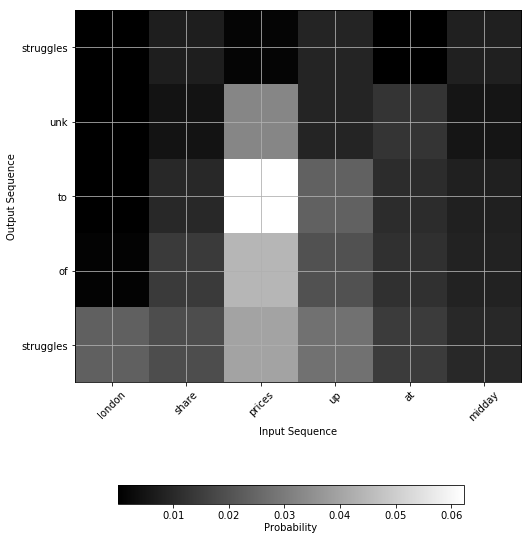

In [498]:
# TO-DO  1
viz.attention_map(reference[0],vector1,idx2word_summary_test2)

In [499]:
# 2
vector2 = np.matrix(transformed_article_data_test2[1105])

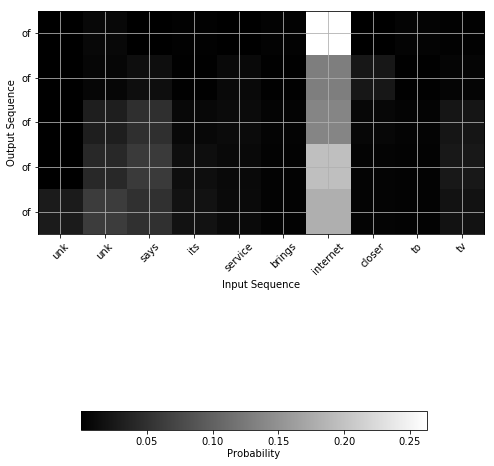

In [500]:
viz.attention_map(reference[1105],vector2,idx2word_summary_test2)

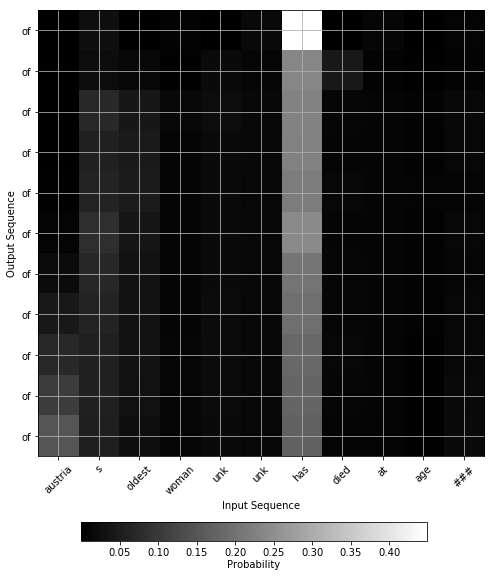

In [501]:
# 3

vector2 = np.matrix(transformed_article_data_test2[2411])
viz.attention_map(reference[2411],vector2,idx2word_summary_test2)

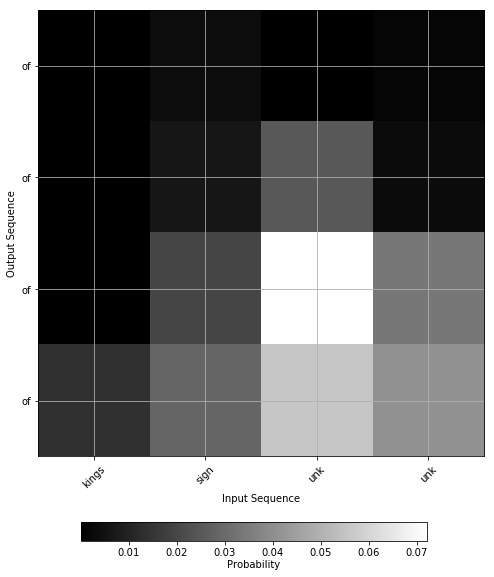

In [502]:
# 4

vector2 = np.matrix(transformed_article_data_test2[2545])
viz.attention_map(reference[2545],vector2,idx2word_summary_test2)

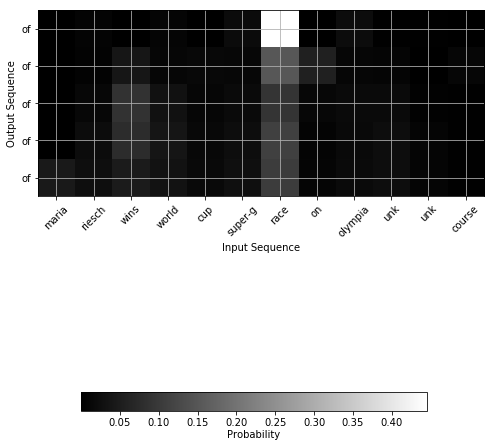

In [503]:
# 5

vector2 = np.matrix(transformed_article_data_test2[2608])
viz.attention_map(reference[2608],vector2,idx2word_summary_test2)

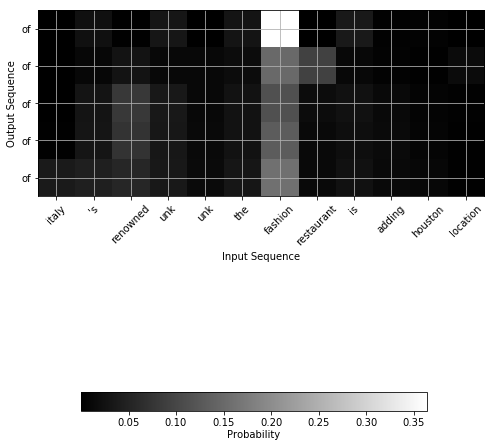

In [504]:
# 6    4827, 5962, 6595, 6927

vector2 = np.matrix(transformed_article_data_test2[3064])
viz.attention_map(reference[3064],vector2,idx2word_summary_test2)

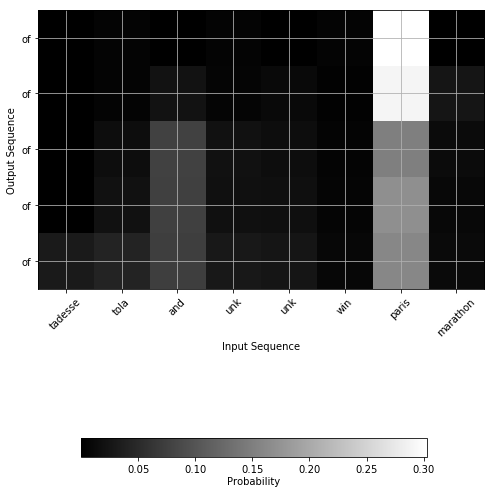

In [505]:
# 7    , 5962, 6595, 6927

vector2 = np.matrix(transformed_article_data_test2[4827])
viz.attention_map(reference[4827],vector2,idx2word_summary_test2)

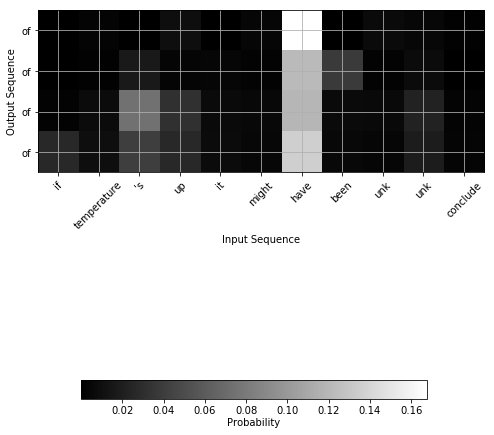

In [506]:
# 8   , 5962, 6595, 6927

vector2 = np.matrix(transformed_article_data_test2[5962])
viz.attention_map(reference[5962],vector2,idx2word_summary_test2)

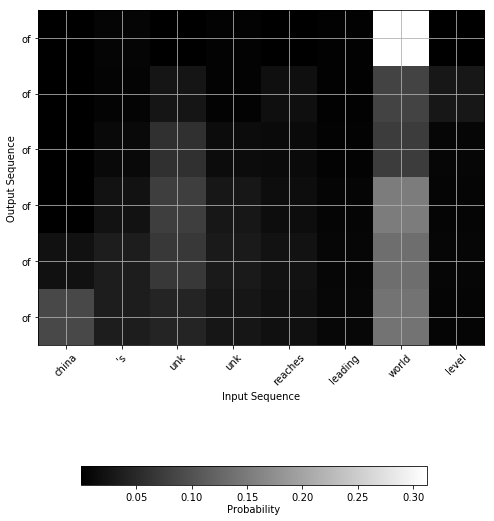

In [507]:
# 9   , 5962, 6595, 6927

vector2 = np.matrix(transformed_article_data_test2[6595])
viz.attention_map(reference[6595],vector2,idx2word_summary_test2)

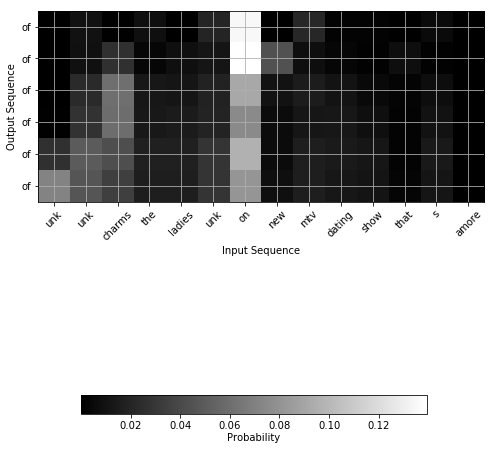

In [508]:
# 10   , 5962, 6595, 6927

vector2 = np.matrix(transformed_article_data_test2[6927])
viz.attention_map(reference[6927],vector2,idx2word_summary_test2)

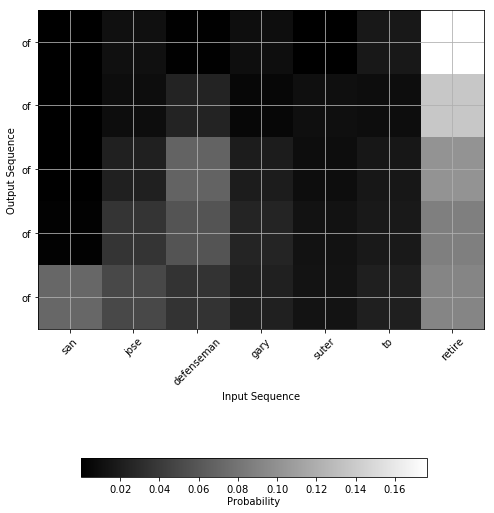

In [509]:
# 11   

vector2 = np.matrix(transformed_article_data_test2[5])
viz.attention_map(reference[5],vector2,idx2word_summary_test2)

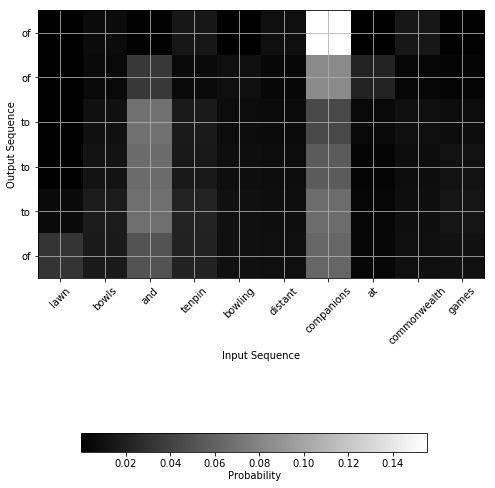

In [510]:
# 12   

vector2 = np.matrix(transformed_article_data_test2[10])
viz.attention_map(reference[10],vector2,idx2word_summary_test2)

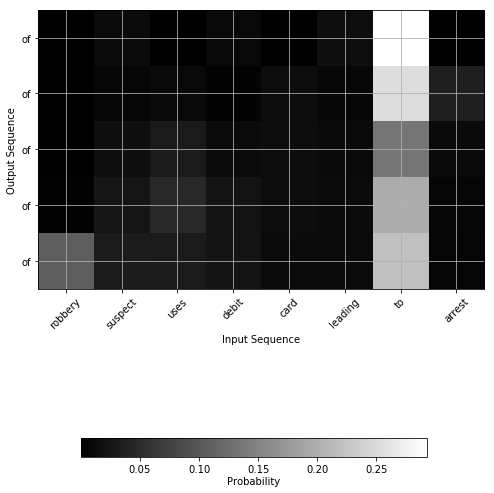

In [511]:
# 13   

vector2 = np.matrix(transformed_article_data_test2[20])
viz.attention_map(reference[20],vector2,idx2word_summary_test2)

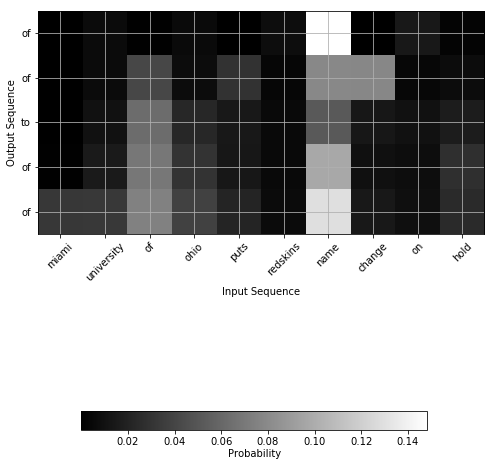

In [512]:
# 14  

vector2 = np.matrix(transformed_article_data_test2[1000])
viz.attention_map(reference[1000],vector2,idx2word_summary_test2)

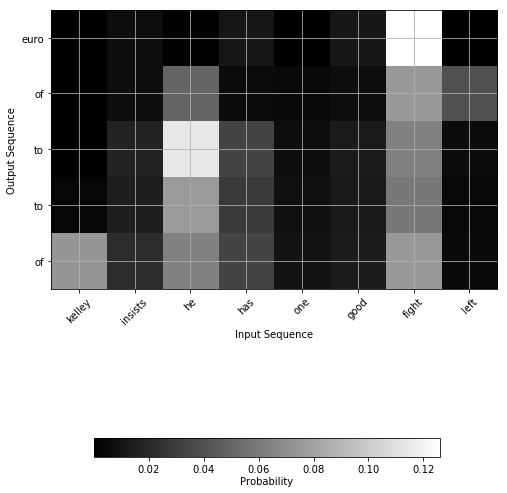

In [513]:
# 15  

vector2 = np.matrix(transformed_article_data_test2[6000])
viz.attention_map(reference[6000],vector2,idx2word_summary_test2)

Some of the predictions are pretty good. Some of them, one word could have strong relationship with all of the other words. The ligher part shows that the attention weights shows that the systems is woking here. The ligher part shows that correspoing words in x and y axis has more probability to related to each other. The prediction works here. 

# Unidirectional LSTM Encoder Decoder With Attention and Beam Search (Extra Credit)

The models that you implemented till now had greedy decoder. Now implement a Decoder with Beam Search and show improved results

In [ ]:

MAX_LEN = 26
VOCAB_SIZE = 8000


BATCH_SIZE = 150 
NUM_LAYERS = 1
HIDDEN_DIM = 30
EPOCHS = 100



In [42]:
# TO-DO 
article_text_train3 =  open('data/train_article.txt', 'r')
summary_text_train3 =  open('data/train_title.txt', 'r')

articleTrain_data3=article_text_train3.read().splitlines()
summaryTrain_data3=summary_text_train3.read().splitlines()

training_article_data3 = load_data(articleTrain_data3,summaryTrain_data3,MAX_LEN,VOCAB_SIZE)

transformed_article_data_train3 = training_article_data3[0]
Vocab_size_of_article_train3 = training_article_data3[1]
word2idx_article_train3 = training_article_data3[2]
dx2word_articl_train3 = training_article_data3[3]
transformed_summary_data_train3 = training_article_data3[4]
Vocab_size_of_summary_train3 = training_article_data3[5]
word2idx_summary_train3 = training_article_data3[6]
idx2word_summary_train3 = training_article_data3[7]

# idx2word_summary_test2[6]  DON'T USE THIS ONE




In [ ]:
from attention_decoder import AttentionDecoder

def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):

    # TO-DO
    model = Sequential()
    # Add embedding layer
    model.add(Embedding(input_dim=X_vocab_len, output_dim=hidden_size,  input_length=MAX_LEN,mask_zero=True,trainable=True))
    # add LSTM encoder layer
    for _ in range (num_layers):
        model.add(LSTM(hidden_size,return_sequences=True, dropout=0.2,recurrent_dropout=0.2))    
    # Add attention decoder layer
    model.add(BeamSearchDecoder(hidden_size, X_vocab_len))
    # Add compile layer
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    # Add summary layer
    model.summary()
    return model